## Introduction

Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [9]:
#Import relevant libraries

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import catboost as cb
from catboost import CatBoostRegressor

import xgboost as xgb
from xgboost import XGBRegressor


import math

from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv('car_data.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [15]:
#Rename Columns
df = df.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', 'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', 'Model': 'model', 'Mileage': 'mileage', 'RegistrationMonth': 'registration_month', 'FuelType': 'fuel_type', 'Brand': 'brand', 'NotRepaired': 'not_repaired', 'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', 'PostalCode': 'postal_code', 'LastSeen': 'last_seen'})

In [17]:
df.head(25)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17
5,04/04/2016 17:36,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,0,33775,06/04/2016 19:17
6,01/04/2016 20:48,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,01/04/2016 00:00,0,67112,05/04/2016 18:18
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
8,04/04/2016 23:42,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,04/04/2016 00:00,0,94505,04/04/2016 23:42
9,17/03/2016 10:53,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,17/03/2016 00:00,0,27472,31/03/2016 17:17


In [19]:
df.describe()

,price,registration_year,power,mileage,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [21]:
#Checking for duplicates

duplicated = df.duplicated().sum()
print(duplicated)

262


In [22]:
print('Percentage of Duplicates:')

duplicated / len(df) * 100

Percentage of Duplicates:


0.07393423239617461

In [25]:
#Dropping duplicate rows

df = df.drop_duplicates()


In [27]:
df.duplicated().sum()

0

Here the percentage of duplicate rows is low enough at 0.07% that we can drop those rows from our dataset. 

In [30]:
#Checking for missing values

df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37484
registration_year         0
gearbox               19830
power                     0
model                 19701
mileage                   0
registration_month        0
fuel_type             32889
brand                     0
not_repaired          71145
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

date_crawled           0.000000
price                  0.000000
vehicle_type          10.585501
registration_year      0.000000
gearbox                5.600002
power                  0.000000
model                  5.563573
mileage                0.000000
registration_month     0.000000
fuel_type              9.287871
brand                  0.000000
not_repaired          20.091385
date_created           0.000000
number_of_pictures     0.000000
postal_code            0.000000
last_seen              0.000000
dtype: float64

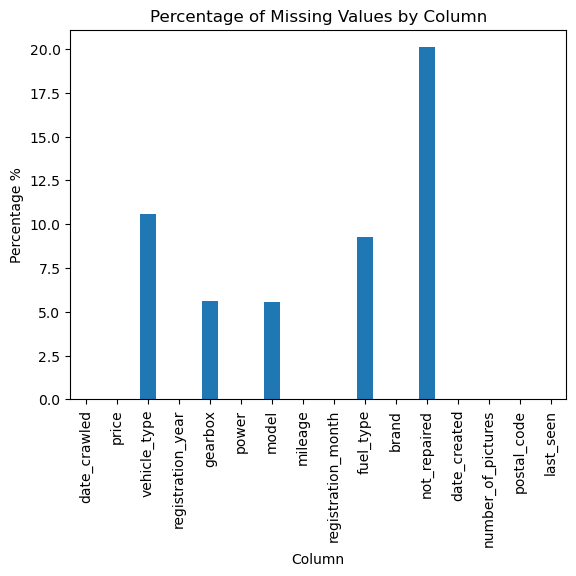

In [32]:
#Percentages of missing values

missing_values = df.isna().sum() * 100 / len(df)
display(missing_values)
missing_values.plot.bar()

plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage %')
plt.xlabel('Column')
plt.show()

At >5% for each of the five columns with missing values, the percentage is too high to remove those values from our dataset. For that reason, I will fill the missing values with 'Unknown'. 

In [35]:
#Filling missing values

df.fillna({'vehicle_type':'unknown', 'gearbox':'unknown', 'model':'unknown', 'fuel_type': 'unknown', 'not_repaired':'unknown'}, inplace=True)

In [37]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
mileage               0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [39]:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,24/03/2016 11:52,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [41]:
#Checking the min and max of each column
df.agg([min,max]).iloc[:,1:]

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
min,0,bus,1000,auto,0,100,5000,0,cng,alfa_romeo,no,01/02/2016 00:00,0,1067,01/04/2016 00:15
max,20000,wagon,9999,unknown,20000,zafira,150000,12,unknown,volvo,yes,31/03/2016 00:00,0,99998,31/03/2016 23:54


In [43]:
df.nunique()

date_crawled          15470
price                  3731
vehicle_type              9
registration_year       151
gearbox                   3
power                   712
model                   251
mileage                  13
registration_month       13
fuel_type                 8
brand                    40
not_repaired              3
date_created            109
number_of_pictures        1
postal_code            8143
last_seen             18592
dtype: int64

In [45]:
print('Registration Year:')
df['registration_year'].unique()

Registration Year:


array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [47]:
print('Registration Month:')
df['registration_month'].unique()

Registration Month:


array([ 0,  5,  8,  6,  7, 10, 12, 11,  2,  3,  1,  4,  9], dtype=int64)

In [49]:
print('Vehicle Type:')
display(df['vehicle_type'].unique())

print('Power:')
display(df['power'].unique())

print('Price:')
display(df['price'].unique())

print('Number of Pictures:')
display(df['number_of_pictures'].unique())



Vehicle Type:


array(['unknown', 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

Power:


array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

Price:


array([  480, 18300,  9800, ..., 12395, 18429, 10985], dtype=int64)

Number of Pictures:


array([0], dtype=int64)

Upon further inspection, some of the columns contain unusual values.

- `price` - Cannot be zero, which was found to be the minimum
- `registration_year` - The minimum is 1000 and the maximum is 9999, which wouldn't make sense as cars began being made in the late 1880's and the current year is 2024.
- `power` - HP cannot be zero or greater than 1500, which is itself a rare case. 1500 is the maximum hp on a street legal vehicle thats available in 2024.
- `registration_month` - Cannot be zero, which is the minimum.
- `postal_code` - Cannot contain only 4 digits
- `number_of_pictures` only contains the the value 0 for all rows


First I will address the `number_of_pictures` column by removing it as it is not necessary. 

In [53]:
#Dropping number_of_pictures column
df = df.drop(['number_of_pictures'], axis=1)

Then, I will look into the `price` column values that are zero.

In [56]:
#Checking the percentage of rows with the value of '0' in the `price` column

price_zero = df['price'] == 0

print('Percentage of Price Column that is 0:')
print(price_zero.sum() * 100 / len(df['price'])) 

Percentage of Price Column that is 0:
3.041453571942944


Due to the percentage of vehicles listed with a price of zero being only 3.04%, I will remove those listings from the dataset. It is feasible that very low prices, ie. < $500, means that the vehicle is selling just for parts so I will keep those entries intact.

In [59]:
df = df.drop(df[df['price'] == 0].index)

In [61]:
display(df['price'].min())
display(df.info())

1

<class 'pandas.core.frame.DataFrame'>
Index: 343337 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        343337 non-null  object
 1   price               343337 non-null  int64 
 2   vehicle_type        343337 non-null  object
 3   registration_year   343337 non-null  int64 
 4   gearbox             343337 non-null  object
 5   power               343337 non-null  int64 
 6   model               343337 non-null  object
 7   mileage             343337 non-null  int64 
 8   registration_month  343337 non-null  int64 
 9   fuel_type           343337 non-null  object
 10  brand               343337 non-null  object
 11  not_repaired        343337 non-null  object
 12  date_created        343337 non-null  object
 13  postal_code         343337 non-null  int64 
 14  last_seen           343337 non-null  object
dtypes: int64(6), object(9)
memory usage: 41.9+ MB


None

Next, I will look into the `power` column values that are zero, as hp of a vehicle cannot be zero, or greater than 1500.

In [64]:
#Checking the percentage of rows with the value of '0' in the `power` column

power_threshold = ((df['power'] == 0) | (df['power'] > 1500)) 

print('Percentage of Power Column That is 0 or Greater Than 1500:')
print(power_threshold.sum() * 100 / len(df['power'])) 

Percentage of Power Column That is 0 or Greater Than 1500:
10.643769823817415


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 343337 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        343337 non-null  object
 1   price               343337 non-null  int64 
 2   vehicle_type        343337 non-null  object
 3   registration_year   343337 non-null  int64 
 4   gearbox             343337 non-null  object
 5   power               343337 non-null  int64 
 6   model               343337 non-null  object
 7   mileage             343337 non-null  int64 
 8   registration_month  343337 non-null  int64 
 9   fuel_type           343337 non-null  object
 10  brand               343337 non-null  object
 11  not_repaired        343337 non-null  object
 12  date_created        343337 non-null  object
 13  postal_code         343337 non-null  int64 
 14  last_seen           343337 non-null  object
dtypes: int64(6), object(9)
memory usage: 41.9+ MB


In [68]:
#Dropping those entries from the dataframe

df = df.drop(df[df['power'] == 0].index)
df = df.drop(df[df['power'] > 1500].index)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306793 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        306793 non-null  object
 1   price               306793 non-null  int64 
 2   vehicle_type        306793 non-null  object
 3   registration_year   306793 non-null  int64 
 4   gearbox             306793 non-null  object
 5   power               306793 non-null  int64 
 6   model               306793 non-null  object
 7   mileage             306793 non-null  int64 
 8   registration_month  306793 non-null  int64 
 9   fuel_type           306793 non-null  object
 10  brand               306793 non-null  object
 11  not_repaired        306793 non-null  object
 12  date_created        306793 non-null  object
 13  postal_code         306793 non-null  int64 
 14  last_seen           306793 non-null  object
dtypes: int64(6), object(9)
memory usage: 37.5+ MB


Because `postal_code` is a categorical data column, I will not change anything to it despite the entries with only 4 digits.

Next, I will check the `registration_month` column for the percentage of 0's. The range should be 1-12, not 0-12. Those values will be randomly distrubuted amongst values 1-12, as registration month should not have a material affect on vehicle pricing.

In [72]:
months_zero = df['registration_month'] == 0
display(months_zero.value_counts())

print('Percentage of `Registration Month` Column Equal to Zero:')
display(months_zero.sum() * 100 / len(df['registration_month']))

#Randomly distributing months = 0 to other months
random_months = np.random.randint(1, 13, size=months_zero.sum())
df.loc[months_zero, 'registration_month'] = random_months

display(df['registration_month'].value_counts())

registration_month
False    286699
True      20094
Name: count, dtype: int64

Percentage of `Registration Month` Column Equal to Zero:


6.549693115553484

registration_month
3     33012
6     30127
4     28290
5     28122
7     26215
10    25261
12    23528
11    23418
9     23188
1     22464
8     22013
2     21155
Name: count, dtype: int64

Finally, I will deal with the `registration_year` column values that are unusual.

In [75]:
year_mask = (df['registration_year'] < 1886) | (df['registration_year'] > 2024)
df[year_mask]['registration_year'].nunique()

18

In [77]:
df[year_mask]['registration_year'].value_counts()

registration_year
1000    6
5000    6
6000    3
5911    2
4000    2
1800    2
1500    1
4500    1
2800    1
3000    1
9999    1
4800    1
6500    1
1234    1
8000    1
1400    1
2900    1
8200    1
Name: count, dtype: int64

From the mask it appears that there are only 33 total values falling outside of possible vehicle registration years. I will remove those vehicles from the dataset.

In [80]:
df = df[~year_mask]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306760 entries, 1 to 354368
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        306760 non-null  object
 1   price               306760 non-null  int64 
 2   vehicle_type        306760 non-null  object
 3   registration_year   306760 non-null  int64 
 4   gearbox             306760 non-null  object
 5   power               306760 non-null  int64 
 6   model               306760 non-null  object
 7   mileage             306760 non-null  int64 
 8   registration_month  306760 non-null  int64 
 9   fuel_type           306760 non-null  object
 10  brand               306760 non-null  object
 11  not_repaired        306760 non-null  object
 12  date_created        306760 non-null  object
 13  postal_code         306760 non-null  int64 
 14  last_seen           306760 non-null  object
dtypes: int64(6), object(9)
memory usage: 37.4+ MB


## Model training

### Linear Regression

In [83]:
#Dropping the `date_crawled` and `last_seen` columns

df = df.drop(['date_crawled', 'last_seen'], axis=1)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306760 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               306760 non-null  int64 
 1   vehicle_type        306760 non-null  object
 2   registration_year   306760 non-null  int64 
 3   gearbox             306760 non-null  object
 4   power               306760 non-null  int64 
 5   model               306760 non-null  object
 6   mileage             306760 non-null  int64 
 7   registration_month  306760 non-null  int64 
 8   fuel_type           306760 non-null  object
 9   brand               306760 non-null  object
 10  not_repaired        306760 non-null  object
 11  date_created        306760 non-null  object
 12  postal_code         306760 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 32.8+ MB


In [87]:
df.head(5)

,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_created,postal_code
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,24/03/2016 00:00,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,14/03/2016 00:00,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,04/04/2016 00:00,33775


In [89]:
#One-Hot encoding the dataframe for the linear regression model

categorical_cols = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'date_created']
df_ohe = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [91]:
df_ohe.info

<bound method DataFrame.info of         price  registration_year  power  mileage  registration_month  \
1       18300               2011    190   125000                   5   
2        9800               2004    163   125000                   8   
3        1500               2001     75   150000                   6   
4        3600               2008     69    90000                   7   
5         650               1995    102   150000                  10   
...       ...                ...    ...      ...                 ...   
354361   5250               2016    150   150000                  12   
354362   3200               2004    225   150000                   5   
354366   1199               2000    101   125000                   3   
354367   9200               1996    102   150000                   3   
354368   3400               2002    100   150000                   6   

        postal_code  vehicle_type_convertible  vehicle_type_coupe  \
1             66954               

In [93]:
#Define target and features
target_ohe = df_ohe['price']
features_ohe = df_ohe.drop(['price'], axis=1)


In [95]:
#Splitting the data

features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features_ohe, target_ohe, test_size=0.3, random_state=54321)

In [97]:
#Scaling the OHE Data

scaler = StandardScaler()
scaler.fit(features_train_ohe)

features_train_scaled = scaler.transform(features_train_ohe)
features_valid_scaled = scaler.transform(features_valid_ohe)

In [98]:
%%time

#Initializing the LR model

model_lr = LinearRegression()
model_lr.fit(features_train_scaled, target_train_ohe)
predict_valid_lr = model_lr.predict(features_valid_scaled)

result = mean_squared_error(target_valid_ohe, predict_valid_lr) ** 0.5
print('RMSE of the linear regression model on the validation set:', result)

RMSE of the linear regression model on the validation set: 4889632971594.656
CPU times: total: 20.5 s
Wall time: 6.64 s


<div class="alert alert-block alert-info">
I'm not sure why the RMSE of the LR model is so abnormally high. Is it because I didn't scale the target_train and target_valid?
</div>

The models fails to learn for some reason, maybe there is a multicollinearity problem (i.e. some features in the feature matrix are close to linear dependence, which would result in the feature matrix being close to a singular matrix). I'd suggest trying to start with one feature and add back features one by one to find the problem.
    
Scaling targets shouldn't be a problem.

### XGBoost

In [40]:
%%time

#Tuning hyperparameters for XGBoost
param_grid = {
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.1, 0.01, 0.05],
    'gamma': [0, 0.25, 1.0],
    'reg_lambda': [0, 1.0, 10.0],
}

#Initializing the XGBoost model on the OHE dataframe
model_xgb = xgb.XGBRegressor(params=param_grid, missing=None, seed=54321)

model_xgb.fit(features_train_scaled,
              target_train_ohe,
              verbose=2,
             early_stopping_rounds=10,
             eval_metric='rmse',
             eval_set=[(features_valid_scaled, target_valid_ohe)])

[23:12:06] WARNING: ../src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:4952.13184
[2]	validation_0-rmse:3090.61182
[4]	validation_0-rmse:2344.72412
[6]	validation_0-rmse:2065.85083
[8]	validation_0-rmse:1933.41956
[10]	validation_0-rmse:1867.61011
[12]	validation_0-rmse:1834.68860
[14]	validation_0-rmse:1808.06592
[16]	validation_0-rmse:1794.49377
[18]	validation_0-rmse:1782.04126
[20]	validation_0-rmse:1771.57727
[22]	validation_0-rmse:1762.87451
[24]	validation_0-rmse:1755.98511
[26]	validation_0-rmse:1751.57898
[28]	validation_0-rmse:1743.56921
[30]	validation_0-rmse:1739.85852
[32]	validation_0-rmse:1735.25830
[34]	validation_0-rmse:1732.39453
[36]	validation_0-rmse:1729.50330
[3

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1,
             params={'gamma': [0, 0.25, 1.0],
                     'learning_rate': [0.1, 0.01, 0.05],
                     'max_depth': [2, 3, 4, 5, 6],
                     'reg_lambda': [0, 1.0, 10.0]},
             predictor='auto', random_state=54321, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, seed=54321, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [103]:
#Delete the One-Hot Encoded dataframe to free up space
del df_ohe

### Decision Tree Regression

#### Label Encoding the original DF for DTR and RFR

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306760 entries, 1 to 354368
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               306760 non-null  int64 
 1   vehicle_type        306760 non-null  object
 2   registration_year   306760 non-null  int64 
 3   gearbox             306760 non-null  object
 4   power               306760 non-null  int64 
 5   model               306760 non-null  object
 6   mileage             306760 non-null  int64 
 7   registration_month  306760 non-null  int64 
 8   fuel_type           306760 non-null  object
 9   brand               306760 non-null  object
 10  not_repaired        306760 non-null  object
 11  date_created        306760 non-null  object
 12  postal_code         306760 non-null  int64 
dtypes: int64(6), object(7)
memory usage: 32.8+ MB


In [107]:
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired', 'date_created']
label_encoder = OrdinalEncoder()
df_le = label_encoder.fit_transform(df[cat_columns])
reset_index_df = df.reset_index(drop=True).copy()
df_le = pd.concat([reset_index_df.drop(columns=cat_columns), pd.DataFrame(df_le, columns=cat_columns)], axis=1)

df_le.head()


,price,registration_year,power,mileage,registration_month,postal_code,vehicle_type,gearbox,model,fuel_type,brand,not_repaired,date_created
0,18300,2011,190,125000,5,66954,2.0,1.0,227.0,2.0,1.0,2.0,84.0
1,9800,2004,163,125000,8,90480,6.0,0.0,117.0,2.0,14.0,1.0,51.0
2,1500,2001,75,150000,6,91074,5.0,1.0,116.0,6.0,38.0,0.0,60.0
3,3600,2008,69,90000,7,60437,5.0,1.0,101.0,2.0,31.0,0.0,106.0
4,650,1995,102,150000,10,33775,4.0,1.0,11.0,6.0,2.0,2.0,14.0


In [109]:
#Defining label encoded features and target
features_le = df_le.drop('price', axis=1)
target_le = df_le['price']

#Splitting the label encoded data
features_train_le, features_valid_le, target_train_le, target_valid_le = train_test_split(features_le, target_le, test_size=0.3, random_state=54321)

In [111]:
%%time

#Initializing the model
model_dt = DecisionTreeRegressor(random_state=54321)

dt_params = [{'max_depth': [1, 20],
                    "splitter": ['best', 'random'],
                    'max_features': sp_randint(1, 10)}]

dt_clf = RandomizedSearchCV(model_dt, dt_params, cv=5)
dt_clf.fit(features_train_le, target_train_le)

print('Best Params:\n', dt_clf.best_params_)
print('')

Best Params:
 {'max_depth': 20, 'max_features': 5, 'splitter': 'best'}

CPU times: total: 11.8 s
Wall time: 12.2 s


In [113]:
%%time

dt_predict = dt_clf.predict(features_valid_le)
result = mean_squared_error(target_valid_le, dt_predict) ** 0.5

print('Decision Tree RMSE:', result)

Decision Tree RMSE: 2149.609947484459
CPU times: total: 15.6 ms
Wall time: 60.9 ms


### Random Forest Regression

In [73]:
%%time

#Initializing the model
#model_rf = RandomForestRegressor(random_state=54321)

#rf_params = [{'max_depth': [1, 20],
                    #'max_features': sp_randint(1, 10)}]

#rf_clf = RandomizedSearchCV(model_rf, rf_params, cv=5)
#rf_clf.fit(features_train_le, target_train_le)

#print('Best Random Forest Parameters:', rf_clf.best_params_)
#print('')

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


Best Random Forest Parameters: {'max_depth': 20, 'max_features': 6}

Wall time: 20min 59s

In [117]:
%%time

#rf_predict = rf_clf.predict(features_valid_le)
#result = mean_squared_error(target_valid_le, rf_predict) ** 0.5

#print('Random Forest RMSE:', result)

CPU times: total: 0 ns
Wall time: 0 ns


### LGBM

In [119]:
#Create LGBM dataset for training (Using Label Encoded Data)
train_data = lgb.Dataset(features_train_le, label=target_train_le)
val_data = lgb.Dataset(features_valid_le, label=target_valid_le, reference=train_data)

#Definte initial set of LGBM Parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
}

In [128]:
%%time

#Initialize the LGBM Model
num_round = 100
model_lgbm = lgb.train(params, train_data, num_round, valid_sets=[val_data])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1000
[LightGBM] [Info] Number of data points in the train set: 214732, number of used features: 12
[LightGBM] [Info] Start training from score 4805.370900
CPU times: total: 10.6 s
Wall time: 1.62 s


### CatBoost

In [130]:
#Combine features and target into a train and validation dataset.

train = cb.Pool(features_train_le, target_train_le)
valid = cb.Pool(features_valid_le, target_valid_le)

In [59]:
%%time

#Initialize CatBoost Model
cb_model = cb.CatBoostRegressor(loss_function='RMSE')

#Hyperparameters
params_grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

#Training the model
cb_model.grid_search(params_grid, train)

0:	learn: 6493.4313110	test: 6487.7753270	best: 6487.7753270 (0)	total: 78.3ms	remaining: 7.75s
1:	learn: 6350.6937962	test: 6345.1193184	best: 6345.1193184 (1)	total: 104ms	remaining: 5.12s
2:	learn: 6213.0239702	test: 6207.4865436	best: 6207.4865436 (2)	total: 130ms	remaining: 4.21s
3:	learn: 6080.5739700	test: 6075.2735521	best: 6075.2735521 (3)	total: 155ms	remaining: 3.72s
4:	learn: 5952.6446385	test: 5947.4151344	best: 5947.4151344 (4)	total: 181ms	remaining: 3.43s
5:	learn: 5830.1306173	test: 5825.2010932	best: 5825.2010932 (5)	total: 210ms	remaining: 3.3s
6:	learn: 5711.1071637	test: 5706.0968110	best: 5706.0968110 (6)	total: 239ms	remaining: 3.17s
7:	learn: 5597.1461406	test: 5592.1913585	best: 5592.1913585 (7)	total: 269ms	remaining: 3.09s
8:	learn: 5488.2219619	test: 5483.1906324	best: 5483.1906324 (8)	total: 296ms	remaining: 2.99s
9:	learn: 5382.2822856	test: 5377.0091107	best: 5377.0091107 (9)	total: 322ms	remaining: 2.89s
10:	learn: 5280.9494269	test: 5275.9508461	best: 5

90:	learn: 2692.8628637	test: 2686.2576141	best: 2686.2576141 (90)	total: 2.39s	remaining: 236ms
91:	learn: 2681.6703246	test: 2674.9768791	best: 2674.9768791 (91)	total: 2.41s	remaining: 210ms
92:	learn: 2675.4363130	test: 2668.8925206	best: 2668.8925206 (92)	total: 2.44s	remaining: 184ms
93:	learn: 2669.4925362	test: 2662.7471749	best: 2662.7471749 (93)	total: 2.47s	remaining: 158ms
94:	learn: 2663.5177967	test: 2656.9245707	best: 2656.9245707 (94)	total: 2.49s	remaining: 131ms
95:	learn: 2653.3207365	test: 2646.5802119	best: 2646.5802119 (95)	total: 2.52s	remaining: 105ms
96:	learn: 2647.6512417	test: 2640.7204792	best: 2640.7204792 (96)	total: 2.54s	remaining: 78.7ms
97:	learn: 2642.0416904	test: 2635.0385079	best: 2635.0385079 (97)	total: 2.57s	remaining: 52.4ms
98:	learn: 2636.4492425	test: 2629.3800021	best: 2629.3800021 (98)	total: 2.59s	remaining: 26.2ms
99:	learn: 2631.1899877	test: 2624.0128690	best: 2624.0128690 (99)	total: 2.62s	remaining: 0us

bestTest = 2624.012869
bestI

76:	learn: 2237.1106934	test: 2228.9132126	best: 2228.9132126 (76)	total: 2.06s	remaining: 614ms
77:	learn: 2232.0374727	test: 2223.6950374	best: 2223.6950374 (77)	total: 2.08s	remaining: 587ms
78:	learn: 2229.7161253	test: 2221.3228094	best: 2221.3228094 (78)	total: 2.1s	remaining: 560ms
79:	learn: 2227.0432672	test: 2219.0766694	best: 2219.0766694 (79)	total: 2.13s	remaining: 533ms
80:	learn: 2224.5169617	test: 2216.7071139	best: 2216.7071139 (80)	total: 2.15s	remaining: 505ms
81:	learn: 2220.9190994	test: 2212.8894853	best: 2212.8894853 (81)	total: 2.18s	remaining: 478ms
82:	learn: 2218.7041708	test: 2210.9073361	best: 2210.9073361 (82)	total: 2.2s	remaining: 451ms
83:	learn: 2215.7197203	test: 2207.8622487	best: 2207.8622487 (83)	total: 2.23s	remaining: 424ms
84:	learn: 2210.9452159	test: 2203.2253877	best: 2203.2253877 (84)	total: 2.25s	remaining: 398ms
85:	learn: 2208.9147011	test: 2201.4092020	best: 2201.4092020 (85)	total: 2.28s	remaining: 371ms
86:	learn: 2205.2423744	test: 21

66:	learn: 2925.9491093	test: 2921.6902245	best: 2921.6902245 (66)	total: 1.81s	remaining: 891ms
67:	learn: 2913.2257820	test: 2908.9656736	best: 2908.9656736 (67)	total: 1.83s	remaining: 863ms
68:	learn: 2900.4891191	test: 2896.1240507	best: 2896.1240507 (68)	total: 1.86s	remaining: 835ms
69:	learn: 2888.5682534	test: 2884.0962644	best: 2884.0962644 (69)	total: 1.89s	remaining: 809ms
70:	learn: 2876.0775961	test: 2871.2303267	best: 2871.2303267 (70)	total: 1.91s	remaining: 782ms
71:	learn: 2864.1361373	test: 2859.1312351	best: 2859.1312351 (71)	total: 1.94s	remaining: 755ms
72:	learn: 2853.2017081	test: 2848.3697985	best: 2848.3697985 (72)	total: 1.97s	remaining: 728ms
73:	learn: 2843.0355428	test: 2838.4049692	best: 2838.4049692 (73)	total: 1.99s	remaining: 701ms
74:	learn: 2831.3187272	test: 2826.3491156	best: 2826.3491156 (74)	total: 2.02s	remaining: 674ms
75:	learn: 2821.5283634	test: 2816.7288157	best: 2816.7288157 (75)	total: 2.05s	remaining: 646ms
76:	learn: 2811.9469490	test: 

55:	learn: 2327.3350354	test: 2318.5861630	best: 2318.5861630 (55)	total: 1.4s	remaining: 1.1s
56:	learn: 2322.7216972	test: 2314.1428811	best: 2314.1428811 (56)	total: 1.43s	remaining: 1.08s
57:	learn: 2315.4703039	test: 2306.7114682	best: 2306.7114682 (57)	total: 1.45s	remaining: 1.05s
58:	learn: 2310.8972951	test: 2302.2483669	best: 2302.2483669 (58)	total: 1.48s	remaining: 1.02s
59:	learn: 2304.9624014	test: 2296.1720351	best: 2296.1720351 (59)	total: 1.5s	remaining: 998ms
60:	learn: 2300.1504917	test: 2291.3957838	best: 2291.3957838 (60)	total: 1.52s	remaining: 972ms
61:	learn: 2296.3029137	test: 2287.8527196	best: 2287.8527196 (61)	total: 1.54s	remaining: 946ms
62:	learn: 2292.5589549	test: 2284.2182429	best: 2284.2182429 (62)	total: 1.57s	remaining: 921ms
63:	learn: 2286.3613495	test: 2277.9464724	best: 2277.9464724 (63)	total: 1.59s	remaining: 896ms
64:	learn: 2281.2758158	test: 2272.7114501	best: 2272.7114501 (64)	total: 1.62s	remaining: 870ms
65:	learn: 2277.4284167	test: 226

40:	learn: 3479.3466771	test: 3473.8127542	best: 3473.8127542 (40)	total: 1.12s	remaining: 1.61s
41:	learn: 3448.4123250	test: 3442.9270134	best: 3442.9270134 (41)	total: 1.15s	remaining: 1.58s
42:	learn: 3416.5272129	test: 3410.7945581	best: 3410.7945581 (42)	total: 1.18s	remaining: 1.56s
43:	learn: 3385.4770146	test: 3379.2565172	best: 3379.2565172 (43)	total: 1.2s	remaining: 1.53s
44:	learn: 3355.7906970	test: 3349.4055104	best: 3349.4055104 (44)	total: 1.23s	remaining: 1.5s
45:	learn: 3327.5098847	test: 3321.5310759	best: 3321.5310759 (45)	total: 1.25s	remaining: 1.47s
46:	learn: 3302.0828914	test: 3296.2575184	best: 3296.2575184 (46)	total: 1.28s	remaining: 1.45s
47:	learn: 3275.6079052	test: 3269.5097894	best: 3269.5097894 (47)	total: 1.31s	remaining: 1.42s
48:	learn: 3250.7217235	test: 3244.3962296	best: 3244.3962296 (48)	total: 1.33s	remaining: 1.39s
49:	learn: 3228.4101757	test: 3221.8028255	best: 3221.8028255 (49)	total: 1.36s	remaining: 1.36s
50:	learn: 3205.0983487	test: 31

28:	learn: 2635.0040928	test: 2627.0910026	best: 2627.0910026 (28)	total: 753ms	remaining: 1.84s
29:	learn: 2614.2778287	test: 2605.7402915	best: 2605.7402915 (29)	total: 781ms	remaining: 1.82s
30:	learn: 2598.3564733	test: 2589.3857182	best: 2589.3857182 (30)	total: 807ms	remaining: 1.79s
31:	learn: 2582.2853399	test: 2573.8005614	best: 2573.8005614 (31)	total: 832ms	remaining: 1.77s
32:	learn: 2555.9617247	test: 2547.0307061	best: 2547.0307061 (32)	total: 855ms	remaining: 1.74s
33:	learn: 2541.2903898	test: 2533.0255624	best: 2533.0255624 (33)	total: 879ms	remaining: 1.71s
34:	learn: 2528.0025495	test: 2519.5899592	best: 2519.5899592 (34)	total: 903ms	remaining: 1.68s
35:	learn: 2515.1564421	test: 2506.1301303	best: 2506.1301303 (35)	total: 926ms	remaining: 1.65s
36:	learn: 2503.0518217	test: 2495.0516279	best: 2495.0516279 (36)	total: 950ms	remaining: 1.62s
37:	learn: 2482.0434193	test: 2473.6429581	best: 2473.6429581 (37)	total: 976ms	remaining: 1.59s
38:	learn: 2471.6102868	test: 

16:	learn: 4747.3537190	test: 4742.7715004	best: 4742.7715004 (16)	total: 454ms	remaining: 2.22s
17:	learn: 4669.0996485	test: 4664.3168701	best: 4664.3168701 (17)	total: 483ms	remaining: 2.2s
18:	learn: 4593.5500115	test: 4589.0707497	best: 4589.0707497 (18)	total: 506ms	remaining: 2.16s
19:	learn: 4521.8731949	test: 4517.3985131	best: 4517.3985131 (19)	total: 532ms	remaining: 2.13s
20:	learn: 4451.2903627	test: 4446.7927013	best: 4446.7927013 (20)	total: 557ms	remaining: 2.09s
21:	learn: 4384.1026462	test: 4379.5201604	best: 4379.5201604 (21)	total: 582ms	remaining: 2.06s
22:	learn: 4318.4242518	test: 4313.7355662	best: 4313.7355662 (22)	total: 607ms	remaining: 2.03s
23:	learn: 4257.7676372	test: 4253.1927811	best: 4253.1927811 (23)	total: 633ms	remaining: 2s
24:	learn: 4197.9293939	test: 4193.2533562	best: 4193.2533562 (24)	total: 657ms	remaining: 1.97s
25:	learn: 4141.7623993	test: 4137.0657289	best: 4137.0657289 (25)	total: 688ms	remaining: 1.96s
26:	learn: 4087.9459231	test: 4083

0:	learn: 6151.7201052	test: 6146.1070286	best: 6146.1070286 (0)	total: 27.7ms	remaining: 2.74s
1:	learn: 5722.5548240	test: 5717.2613590	best: 5717.2613590 (1)	total: 53.8ms	remaining: 2.64s
2:	learn: 5346.9850528	test: 5342.3343854	best: 5342.3343854 (2)	total: 79.3ms	remaining: 2.56s
3:	learn: 5015.9130132	test: 5011.6512085	best: 5011.6512085 (3)	total: 108ms	remaining: 2.6s
4:	learn: 4732.3016858	test: 4728.2376734	best: 4728.2376734 (4)	total: 133ms	remaining: 2.52s
5:	learn: 4474.8982671	test: 4470.6070054	best: 4470.6070054 (5)	total: 158ms	remaining: 2.47s
6:	learn: 4257.9228690	test: 4253.6320124	best: 4253.6320124 (6)	total: 183ms	remaining: 2.42s
7:	learn: 4055.8249334	test: 4051.0082172	best: 4051.0082172 (7)	total: 210ms	remaining: 2.41s
8:	learn: 3879.1263806	test: 3873.7683947	best: 3873.7683947 (8)	total: 235ms	remaining: 2.37s
9:	learn: 3718.9641584	test: 3712.6618482	best: 3712.6618482 (9)	total: 259ms	remaining: 2.33s
10:	learn: 3588.9940996	test: 3583.2086543	best:

88:	learn: 2199.3273198	test: 2192.0834252	best: 2192.0834252 (88)	total: 2.19s	remaining: 270ms
89:	learn: 2196.1732547	test: 2188.7849508	best: 2188.7849508 (89)	total: 2.21s	remaining: 246ms
90:	learn: 2194.0951340	test: 2186.8311284	best: 2186.8311284 (90)	total: 2.23s	remaining: 221ms
91:	learn: 2190.3548523	test: 2183.2280601	best: 2183.2280601 (91)	total: 2.26s	remaining: 196ms
92:	learn: 2188.3822912	test: 2181.3772068	best: 2181.3772068 (92)	total: 2.28s	remaining: 171ms
93:	learn: 2186.5284422	test: 2179.1871332	best: 2179.1871332 (93)	total: 2.3s	remaining: 147ms
94:	learn: 2184.8414293	test: 2177.6220623	best: 2177.6220623 (94)	total: 2.32s	remaining: 122ms
95:	learn: 2183.2709401	test: 2176.2726851	best: 2176.2726851 (95)	total: 2.35s	remaining: 97.8ms
96:	learn: 2180.9228756	test: 2173.8714681	best: 2173.8714681 (96)	total: 2.37s	remaining: 73.3ms
97:	learn: 2178.4239512	test: 2171.1679879	best: 2171.1679879 (97)	total: 2.4s	remaining: 48.9ms
98:	learn: 2176.6878385	test:

80:	learn: 2773.8077093	test: 2768.0506386	best: 2768.0506386 (80)	total: 2.04s	remaining: 1.74s
81:	learn: 2765.6215621	test: 2759.9444601	best: 2759.9444601 (81)	total: 2.06s	remaining: 1.71s
82:	learn: 2757.1799213	test: 2751.3778686	best: 2751.3778686 (82)	total: 2.09s	remaining: 1.69s
83:	learn: 2748.8392350	test: 2742.7380682	best: 2742.7380682 (83)	total: 2.12s	remaining: 1.66s
84:	learn: 2741.1571779	test: 2735.0332083	best: 2735.0332083 (84)	total: 2.14s	remaining: 1.64s
85:	learn: 2728.5618120	test: 2722.3473189	best: 2722.3473189 (85)	total: 2.16s	remaining: 1.61s
86:	learn: 2721.3913116	test: 2714.9861693	best: 2714.9861693 (86)	total: 2.19s	remaining: 1.58s
87:	learn: 2714.3769093	test: 2707.8770722	best: 2707.8770722 (87)	total: 2.21s	remaining: 1.56s
88:	learn: 2707.2373392	test: 2700.8943720	best: 2700.8943720 (88)	total: 2.24s	remaining: 1.53s
89:	learn: 2699.3215291	test: 2692.9197837	best: 2692.9197837 (89)	total: 2.26s	remaining: 1.51s
90:	learn: 2692.8628637	test: 

17:	learn: 2991.4859971	test: 2984.8163325	best: 2984.8163325 (17)	total: 477ms	remaining: 3.5s
18:	learn: 2941.2816953	test: 2935.2149144	best: 2935.2149144 (18)	total: 502ms	remaining: 3.46s
19:	learn: 2895.3331973	test: 2888.8613110	best: 2888.8613110 (19)	total: 526ms	remaining: 3.42s
20:	learn: 2855.3537035	test: 2849.2212317	best: 2849.2212317 (20)	total: 548ms	remaining: 3.37s
21:	learn: 2818.3053303	test: 2811.5711740	best: 2811.5711740 (21)	total: 574ms	remaining: 3.34s
22:	learn: 2784.6437427	test: 2778.4793390	best: 2778.4793390 (22)	total: 599ms	remaining: 3.3s
23:	learn: 2754.0884126	test: 2746.8811264	best: 2746.8811264 (23)	total: 624ms	remaining: 3.27s
24:	learn: 2727.3294950	test: 2720.1772025	best: 2720.1772025 (24)	total: 646ms	remaining: 3.23s
25:	learn: 2699.3162775	test: 2692.3832522	best: 2692.3832522 (25)	total: 671ms	remaining: 3.2s
26:	learn: 2675.6020554	test: 2668.5571807	best: 2668.5571807 (26)	total: 693ms	remaining: 3.16s
27:	learn: 2654.1887420	test: 264

106:	learn: 2159.9352632	test: 2152.8741892	best: 2152.8741892 (106)	total: 2.63s	remaining: 1.06s
107:	learn: 2158.1969597	test: 2151.2073543	best: 2151.2073543 (107)	total: 2.66s	remaining: 1.03s
108:	learn: 2156.0260192	test: 2148.9183305	best: 2148.9183305 (108)	total: 2.68s	remaining: 1.01s
109:	learn: 2154.7887639	test: 2147.6514400	best: 2147.6514400 (109)	total: 2.7s	remaining: 983ms
110:	learn: 2153.4164012	test: 2146.3819274	best: 2146.3819274 (110)	total: 2.73s	remaining: 958ms
111:	learn: 2152.0107055	test: 2144.8242706	best: 2144.8242706 (111)	total: 2.75s	remaining: 933ms
112:	learn: 2150.6761875	test: 2143.5148507	best: 2143.5148507 (112)	total: 2.77s	remaining: 908ms
113:	learn: 2148.1992553	test: 2140.9918221	best: 2140.9918221 (113)	total: 2.8s	remaining: 884ms
114:	learn: 2146.4814144	test: 2139.2295893	best: 2139.2295893 (114)	total: 2.82s	remaining: 859ms
115:	learn: 2144.5185065	test: 2137.0365716	best: 2137.0365716 (115)	total: 2.85s	remaining: 836ms
116:	learn: 

41:	learn: 3448.3886305	test: 3442.9034616	best: 3442.9034616 (41)	total: 1.08s	remaining: 2.77s
42:	learn: 3416.5036283	test: 3410.7711139	best: 3410.7711139 (42)	total: 1.1s	remaining: 2.75s
43:	learn: 3385.4537348	test: 3379.2333760	best: 3379.2333760 (43)	total: 1.13s	remaining: 2.73s
44:	learn: 3355.7675845	test: 3349.3825333	best: 3349.3825333 (44)	total: 1.16s	remaining: 2.71s
45:	learn: 3327.4860681	test: 3321.5074809	best: 3321.5074809 (45)	total: 1.18s	remaining: 2.68s
46:	learn: 3302.0590384	test: 3296.2338985	best: 3296.2338985 (46)	total: 1.21s	remaining: 2.65s
47:	learn: 3275.5842718	test: 3269.4863872	best: 3269.4863872 (47)	total: 1.23s	remaining: 2.62s
48:	learn: 3250.6983696	test: 3244.3731067	best: 3244.3731067 (48)	total: 1.26s	remaining: 2.6s
49:	learn: 3228.3872873	test: 3221.7801615	best: 3221.7801615 (49)	total: 1.29s	remaining: 2.57s
50:	learn: 3205.0749806	test: 3198.5934835	best: 3198.5934835 (50)	total: 1.31s	remaining: 2.54s
51:	learn: 3181.0243888	test: 31

129:	learn: 2482.1344899	test: 2475.1264077	best: 2475.1264077 (129)	total: 3.25s	remaining: 500ms
130:	learn: 2476.6762200	test: 2469.5615547	best: 2469.5615547 (130)	total: 3.27s	remaining: 475ms
131:	learn: 2473.0468362	test: 2465.9770825	best: 2465.9770825 (131)	total: 3.3s	remaining: 450ms
132:	learn: 2469.9361603	test: 2463.0038810	best: 2463.0038810 (132)	total: 3.33s	remaining: 425ms
133:	learn: 2466.8851693	test: 2459.8707754	best: 2459.8707754 (133)	total: 3.35s	remaining: 400ms
134:	learn: 2463.9812103	test: 2456.8420219	best: 2456.8420219 (134)	total: 3.37s	remaining: 375ms
135:	learn: 2461.0138820	test: 2453.7802202	best: 2453.7802202 (135)	total: 3.39s	remaining: 349ms
136:	learn: 2456.1175651	test: 2448.8330527	best: 2448.8330527 (136)	total: 3.42s	remaining: 324ms
137:	learn: 2453.1309677	test: 2446.0968061	best: 2446.0968061 (137)	total: 3.44s	remaining: 299ms
138:	learn: 2450.2275782	test: 2443.0526169	best: 2443.0526169 (138)	total: 3.47s	remaining: 274ms
139:	learn:

65:	learn: 2277.4284167	test: 2268.5899943	best: 2268.5899943 (65)	total: 1.64s	remaining: 2.08s
66:	learn: 2274.0174018	test: 2265.2792011	best: 2265.2792011 (66)	total: 1.66s	remaining: 2.06s
67:	learn: 2269.7105570	test: 2261.0670464	best: 2261.0670464 (67)	total: 1.69s	remaining: 2.04s
68:	learn: 2266.7972760	test: 2258.3819940	best: 2258.3819940 (68)	total: 1.71s	remaining: 2.01s
69:	learn: 2263.1179884	test: 2254.8707111	best: 2254.8707111 (69)	total: 1.74s	remaining: 1.98s
70:	learn: 2259.7252629	test: 2251.4235169	best: 2251.4235169 (70)	total: 1.76s	remaining: 1.96s
71:	learn: 2255.6959473	test: 2247.1589715	best: 2247.1589715 (71)	total: 1.78s	remaining: 1.93s
72:	learn: 2252.7431791	test: 2243.9304257	best: 2243.9304257 (72)	total: 1.81s	remaining: 1.91s
73:	learn: 2249.2551928	test: 2241.0252081	best: 2241.0252081 (73)	total: 1.83s	remaining: 1.88s
74:	learn: 2245.7176152	test: 2237.4073433	best: 2237.4073433 (74)	total: 1.86s	remaining: 1.86s
75:	learn: 2243.0959815	test: 

2:	learn: 6213.0343699	test: 6207.4969307	best: 6207.4969307 (2)	total: 85.8ms	remaining: 4.21s
3:	learn: 6080.5868129	test: 6075.2863775	best: 6075.2863775 (3)	total: 111ms	remaining: 4.07s
4:	learn: 5952.6603102	test: 5947.4307834	best: 5947.4307834 (4)	total: 138ms	remaining: 4.01s
5:	learn: 5830.1488944	test: 5825.2193308	best: 5825.2193308 (5)	total: 166ms	remaining: 3.98s
6:	learn: 5711.1286862	test: 5706.1182878	best: 5706.1182878 (6)	total: 191ms	remaining: 3.9s
7:	learn: 5597.1703049	test: 5592.2154691	best: 5592.2154691 (7)	total: 217ms	remaining: 3.84s
8:	learn: 5488.2482063	test: 5483.2168166	best: 5483.2168166 (8)	total: 242ms	remaining: 3.79s
9:	learn: 5382.3096926	test: 5377.0364591	best: 5377.0364591 (9)	total: 269ms	remaining: 3.76s
10:	learn: 5280.9781485	test: 5275.9795009	best: 5275.9795009 (10)	total: 296ms	remaining: 3.74s
11:	learn: 5183.2582940	test: 5178.2927245	best: 5178.2927245 (11)	total: 321ms	remaining: 3.69s
12:	learn: 5090.1537609	test: 5085.5079779	bes

95:	learn: 2653.3503326	test: 2646.6096758	best: 2646.6096758 (95)	total: 2.44s	remaining: 1.37s
96:	learn: 2647.6804746	test: 2640.7496404	best: 2640.7496404 (96)	total: 2.47s	remaining: 1.35s
97:	learn: 2642.0710610	test: 2635.0678385	best: 2635.0678385 (97)	total: 2.49s	remaining: 1.32s
98:	learn: 2636.4780890	test: 2629.4088093	best: 2629.4088093 (98)	total: 2.52s	remaining: 1.3s
99:	learn: 2631.2191515	test: 2624.0420468	best: 2624.0420468 (99)	total: 2.54s	remaining: 1.27s
100:	learn: 2625.5293905	test: 2618.0991211	best: 2618.0991211 (100)	total: 2.57s	remaining: 1.25s
101:	learn: 2616.3336878	test: 2608.7660895	best: 2608.7660895 (101)	total: 2.59s	remaining: 1.22s
102:	learn: 2611.2153775	test: 2603.5219445	best: 2603.5219445 (102)	total: 2.62s	remaining: 1.19s
103:	learn: 2606.3576345	test: 2598.8267582	best: 2598.8267582 (103)	total: 2.64s	remaining: 1.17s
104:	learn: 2601.2033717	test: 2593.6610404	best: 2593.6610404 (104)	total: 2.67s	remaining: 1.14s
105:	learn: 2596.5793

30:	learn: 2598.3564733	test: 2589.3857182	best: 2589.3857182 (30)	total: 785ms	remaining: 3.01s
31:	learn: 2582.2853399	test: 2573.8005614	best: 2573.8005614 (31)	total: 810ms	remaining: 2.98s
32:	learn: 2555.9617247	test: 2547.0307061	best: 2547.0307061 (32)	total: 834ms	remaining: 2.96s
33:	learn: 2541.2903898	test: 2533.0255624	best: 2533.0255624 (33)	total: 863ms	remaining: 2.94s
34:	learn: 2528.0025495	test: 2519.5899592	best: 2519.5899592 (34)	total: 888ms	remaining: 2.92s
35:	learn: 2515.1564421	test: 2506.1301303	best: 2506.1301303 (35)	total: 911ms	remaining: 2.89s
36:	learn: 2503.0518217	test: 2495.0516279	best: 2495.0516279 (36)	total: 937ms	remaining: 2.86s
37:	learn: 2482.0434193	test: 2473.6429581	best: 2473.6429581 (37)	total: 962ms	remaining: 2.84s
38:	learn: 2471.6102868	test: 2462.7388888	best: 2462.7388888 (38)	total: 986ms	remaining: 2.81s
39:	learn: 2461.8759376	test: 2452.6438580	best: 2452.6438580 (39)	total: 1.01s	remaining: 2.78s
40:	learn: 2452.7153488	test: 

119:	learn: 2134.7656542	test: 2127.5108645	best: 2127.5108645 (119)	total: 2.93s	remaining: 732ms
120:	learn: 2133.8040379	test: 2126.8693352	best: 2126.8693352 (120)	total: 2.95s	remaining: 708ms
121:	learn: 2132.7156860	test: 2125.8001944	best: 2125.8001944 (121)	total: 2.98s	remaining: 683ms
122:	learn: 2130.6931090	test: 2123.4192637	best: 2123.4192637 (122)	total: 3s	remaining: 658ms
123:	learn: 2129.5323890	test: 2122.2591277	best: 2122.2591277 (123)	total: 3.02s	remaining: 634ms
124:	learn: 2126.5859628	test: 2119.3966391	best: 2119.3966391 (124)	total: 3.05s	remaining: 610ms
125:	learn: 2124.2000059	test: 2116.8786251	best: 2116.8786251 (125)	total: 3.07s	remaining: 585ms
126:	learn: 2123.2296808	test: 2115.9816911	best: 2115.9816911 (126)	total: 3.1s	remaining: 561ms
127:	learn: 2121.1832521	test: 2114.0744005	best: 2114.0744005 (127)	total: 3.12s	remaining: 536ms
128:	learn: 2119.9809745	test: 2112.7924911	best: 2112.7924911 (128)	total: 3.15s	remaining: 513ms
129:	learn: 21

53:	learn: 3138.4237592	test: 3132.1753792	best: 3132.1753792 (53)	total: 1.39s	remaining: 2.47s
54:	learn: 3118.3658494	test: 3112.3232207	best: 3112.3232207 (54)	total: 1.41s	remaining: 2.44s
55:	learn: 3099.9526150	test: 3094.0300639	best: 3094.0300639 (55)	total: 1.44s	remaining: 2.42s
56:	learn: 3081.3977439	test: 3075.7717566	best: 3075.7717566 (56)	total: 1.46s	remaining: 2.39s
57:	learn: 3063.1977700	test: 3057.4191819	best: 3057.4191819 (57)	total: 1.49s	remaining: 2.36s
58:	learn: 3046.2194251	test: 3040.7223559	best: 3040.7223559 (58)	total: 1.51s	remaining: 2.33s
59:	learn: 3028.6259345	test: 3023.3020209	best: 3023.3020209 (59)	total: 1.53s	remaining: 2.3s
60:	learn: 3011.9782662	test: 3006.8294348	best: 3006.8294348 (60)	total: 1.56s	remaining: 2.27s
61:	learn: 2996.4474171	test: 2991.4792005	best: 2991.4792005 (61)	total: 1.58s	remaining: 2.25s
62:	learn: 2981.5441347	test: 2976.8159602	best: 2976.8159602 (62)	total: 1.61s	remaining: 2.23s
63:	learn: 2966.9754317	test: 2

141:	learn: 2442.2203667	test: 2435.2798390	best: 2435.2798390 (141)	total: 3.56s	remaining: 201ms
142:	learn: 2437.5150191	test: 2430.4734207	best: 2430.4734207 (142)	total: 3.59s	remaining: 176ms
143:	learn: 2434.9791168	test: 2428.0286127	best: 2428.0286127 (143)	total: 3.61s	remaining: 150ms
144:	learn: 2432.3081868	test: 2425.2064809	best: 2425.2064809 (144)	total: 3.64s	remaining: 125ms
145:	learn: 2429.6587660	test: 2422.7540999	best: 2422.7540999 (145)	total: 3.66s	remaining: 100ms
146:	learn: 2425.2923947	test: 2418.2894450	best: 2418.2894450 (146)	total: 3.68s	remaining: 75.2ms
147:	learn: 2422.8284140	test: 2415.6883914	best: 2415.6883914 (147)	total: 3.71s	remaining: 50.1ms
148:	learn: 2420.3664106	test: 2413.1926196	best: 2413.1926196 (148)	total: 3.73s	remaining: 25ms
149:	learn: 2417.9570664	test: 2410.8367708	best: 2410.8367708 (149)	total: 3.75s	remaining: 0us

bestTest = 2410.836771
bestIteration = 149

14:	loss: 2410.8367708	best: 2083.1461664 (13)	total: 47.3s	remai

77:	learn: 2232.1350284	test: 2223.7860946	best: 2223.7860946 (77)	total: 1.93s	remaining: 1.78s
78:	learn: 2229.8126538	test: 2221.4128075	best: 2221.4128075 (78)	total: 1.96s	remaining: 1.76s
79:	learn: 2227.1390262	test: 2219.1652222	best: 2219.1652222 (79)	total: 1.98s	remaining: 1.73s
80:	learn: 2224.6119695	test: 2216.7948776	best: 2216.7948776 (80)	total: 2.01s	remaining: 1.71s
81:	learn: 2221.0136619	test: 2212.9768223	best: 2212.9768223 (81)	total: 2.03s	remaining: 1.68s
82:	learn: 2218.8000542	test: 2210.9945658	best: 2210.9945658 (82)	total: 2.05s	remaining: 1.66s
83:	learn: 2215.8161479	test: 2207.9500196	best: 2207.9500196 (83)	total: 2.08s	remaining: 1.63s
84:	learn: 2211.0420668	test: 2203.3133438	best: 2203.3133438 (84)	total: 2.1s	remaining: 1.61s
85:	learn: 2209.0120192	test: 2201.4968583	best: 2201.4968583 (85)	total: 2.12s	remaining: 1.58s
86:	learn: 2205.3390180	test: 2197.8651219	best: 2197.8651219 (86)	total: 2.15s	remaining: 1.56s
87:	learn: 2201.3828837	test: 2

14:	learn: 4912.0941507	test: 4907.5614540	best: 4907.5614540 (14)	total: 403ms	remaining: 4.97s
15:	learn: 4828.1041749	test: 4823.5391182	best: 4823.5391182 (15)	total: 428ms	remaining: 4.92s
16:	learn: 4747.2341119	test: 4742.6522321	best: 4742.6522321 (16)	total: 452ms	remaining: 4.87s
17:	learn: 4668.9793153	test: 4664.1968741	best: 4664.1968741 (17)	total: 481ms	remaining: 4.87s
18:	learn: 4593.4264715	test: 4588.9475887	best: 4588.9475887 (18)	total: 507ms	remaining: 4.83s
19:	learn: 4521.7474696	test: 4517.2732018	best: 4517.2732018 (19)	total: 532ms	remaining: 4.78s
20:	learn: 4451.1639401	test: 4446.6666971	best: 4446.6666971 (20)	total: 556ms	remaining: 4.74s
21:	learn: 4383.9764970	test: 4379.3944138	best: 4379.3944138 (21)	total: 583ms	remaining: 4.72s
22:	learn: 4318.2968800	test: 4313.6086005	best: 4313.6086005 (22)	total: 607ms	remaining: 4.67s
23:	learn: 4257.6375272	test: 4253.0631535	best: 4253.0631535 (23)	total: 633ms	remaining: 4.64s
24:	learn: 4197.8000838	test: 

100:	learn: 2625.5004020	test: 2618.0701078	best: 2618.0701078 (100)	total: 2.56s	remaining: 2.51s
101:	learn: 2616.3045982	test: 2608.7369492	best: 2608.7369492 (101)	total: 2.58s	remaining: 2.48s
102:	learn: 2611.1866027	test: 2603.4931191	best: 2603.4931191 (102)	total: 2.6s	remaining: 2.45s
103:	learn: 2606.3290556	test: 2598.7980966	best: 2598.7980966 (103)	total: 2.63s	remaining: 2.43s
104:	learn: 2601.1748984	test: 2593.6324723	best: 2593.6324723 (104)	total: 2.65s	remaining: 2.4s
105:	learn: 2596.5510097	test: 2588.8230675	best: 2588.8230675 (105)	total: 2.68s	remaining: 2.37s
106:	learn: 2588.3031428	test: 2580.4475094	best: 2580.4475094 (106)	total: 2.7s	remaining: 2.35s
107:	learn: 2583.8527187	test: 2575.9467718	best: 2575.9467718 (107)	total: 2.72s	remaining: 2.32s
108:	learn: 2579.4116161	test: 2571.7692836	best: 2571.7692836 (108)	total: 2.75s	remaining: 2.29s
109:	learn: 2573.9028381	test: 2566.2233784	best: 2566.2233784 (109)	total: 2.77s	remaining: 2.27s
110:	learn: 2

189:	learn: 2328.1757998	test: 2320.9417891	best: 2320.9417891 (189)	total: 4.73s	remaining: 249ms
190:	learn: 2325.7444962	test: 2318.4869878	best: 2318.4869878 (190)	total: 4.75s	remaining: 224ms
191:	learn: 2324.0564012	test: 2316.7952881	best: 2316.7952881 (191)	total: 4.78s	remaining: 199ms
192:	learn: 2322.5957080	test: 2315.3216240	best: 2315.3216240 (192)	total: 4.8s	remaining: 174ms
193:	learn: 2321.2422828	test: 2314.0762988	best: 2314.0762988 (193)	total: 4.82s	remaining: 149ms
194:	learn: 2319.9105188	test: 2312.7191068	best: 2312.7191068 (194)	total: 4.84s	remaining: 124ms
195:	learn: 2318.5010698	test: 2311.2128973	best: 2311.2128973 (195)	total: 4.87s	remaining: 99.3ms
196:	learn: 2317.0811036	test: 2309.8573457	best: 2309.8573457 (196)	total: 4.89s	remaining: 74.5ms
197:	learn: 2315.7716602	test: 2308.6364375	best: 2308.6364375 (197)	total: 4.91s	remaining: 49.6ms
198:	learn: 2314.4053994	test: 2307.2440943	best: 2307.2440943 (198)	total: 4.94s	remaining: 24.8ms
199:	le

76:	learn: 2237.1106934	test: 2228.9132126	best: 2228.9132126 (76)	total: 1.92s	remaining: 3.06s
77:	learn: 2232.0374727	test: 2223.6950374	best: 2223.6950374 (77)	total: 1.95s	remaining: 3.05s
78:	learn: 2229.7161253	test: 2221.3228094	best: 2221.3228094 (78)	total: 1.97s	remaining: 3.02s
79:	learn: 2227.0432672	test: 2219.0766694	best: 2219.0766694 (79)	total: 2s	remaining: 2.99s
80:	learn: 2224.5169617	test: 2216.7071139	best: 2216.7071139 (80)	total: 2.02s	remaining: 2.96s
81:	learn: 2220.9190994	test: 2212.8894853	best: 2212.8894853 (81)	total: 2.04s	remaining: 2.94s
82:	learn: 2218.7041708	test: 2210.9073361	best: 2210.9073361 (82)	total: 2.07s	remaining: 2.91s
83:	learn: 2215.7197203	test: 2207.8622487	best: 2207.8622487 (83)	total: 2.09s	remaining: 2.89s
84:	learn: 2210.9452159	test: 2203.2253877	best: 2203.2253877 (84)	total: 2.11s	remaining: 2.86s
85:	learn: 2208.9147011	test: 2201.4092020	best: 2201.4092020 (85)	total: 2.14s	remaining: 2.83s
86:	learn: 2205.2423744	test: 219

166:	learn: 2070.5036714	test: 2063.6602182	best: 2063.6602182 (166)	total: 4.08s	remaining: 807ms
167:	learn: 2069.9307709	test: 2063.1303557	best: 2063.1303557 (167)	total: 4.11s	remaining: 782ms
168:	learn: 2069.1925880	test: 2062.4278690	best: 2062.4278690 (168)	total: 4.13s	remaining: 758ms
169:	learn: 2067.8949619	test: 2061.0105180	best: 2061.0105180 (169)	total: 4.16s	remaining: 734ms
170:	learn: 2066.4494214	test: 2059.7583643	best: 2059.7583643 (170)	total: 4.18s	remaining: 709ms
171:	learn: 2065.8889657	test: 2059.3062203	best: 2059.3062203 (171)	total: 4.2s	remaining: 684ms
172:	learn: 2065.1560563	test: 2058.8009143	best: 2058.8009143 (172)	total: 4.23s	remaining: 660ms
173:	learn: 2064.5157499	test: 2058.1183972	best: 2058.1183972 (173)	total: 4.25s	remaining: 635ms
174:	learn: 2064.0754578	test: 2057.8563925	best: 2057.8563925 (174)	total: 4.27s	remaining: 610ms
175:	learn: 2062.8496846	test: 2056.4958053	best: 2056.4958053 (175)	total: 4.3s	remaining: 586ms
176:	learn: 

49:	learn: 3228.3872873	test: 3221.7801615	best: 3221.7801615 (49)	total: 1.29s	remaining: 3.87s
50:	learn: 3205.0749806	test: 3198.5934835	best: 3198.5934835 (50)	total: 1.31s	remaining: 3.84s
51:	learn: 3181.0243888	test: 3174.3828185	best: 3174.3828185 (51)	total: 1.34s	remaining: 3.82s
52:	learn: 3159.3768012	test: 3153.1481528	best: 3153.1481528 (52)	total: 1.37s	remaining: 3.79s
53:	learn: 3138.3058934	test: 3132.0587319	best: 3132.0587319 (53)	total: 1.39s	remaining: 3.76s
54:	learn: 3118.2457443	test: 3112.2042640	best: 3112.2042640 (54)	total: 1.41s	remaining: 3.73s
55:	learn: 3099.8349442	test: 3093.9135512	best: 3093.9135512 (55)	total: 1.44s	remaining: 3.7s
56:	learn: 3081.2786301	test: 3075.6540529	best: 3075.6540529 (56)	total: 1.46s	remaining: 3.67s
57:	learn: 3063.0802515	test: 3057.3030392	best: 3057.3030392 (57)	total: 1.49s	remaining: 3.64s
58:	learn: 3046.1009714	test: 3040.6054998	best: 3040.6054998 (58)	total: 1.51s	remaining: 3.61s
59:	learn: 3028.5083253	test: 3

136:	learn: 2456.1175651	test: 2448.8330527	best: 2448.8330527 (136)	total: 3.44s	remaining: 1.58s
137:	learn: 2453.1309677	test: 2446.0968061	best: 2446.0968061 (137)	total: 3.46s	remaining: 1.55s
138:	learn: 2450.2275782	test: 2443.0526169	best: 2443.0526169 (138)	total: 3.48s	remaining: 1.53s
139:	learn: 2447.4594401	test: 2440.2996647	best: 2440.2996647 (139)	total: 3.51s	remaining: 1.5s
140:	learn: 2444.6670644	test: 2437.7637089	best: 2437.7637089 (140)	total: 3.53s	remaining: 1.48s
141:	learn: 2442.1229056	test: 2435.1802733	best: 2435.1802733 (141)	total: 3.56s	remaining: 1.45s
142:	learn: 2437.4177915	test: 2430.3740403	best: 2430.3740403 (142)	total: 3.58s	remaining: 1.43s
143:	learn: 2434.8804102	test: 2427.9268255	best: 2427.9268255 (143)	total: 3.6s	remaining: 1.4s
144:	learn: 2432.2099616	test: 2425.1051632	best: 2425.1051632 (144)	total: 3.63s	remaining: 1.38s
145:	learn: 2429.5612414	test: 2422.6535219	best: 2422.6535219 (145)	total: 3.65s	remaining: 1.35s
146:	learn: 2

22:	learn: 2784.6551079	test: 2778.4905480	best: 2778.4905480 (22)	total: 601ms	remaining: 4.63s
23:	learn: 2754.0996096	test: 2746.8921854	best: 2746.8921854 (23)	total: 628ms	remaining: 4.61s
24:	learn: 2727.3406936	test: 2720.1882751	best: 2720.1882751 (24)	total: 652ms	remaining: 4.56s
25:	learn: 2699.3269867	test: 2692.3938449	best: 2692.3938449 (25)	total: 676ms	remaining: 4.52s
26:	learn: 2675.6130248	test: 2668.5680683	best: 2668.5680683 (26)	total: 700ms	remaining: 4.48s
27:	learn: 2654.1997627	test: 2646.6517372	best: 2646.6517372 (27)	total: 725ms	remaining: 4.45s
28:	learn: 2634.9850077	test: 2627.0718728	best: 2627.0718728 (28)	total: 749ms	remaining: 4.42s
29:	learn: 2614.2599452	test: 2605.7223720	best: 2605.7223720 (29)	total: 774ms	remaining: 4.39s
30:	learn: 2598.3387042	test: 2589.3678653	best: 2589.3678653 (30)	total: 798ms	remaining: 4.35s
31:	learn: 2582.2679886	test: 2573.7831074	best: 2573.7831074 (31)	total: 829ms	remaining: 4.35s
32:	learn: 2555.9442086	test: 

111:	learn: 2152.0343535	test: 2144.8462104	best: 2144.8462104 (111)	total: 2.76s	remaining: 2.17s
112:	learn: 2150.7005782	test: 2143.5377243	best: 2143.5377243 (112)	total: 2.78s	remaining: 2.14s
113:	learn: 2148.2236048	test: 2141.0146465	best: 2141.0146465 (113)	total: 2.81s	remaining: 2.12s
114:	learn: 2146.5057667	test: 2139.2524163	best: 2139.2524163 (114)	total: 2.83s	remaining: 2.1s
115:	learn: 2144.5428802	test: 2137.0594191	best: 2137.0594191 (115)	total: 2.86s	remaining: 2.07s
116:	learn: 2141.0026690	test: 2133.6139939	best: 2133.6139939 (116)	total: 2.88s	remaining: 2.04s
117:	learn: 2138.2791043	test: 2131.0431356	best: 2131.0431356 (117)	total: 2.91s	remaining: 2.02s
118:	learn: 2136.1169906	test: 2128.8479302	best: 2128.8479302 (118)	total: 2.93s	remaining: 2s
119:	learn: 2133.9745810	test: 2126.3415265	best: 2126.3415265 (119)	total: 2.96s	remaining: 1.97s
120:	learn: 2133.0285615	test: 2125.7122573	best: 2125.7122573 (120)	total: 2.98s	remaining: 1.94s
121:	learn: 21

0:	learn: 6493.4347715	test: 6487.7787880	best: 6487.7787880 (0)	total: 30.2ms	remaining: 6s
1:	learn: 6350.7012677	test: 6345.1267771	best: 6345.1267771 (1)	total: 56.7ms	remaining: 5.61s
2:	learn: 6213.0343699	test: 6207.4969307	best: 6207.4969307 (2)	total: 81.3ms	remaining: 5.34s
3:	learn: 6080.5868129	test: 6075.2863775	best: 6075.2863775 (3)	total: 110ms	remaining: 5.4s
4:	learn: 5952.6603102	test: 5947.4307834	best: 5947.4307834 (4)	total: 137ms	remaining: 5.34s
5:	learn: 5830.1488944	test: 5825.2193308	best: 5825.2193308 (5)	total: 163ms	remaining: 5.28s
6:	learn: 5711.1286862	test: 5706.1182878	best: 5706.1182878 (6)	total: 188ms	remaining: 5.18s
7:	learn: 5597.1703049	test: 5592.2154691	best: 5592.2154691 (7)	total: 214ms	remaining: 5.13s
8:	learn: 5488.2482063	test: 5483.2168166	best: 5483.2168166 (8)	total: 239ms	remaining: 5.07s
9:	learn: 5382.3096926	test: 5377.0364591	best: 5377.0364591 (9)	total: 265ms	remaining: 5.03s
10:	learn: 5280.9781485	test: 5275.9795009	best: 52

92:	learn: 2675.4663036	test: 2668.9223352	best: 2668.9223352 (92)	total: 2.34s	remaining: 2.69s
93:	learn: 2669.5224397	test: 2662.7769065	best: 2662.7769065 (93)	total: 2.36s	remaining: 2.66s
94:	learn: 2663.5472298	test: 2656.9538430	best: 2656.9538430 (94)	total: 2.39s	remaining: 2.64s
95:	learn: 2653.3503326	test: 2646.6096758	best: 2646.6096758 (95)	total: 2.41s	remaining: 2.61s
96:	learn: 2647.6804746	test: 2640.7496404	best: 2640.7496404 (96)	total: 2.44s	remaining: 2.58s
97:	learn: 2642.0710610	test: 2635.0678385	best: 2635.0678385 (97)	total: 2.46s	remaining: 2.56s
98:	learn: 2636.4780890	test: 2629.4088093	best: 2629.4088093 (98)	total: 2.48s	remaining: 2.53s
99:	learn: 2631.2191515	test: 2624.0420468	best: 2624.0420468 (99)	total: 2.51s	remaining: 2.51s
100:	learn: 2625.5293905	test: 2618.0991211	best: 2618.0991211 (100)	total: 2.53s	remaining: 2.48s
101:	learn: 2616.3336878	test: 2608.7660895	best: 2608.7660895 (101)	total: 2.56s	remaining: 2.46s
102:	learn: 2611.2153775	t

181:	learn: 2343.5223469	test: 2336.2282877	best: 2336.2282877 (181)	total: 4.51s	remaining: 446ms
182:	learn: 2340.7608968	test: 2333.3916058	best: 2333.3916058 (182)	total: 4.53s	remaining: 421ms
183:	learn: 2338.5138354	test: 2331.0973836	best: 2331.0973836 (183)	total: 4.55s	remaining: 396ms
184:	learn: 2336.9757387	test: 2329.6244595	best: 2329.6244595 (184)	total: 4.58s	remaining: 371ms
185:	learn: 2335.4802643	test: 2328.1534964	best: 2328.1534964 (185)	total: 4.6s	remaining: 346ms
186:	learn: 2333.9431084	test: 2326.6304490	best: 2326.6304490 (186)	total: 4.63s	remaining: 322ms
187:	learn: 2332.5201978	test: 2325.3137888	best: 2325.3137888 (187)	total: 4.65s	remaining: 297ms
188:	learn: 2330.8126518	test: 2323.6513615	best: 2323.6513615 (188)	total: 4.67s	remaining: 272ms
189:	learn: 2328.2079036	test: 2320.9742422	best: 2320.9742422 (189)	total: 4.7s	remaining: 247ms
190:	learn: 2325.7763789	test: 2318.5192279	best: 2318.5192279 (190)	total: 4.72s	remaining: 222ms
191:	learn: 

68:	learn: 2266.8149213	test: 2258.3988404	best: 2258.3988404 (68)	total: 1.72s	remaining: 3.26s
69:	learn: 2263.1355111	test: 2254.8874157	best: 2254.8874157 (69)	total: 1.74s	remaining: 3.23s
70:	learn: 2259.7427954	test: 2251.4402320	best: 2251.4402320 (70)	total: 1.77s	remaining: 3.21s
71:	learn: 2255.7135342	test: 2247.1757419	best: 2247.1757419 (71)	total: 1.79s	remaining: 3.18s
72:	learn: 2252.7605294	test: 2243.9469663	best: 2243.9469663 (72)	total: 1.81s	remaining: 3.15s
73:	learn: 2249.2732327	test: 2241.0420496	best: 2241.0420496 (73)	total: 1.84s	remaining: 3.13s
74:	learn: 2245.7358628	test: 2237.4243945	best: 2237.4243945 (74)	total: 1.86s	remaining: 3.1s
75:	learn: 2243.1134995	test: 2235.0589637	best: 2235.0589637 (75)	total: 1.88s	remaining: 3.08s
76:	learn: 2237.1384234	test: 2228.9390593	best: 2228.9390593 (76)	total: 1.91s	remaining: 3.05s
77:	learn: 2232.0653783	test: 2223.7210672	best: 2223.7210672 (77)	total: 1.93s	remaining: 3.02s
78:	learn: 2229.7437371	test: 2

158:	learn: 2080.8276493	test: 2073.9730973	best: 2073.9730973 (158)	total: 3.87s	remaining: 999ms
159:	learn: 2079.1087055	test: 2072.1306094	best: 2072.1306094 (159)	total: 3.9s	remaining: 975ms
160:	learn: 2077.2602512	test: 2070.3295317	best: 2070.3295317 (160)	total: 3.92s	remaining: 951ms
161:	learn: 2076.6892718	test: 2069.7025906	best: 2069.7025906 (161)	total: 3.95s	remaining: 926ms
162:	learn: 2075.6731488	test: 2068.7517256	best: 2068.7517256 (162)	total: 3.97s	remaining: 901ms
163:	learn: 2074.2122456	test: 2067.1553984	best: 2067.1553984 (163)	total: 3.99s	remaining: 877ms
164:	learn: 2073.1835754	test: 2066.2857454	best: 2066.2857454 (164)	total: 4.02s	remaining: 852ms
165:	learn: 2072.6194823	test: 2065.7684489	best: 2065.7684489 (165)	total: 4.04s	remaining: 828ms
166:	learn: 2071.1716023	test: 2064.2072355	best: 2064.2072355 (166)	total: 4.07s	remaining: 803ms
167:	learn: 2070.6678619	test: 2063.7556260	best: 2063.7556260 (167)	total: 4.09s	remaining: 779ms
168:	learn:

42:	learn: 3416.6215447	test: 3410.8883288	best: 3410.8883288 (42)	total: 1.11s	remaining: 4.05s
43:	learn: 3385.5701277	test: 3379.3490764	best: 3379.3490764 (43)	total: 1.14s	remaining: 4.04s
44:	learn: 3355.8831410	test: 3349.4974133	best: 3349.4974133 (44)	total: 1.16s	remaining: 4s
45:	learn: 3327.6051422	test: 3321.6254477	best: 3321.6254477 (45)	total: 1.19s	remaining: 3.97s
46:	learn: 3302.1782944	test: 3296.3519897	best: 3296.3519897 (46)	total: 1.21s	remaining: 3.95s
47:	learn: 3275.7024302	test: 3269.6033900	best: 3269.6033900 (47)	total: 1.24s	remaining: 3.92s
48:	learn: 3250.8151308	test: 3244.4887135	best: 3244.4887135 (48)	total: 1.26s	remaining: 3.89s
49:	learn: 3228.5017212	test: 3221.8934737	best: 3221.8934737 (49)	total: 1.29s	remaining: 3.87s
50:	learn: 3205.1918112	test: 3198.7092430	best: 3198.7092430 (50)	total: 1.32s	remaining: 3.85s
51:	learn: 3181.1395866	test: 3174.4969896	best: 3174.4969896 (51)	total: 1.34s	remaining: 3.83s
52:	learn: 3159.4925081	test: 315

130:	learn: 2476.7743015	test: 2469.6620590	best: 2469.6620590 (130)	total: 3.27s	remaining: 1.73s
131:	learn: 2473.1447050	test: 2466.0773885	best: 2466.0773885 (131)	total: 3.3s	remaining: 1.7s
132:	learn: 2470.0359894	test: 2463.1057239	best: 2463.1057239 (132)	total: 3.33s	remaining: 1.68s
133:	learn: 2466.9852255	test: 2459.9729882	best: 2459.9729882 (133)	total: 3.35s	remaining: 1.65s
134:	learn: 2464.0811633	test: 2456.9442520	best: 2456.9442520 (134)	total: 3.37s	remaining: 1.62s
135:	learn: 2461.1132065	test: 2453.8819482	best: 2453.8819482 (135)	total: 3.4s	remaining: 1.6s
136:	learn: 2456.2162979	test: 2448.9342402	best: 2448.9342402 (136)	total: 3.42s	remaining: 1.57s
137:	learn: 2453.2298066	test: 2446.1979442	best: 2446.1979442 (137)	total: 3.44s	remaining: 1.55s
138:	learn: 2450.3260932	test: 2443.1534409	best: 2443.1534409 (138)	total: 3.47s	remaining: 1.52s
139:	learn: 2447.5566207	test: 2440.3991867	best: 2440.3991867 (139)	total: 3.49s	remaining: 1.5s
140:	learn: 244

16:	learn: 3047.3588702	test: 3041.0453830	best: 3041.0453830 (16)	total: 442ms	remaining: 4.75s
17:	learn: 2991.6134715	test: 2984.9417949	best: 2984.9417949 (17)	total: 467ms	remaining: 4.72s
18:	learn: 2941.4042393	test: 2935.3354823	best: 2935.3354823 (18)	total: 492ms	remaining: 4.69s
19:	learn: 2895.4487655	test: 2888.9750019	best: 2888.9750019 (19)	total: 517ms	remaining: 4.65s
20:	learn: 2855.4722783	test: 2849.3382805	best: 2849.3382805 (20)	total: 543ms	remaining: 4.63s
21:	learn: 2818.4147489	test: 2811.6790787	best: 2811.6790787 (21)	total: 567ms	remaining: 4.59s
22:	learn: 2784.7497969	test: 2778.5839380	best: 2778.5839380 (22)	total: 592ms	remaining: 4.55s
23:	learn: 2754.1928972	test: 2746.9843258	best: 2746.9843258 (23)	total: 617ms	remaining: 4.52s
24:	learn: 2727.4339968	test: 2720.2805308	best: 2720.2805308 (24)	total: 641ms	remaining: 4.49s
25:	learn: 2699.4162140	test: 2692.4821031	best: 2692.4821031 (25)	total: 664ms	remaining: 4.44s
26:	learn: 2675.7044214	test: 

103:	learn: 2166.0137439	test: 2158.9193949	best: 2158.9193949 (103)	total: 2.58s	remaining: 2.38s
104:	learn: 2164.0360532	test: 2157.0050293	best: 2157.0050293 (104)	total: 2.6s	remaining: 2.36s
105:	learn: 2162.8575481	test: 2155.6267489	best: 2155.6267489 (105)	total: 2.63s	remaining: 2.33s
106:	learn: 2160.2209806	test: 2153.2044539	best: 2153.2044539 (106)	total: 2.65s	remaining: 2.31s
107:	learn: 2158.5013155	test: 2151.5557895	best: 2151.5557895 (107)	total: 2.68s	remaining: 2.28s
108:	learn: 2156.3293446	test: 2149.2660913	best: 2149.2660913 (108)	total: 2.7s	remaining: 2.25s
109:	learn: 2155.0922031	test: 2147.9994288	best: 2147.9994288 (109)	total: 2.72s	remaining: 2.23s
110:	learn: 2153.7204112	test: 2146.7299611	best: 2146.7299611 (110)	total: 2.75s	remaining: 2.2s
111:	learn: 2152.3138959	test: 2145.1710677	best: 2145.1710677 (111)	total: 2.77s	remaining: 2.17s
112:	learn: 2150.9881624	test: 2143.8718451	best: 2143.8718451 (112)	total: 2.79s	remaining: 2.15s
113:	learn: 2

193:	learn: 2048.1654834	test: 2042.1422387	best: 2042.1422387 (193)	total: 4.73s	remaining: 146ms
194:	learn: 2047.8065966	test: 2041.8157425	best: 2041.8157425 (194)	total: 4.76s	remaining: 122ms
195:	learn: 2047.2092159	test: 2041.2477150	best: 2041.2477150 (195)	total: 4.78s	remaining: 97.6ms
196:	learn: 2045.1905641	test: 2039.2029990	best: 2039.2029990 (196)	total: 4.81s	remaining: 73.2ms
197:	learn: 2044.8280758	test: 2039.0211587	best: 2039.0211587 (197)	total: 4.83s	remaining: 48.8ms
198:	learn: 2043.5588107	test: 2037.7761040	best: 2037.7761040 (198)	total: 4.85s	remaining: 24.4ms
199:	learn: 2042.9112565	test: 2037.1032333	best: 2037.1032333 (199)	total: 4.88s	remaining: 0us

bestTest = 2037.103233
bestIteration = 199

23:	loss: 2037.1032333	best: 2034.7375030 (17)	total: 1m 30s	remaining: 4m 32s
0:	learn: 6483.1640558	test: 6477.8902721	best: 6477.8902721 (0)	total: 37.4ms	remaining: 3.71s
1:	learn: 6329.3673159	test: 6324.2479444	best: 6324.2479444 (1)	total: 74.7ms	remain

80:	learn: 2413.8728837	test: 2407.2806404	best: 2407.2806404 (80)	total: 2.68s	remaining: 628ms
81:	learn: 2405.8526947	test: 2399.1795561	best: 2399.1795561 (81)	total: 2.71s	remaining: 595ms
82:	learn: 2398.0144679	test: 2391.0125836	best: 2391.0125836 (82)	total: 2.75s	remaining: 562ms
83:	learn: 2389.9591048	test: 2382.8791920	best: 2382.8791920 (83)	total: 2.77s	remaining: 529ms
84:	learn: 2383.0311971	test: 2375.7434627	best: 2375.7434627 (84)	total: 2.81s	remaining: 496ms
85:	learn: 2375.5789296	test: 2368.2232182	best: 2368.2232182 (85)	total: 2.85s	remaining: 464ms
86:	learn: 2368.6769018	test: 2361.5808465	best: 2361.5808465 (86)	total: 2.88s	remaining: 430ms
87:	learn: 2361.7678956	test: 2354.8042319	best: 2354.8042319 (87)	total: 2.91s	remaining: 397ms
88:	learn: 2354.8878415	test: 2347.9762100	best: 2347.9762100 (88)	total: 2.94s	remaining: 363ms
89:	learn: 2348.3688754	test: 2341.6666179	best: 2341.6666179 (89)	total: 2.97s	remaining: 330ms
90:	learn: 2341.9677471	test: 

68:	learn: 2017.0815087	test: 2015.0439583	best: 2015.0439583 (68)	total: 2.19s	remaining: 982ms
69:	learn: 2013.7712871	test: 2011.5241488	best: 2011.5241488 (69)	total: 2.22s	remaining: 950ms
70:	learn: 2009.6208801	test: 2007.1718935	best: 2007.1718935 (70)	total: 2.25s	remaining: 918ms
71:	learn: 2007.2660148	test: 2004.8510525	best: 2004.8510525 (71)	total: 2.27s	remaining: 885ms
72:	learn: 2004.3824819	test: 2001.8887667	best: 2001.8887667 (72)	total: 2.3s	remaining: 852ms
73:	learn: 2000.6925080	test: 1998.1964167	best: 1998.1964167 (73)	total: 2.33s	remaining: 821ms
74:	learn: 1998.4130966	test: 1996.4278680	best: 1996.4278680 (74)	total: 2.36s	remaining: 788ms
75:	learn: 1996.1095148	test: 1994.2291581	best: 1994.2291581 (75)	total: 2.39s	remaining: 756ms
76:	learn: 1994.3197533	test: 1992.7659290	best: 1992.7659290 (76)	total: 2.42s	remaining: 723ms
77:	learn: 1991.1092853	test: 1989.2458695	best: 1989.2458695 (77)	total: 2.45s	remaining: 690ms
78:	learn: 1988.8326090	test: 1

58:	learn: 2691.6972403	test: 2685.1514413	best: 2685.1514413 (58)	total: 1.98s	remaining: 1.38s
59:	learn: 2674.7865668	test: 2668.5047328	best: 2668.5047328 (59)	total: 2.02s	remaining: 1.34s
60:	learn: 2658.1338936	test: 2652.0544991	best: 2652.0544991 (60)	total: 2.04s	remaining: 1.31s
61:	learn: 2639.9326832	test: 2633.6706661	best: 2633.6706661 (61)	total: 2.08s	remaining: 1.27s
62:	learn: 2625.2102763	test: 2619.2544135	best: 2619.2544135 (62)	total: 2.11s	remaining: 1.24s
63:	learn: 2610.5860049	test: 2604.5106216	best: 2604.5106216 (63)	total: 2.14s	remaining: 1.21s
64:	learn: 2594.7232442	test: 2588.4989515	best: 2588.4989515 (64)	total: 2.17s	remaining: 1.17s
65:	learn: 2580.1139567	test: 2573.9386698	best: 2573.9386698 (65)	total: 2.2s	remaining: 1.14s
66:	learn: 2565.9568820	test: 2560.0483059	best: 2560.0483059 (66)	total: 2.24s	remaining: 1.1s
67:	learn: 2551.6662660	test: 2545.6515210	best: 2545.6515210 (67)	total: 2.27s	remaining: 1.07s
68:	learn: 2539.0692458	test: 25

48:	learn: 2106.7255400	test: 2103.1136302	best: 2103.1136302 (48)	total: 1.56s	remaining: 1.62s
49:	learn: 2100.7300997	test: 2097.2058134	best: 2097.2058134 (49)	total: 1.59s	remaining: 1.59s
50:	learn: 2094.7914397	test: 2090.7158615	best: 2090.7158615 (50)	total: 1.62s	remaining: 1.56s
51:	learn: 2091.0234237	test: 2087.4496895	best: 2087.4496895 (51)	total: 1.65s	remaining: 1.52s
52:	learn: 2085.5052542	test: 2081.3800033	best: 2081.3800033 (52)	total: 1.68s	remaining: 1.49s
53:	learn: 2081.1429778	test: 2076.9803647	best: 2076.9803647 (53)	total: 1.71s	remaining: 1.46s
54:	learn: 2077.5057552	test: 2073.3611638	best: 2073.3611638 (54)	total: 1.74s	remaining: 1.42s
55:	learn: 2073.5539574	test: 2070.0738123	best: 2070.0738123 (55)	total: 1.76s	remaining: 1.39s
56:	learn: 2066.4243567	test: 2063.3093913	best: 2063.3093913 (56)	total: 1.8s	remaining: 1.36s
57:	learn: 2061.9601101	test: 2058.9960031	best: 2058.9960031 (57)	total: 1.83s	remaining: 1.33s
58:	learn: 2056.8858279	test: 2

35:	learn: 3352.2457263	test: 3344.8921108	best: 3344.8921108 (35)	total: 1.24s	remaining: 2.21s
36:	learn: 3310.9191263	test: 3303.6417309	best: 3303.6417309 (36)	total: 1.28s	remaining: 2.17s
37:	learn: 3270.4376949	test: 3263.4084034	best: 3263.4084034 (37)	total: 1.31s	remaining: 2.14s
38:	learn: 3232.0915374	test: 3225.0517676	best: 3225.0517676 (38)	total: 1.34s	remaining: 2.1s
39:	learn: 3195.0575401	test: 3188.2109477	best: 3188.2109477 (39)	total: 1.38s	remaining: 2.06s
40:	learn: 3159.7481974	test: 3153.1047369	best: 3153.1047369 (40)	total: 1.41s	remaining: 2.02s
41:	learn: 3125.1000914	test: 3118.2965697	best: 3118.2965697 (41)	total: 1.44s	remaining: 1.98s
42:	learn: 3090.3072256	test: 3083.4046232	best: 3083.4046232 (42)	total: 1.47s	remaining: 1.94s
43:	learn: 3057.2581157	test: 3050.2632555	best: 3050.2632555 (43)	total: 1.5s	remaining: 1.91s
44:	learn: 3024.0717785	test: 3016.9113580	best: 3016.9113580 (44)	total: 1.53s	remaining: 1.87s
45:	learn: 2995.1628333	test: 29

23:	learn: 2410.7467710	test: 2403.2817265	best: 2403.2817265 (23)	total: 805ms	remaining: 2.55s
24:	learn: 2384.0963918	test: 2376.2686290	best: 2376.2686290 (24)	total: 839ms	remaining: 2.52s
25:	learn: 2361.3852197	test: 2354.0613953	best: 2354.0613953 (25)	total: 869ms	remaining: 2.47s
26:	learn: 2339.9338681	test: 2333.0190081	best: 2333.0190081 (26)	total: 897ms	remaining: 2.42s
27:	learn: 2320.1656056	test: 2313.6530949	best: 2313.6530949 (27)	total: 931ms	remaining: 2.39s
28:	learn: 2303.2004373	test: 2297.2490724	best: 2297.2490724 (28)	total: 962ms	remaining: 2.35s
29:	learn: 2285.9867028	test: 2279.5327923	best: 2279.5327923 (29)	total: 996ms	remaining: 2.32s
30:	learn: 2271.1659926	test: 2264.9682638	best: 2264.9682638 (30)	total: 1.03s	remaining: 2.29s
31:	learn: 2257.6134383	test: 2251.6210856	best: 2251.6210856 (31)	total: 1.06s	remaining: 2.25s
32:	learn: 2244.5490139	test: 2238.5461997	best: 2238.5461997 (32)	total: 1.09s	remaining: 2.21s
33:	learn: 2233.4853398	test: 

12:	learn: 4949.0189907	test: 4943.6702679	best: 4943.6702679 (12)	total: 455ms	remaining: 3.04s
13:	learn: 4848.6666129	test: 4843.4934225	best: 4843.4934225 (13)	total: 493ms	remaining: 3.03s
14:	learn: 4750.7987338	test: 4745.3220343	best: 4745.3220343 (14)	total: 524ms	remaining: 2.97s
15:	learn: 4656.9577414	test: 4651.3636851	best: 4651.3636851 (15)	total: 557ms	remaining: 2.92s
16:	learn: 4566.9121996	test: 4561.2128868	best: 4561.2128868 (16)	total: 591ms	remaining: 2.88s
17:	learn: 4478.5044587	test: 4472.3491566	best: 4472.3491566 (17)	total: 625ms	remaining: 2.85s
18:	learn: 4393.7389626	test: 4387.2468490	best: 4387.2468490 (18)	total: 661ms	remaining: 2.82s
19:	learn: 4313.5487203	test: 4306.9053213	best: 4306.9053213 (19)	total: 703ms	remaining: 2.81s
20:	learn: 4234.8486196	test: 4228.3017210	best: 4228.3017210 (20)	total: 736ms	remaining: 2.77s
21:	learn: 4161.0957126	test: 4154.5622828	best: 4154.5622828 (21)	total: 772ms	remaining: 2.73s
22:	learn: 4087.8521625	test: 

99:	learn: 2294.7365236	test: 2288.6817335	best: 2288.6817335 (99)	total: 3.32s	remaining: 0us

bestTest = 2288.681733
bestIteration = 99

30:	loss: 2288.6817335	best: 1941.5539115 (25)	total: 1m 53s	remaining: 3m 57s
0:	learn: 6116.9879886	test: 6112.6545456	best: 6112.6545456 (0)	total: 40.2ms	remaining: 3.98s
1:	learn: 5651.2882433	test: 5647.4646301	best: 5647.4646301 (1)	total: 74.1ms	remaining: 3.63s
2:	learn: 5242.7025195	test: 5239.9537742	best: 5239.9537742 (2)	total: 112ms	remaining: 3.63s
3:	learn: 4872.9638236	test: 4870.4372780	best: 4870.4372780 (3)	total: 147ms	remaining: 3.53s
4:	learn: 4545.0454790	test: 4541.2747809	best: 4541.2747809 (4)	total: 184ms	remaining: 3.5s
5:	learn: 4262.0592997	test: 4258.2167377	best: 4258.2167377 (5)	total: 217ms	remaining: 3.4s
6:	learn: 4016.7452481	test: 4012.8124786	best: 4012.8124786 (6)	total: 254ms	remaining: 3.38s
7:	learn: 3789.5547060	test: 3785.7520090	best: 3785.7520090 (7)	total: 287ms	remaining: 3.3s
8:	learn: 3591.0917583	

87:	learn: 1968.5290030	test: 1966.2774142	best: 1966.2774142 (87)	total: 2.75s	remaining: 375ms
88:	learn: 1967.0722267	test: 1964.8064511	best: 1964.8064511 (88)	total: 2.77s	remaining: 343ms
89:	learn: 1964.8571820	test: 1962.3716748	best: 1962.3716748 (89)	total: 2.8s	remaining: 311ms
90:	learn: 1963.8401482	test: 1961.7353138	best: 1961.7353138 (90)	total: 2.83s	remaining: 280ms
91:	learn: 1962.4918107	test: 1960.5353769	best: 1960.5353769 (91)	total: 2.86s	remaining: 249ms
92:	learn: 1959.8959819	test: 1957.9479021	best: 1957.9479021 (92)	total: 2.88s	remaining: 217ms
93:	learn: 1958.4031428	test: 1956.5974528	best: 1956.5974528 (93)	total: 2.91s	remaining: 186ms
94:	learn: 1956.8511536	test: 1955.1857554	best: 1955.1857554 (94)	total: 2.94s	remaining: 155ms
95:	learn: 1955.4596430	test: 1954.0618174	best: 1954.0618174 (95)	total: 2.97s	remaining: 124ms
96:	learn: 1952.4549736	test: 1951.1353309	best: 1951.1353309 (96)	total: 3s	remaining: 92.8ms
97:	learn: 1950.8288898	test: 194

73:	learn: 2480.5095161	test: 2474.5960261	best: 2474.5960261 (73)	total: 2.48s	remaining: 2.54s
74:	learn: 2470.1789429	test: 2464.0317691	best: 2464.0317691 (74)	total: 2.51s	remaining: 2.51s
75:	learn: 2460.3885353	test: 2454.4729385	best: 2454.4729385 (75)	total: 2.54s	remaining: 2.48s
76:	learn: 2449.6970532	test: 2443.6078444	best: 2443.6078444 (76)	total: 2.58s	remaining: 2.44s
77:	learn: 2440.2131995	test: 2433.8152317	best: 2433.8152317 (77)	total: 2.61s	remaining: 2.41s
78:	learn: 2430.9981805	test: 2424.5622658	best: 2424.5622658 (78)	total: 2.64s	remaining: 2.37s
79:	learn: 2422.5911673	test: 2416.2217075	best: 2416.2217075 (79)	total: 2.67s	remaining: 2.34s
80:	learn: 2413.8728837	test: 2407.2806404	best: 2407.2806404 (80)	total: 2.71s	remaining: 2.31s
81:	learn: 2405.8526947	test: 2399.1795561	best: 2399.1795561 (81)	total: 2.74s	remaining: 2.27s
82:	learn: 2398.0144679	test: 2391.0125836	best: 2391.0125836 (82)	total: 2.77s	remaining: 2.24s
83:	learn: 2389.9591048	test: 

11:	learn: 3144.6302520	test: 3138.9656231	best: 3138.9656231 (11)	total: 413ms	remaining: 4.75s
12:	learn: 3036.2130042	test: 3029.8860277	best: 3029.8860277 (12)	total: 445ms	remaining: 4.69s
13:	learn: 2941.9502456	test: 2936.1426607	best: 2936.1426607 (13)	total: 482ms	remaining: 4.68s
14:	learn: 2849.4794249	test: 2842.9764130	best: 2842.9764130 (14)	total: 514ms	remaining: 4.62s
15:	learn: 2776.2818895	test: 2770.3375372	best: 2770.3375372 (15)	total: 544ms	remaining: 4.55s
16:	learn: 2711.0954247	test: 2705.3401679	best: 2705.3401679 (16)	total: 581ms	remaining: 4.54s
17:	learn: 2650.3253125	test: 2643.9822149	best: 2643.9822149 (17)	total: 611ms	remaining: 4.48s
18:	learn: 2598.4484391	test: 2592.5292055	best: 2592.5292055 (18)	total: 640ms	remaining: 4.41s
19:	learn: 2548.5822843	test: 2541.9251623	best: 2541.9251623 (19)	total: 674ms	remaining: 4.38s
20:	learn: 2506.6997711	test: 2498.9424659	best: 2498.9424659 (20)	total: 708ms	remaining: 4.35s
21:	learn: 2469.6425367	test: 

102:	learn: 1936.0546212	test: 1936.0386117	best: 1936.0386117 (102)	total: 3.19s	remaining: 1.46s
103:	learn: 1933.4199417	test: 1933.5248049	best: 1933.5248049 (103)	total: 3.23s	remaining: 1.43s
104:	learn: 1932.0586941	test: 1932.4745521	best: 1932.4745521 (104)	total: 3.26s	remaining: 1.4s
105:	learn: 1929.4932700	test: 1929.8742078	best: 1929.8742078 (105)	total: 3.29s	remaining: 1.37s
106:	learn: 1927.3850083	test: 1927.8596702	best: 1927.8596702 (106)	total: 3.33s	remaining: 1.34s
107:	learn: 1926.5426543	test: 1927.4348222	best: 1927.4348222 (107)	total: 3.35s	remaining: 1.3s
108:	learn: 1924.8286475	test: 1925.7475816	best: 1925.7475816 (108)	total: 3.39s	remaining: 1.27s
109:	learn: 1922.9992419	test: 1923.9940109	best: 1923.9940109 (109)	total: 3.42s	remaining: 1.24s
110:	learn: 1920.6507606	test: 1921.8406360	best: 1921.8406360 (110)	total: 3.45s	remaining: 1.21s
111:	learn: 1919.4512449	test: 1920.5650598	best: 1920.5650598 (111)	total: 3.49s	remaining: 1.18s
112:	learn: 

35:	learn: 3352.1547163	test: 3344.8014301	best: 3344.8014301 (35)	total: 1.26s	remaining: 4s
36:	learn: 3310.8289391	test: 3303.5518899	best: 3303.5518899 (36)	total: 1.29s	remaining: 3.95s
37:	learn: 3270.3467090	test: 3263.3178997	best: 3263.3178997 (37)	total: 1.32s	remaining: 3.9s
38:	learn: 3232.0018963	test: 3224.9626239	best: 3224.9626239 (38)	total: 1.36s	remaining: 3.87s
39:	learn: 3194.9691094	test: 3188.1230304	best: 3188.1230304 (39)	total: 1.39s	remaining: 3.83s
40:	learn: 3159.6604092	test: 3153.0175431	best: 3153.0175431 (40)	total: 1.42s	remaining: 3.79s
41:	learn: 3125.0136478	test: 3118.2106966	best: 3118.2106966 (41)	total: 1.46s	remaining: 3.75s
42:	learn: 3090.2224032	test: 3083.3203496	best: 3083.3203496 (42)	total: 1.49s	remaining: 3.71s
43:	learn: 3057.1749113	test: 3050.1805733	best: 3050.1805733 (43)	total: 1.52s	remaining: 3.66s
44:	learn: 3023.9900213	test: 3016.8301098	best: 3016.8301098 (44)	total: 1.55s	remaining: 3.63s
45:	learn: 2995.0819370	test: 2987

126:	learn: 2195.3384390	test: 2190.8427915	best: 2190.8427915 (126)	total: 4.1s	remaining: 742ms
127:	learn: 2191.7558973	test: 2187.2038454	best: 2187.2038454 (127)	total: 4.13s	remaining: 711ms
128:	learn: 2188.8690326	test: 2184.2843556	best: 2184.2843556 (128)	total: 4.17s	remaining: 678ms
129:	learn: 2186.1285526	test: 2181.5459275	best: 2181.5459275 (129)	total: 4.2s	remaining: 646ms
130:	learn: 2183.1775814	test: 2178.6962612	best: 2178.6962612 (130)	total: 4.22s	remaining: 613ms
131:	learn: 2181.0644001	test: 2176.6361721	best: 2176.6361721 (131)	total: 4.25s	remaining: 580ms
132:	learn: 2178.8435078	test: 2174.5369667	best: 2174.5369667 (132)	total: 4.28s	remaining: 547ms
133:	learn: 2176.3415530	test: 2172.1435064	best: 2172.1435064 (133)	total: 4.31s	remaining: 515ms
134:	learn: 2173.4250089	test: 2169.1266186	best: 2169.1266186 (134)	total: 4.34s	remaining: 483ms
135:	learn: 2171.0097106	test: 2166.8499611	best: 2166.8499611 (135)	total: 4.37s	remaining: 450ms
136:	learn: 

65:	learn: 2027.2740976	test: 2024.8185511	best: 2024.8185511 (65)	total: 2.08s	remaining: 2.64s
66:	learn: 2023.4002433	test: 2021.2388236	best: 2021.2388236 (66)	total: 2.11s	remaining: 2.61s
67:	learn: 2020.7236288	test: 2018.5736491	best: 2018.5736491 (67)	total: 2.14s	remaining: 2.58s
68:	learn: 2017.1894526	test: 2015.1384476	best: 2015.1384476 (68)	total: 2.17s	remaining: 2.54s
69:	learn: 2013.8803193	test: 2011.6196705	best: 2011.6196705 (69)	total: 2.2s	remaining: 2.51s
70:	learn: 2010.5822667	test: 2008.2568928	best: 2008.2568928 (70)	total: 2.23s	remaining: 2.48s
71:	learn: 2008.2069733	test: 2005.9128407	best: 2005.9128407 (71)	total: 2.25s	remaining: 2.44s
72:	learn: 2004.1719120	test: 2001.7150401	best: 2001.7150401 (72)	total: 2.28s	remaining: 2.41s
73:	learn: 2002.0483663	test: 1999.4935990	best: 1999.4935990 (73)	total: 2.31s	remaining: 2.37s
74:	learn: 1998.8307406	test: 1995.7500345	best: 1995.7500345 (74)	total: 2.34s	remaining: 2.34s
75:	learn: 1996.8565663	test: 1

0:	learn: 6483.1833612	test: 6477.9095113	best: 6477.9095113 (0)	total: 37.1ms	remaining: 5.53s
1:	learn: 6329.4008363	test: 6324.2813850	best: 6324.2813850 (1)	total: 75.9ms	remaining: 5.62s
2:	learn: 6181.9423639	test: 6177.1527780	best: 6177.1527780 (2)	total: 113ms	remaining: 5.53s
3:	learn: 6040.2278037	test: 6035.2754818	best: 6035.2754818 (3)	total: 150ms	remaining: 5.46s
4:	learn: 5903.4666762	test: 5898.1771512	best: 5898.1771512 (4)	total: 188ms	remaining: 5.46s
5:	learn: 5770.0709902	test: 5764.8375359	best: 5764.8375359 (5)	total: 223ms	remaining: 5.35s
6:	learn: 5642.7823092	test: 5637.5825561	best: 5637.5825561 (6)	total: 254ms	remaining: 5.19s
7:	learn: 5518.7744134	test: 5513.2847874	best: 5513.2847874 (7)	total: 290ms	remaining: 5.14s
8:	learn: 5396.9978229	test: 5391.8576354	best: 5391.8576354 (8)	total: 321ms	remaining: 5.03s
9:	learn: 5280.1609483	test: 5274.9503629	best: 5274.9503629 (9)	total: 358ms	remaining: 5.01s
10:	learn: 5165.0837250	test: 5159.7298684	best:

91:	learn: 2336.4323356	test: 2330.3746431	best: 2330.3746431 (91)	total: 3.04s	remaining: 1.91s
92:	learn: 2330.2423192	test: 2324.1018092	best: 2324.1018092 (92)	total: 3.07s	remaining: 1.88s
93:	learn: 2324.7501244	test: 2318.7397018	best: 2318.7397018 (93)	total: 3.1s	remaining: 1.85s
94:	learn: 2319.5003888	test: 2313.4083345	best: 2313.4083345 (94)	total: 3.13s	remaining: 1.81s
95:	learn: 2314.0486275	test: 2308.0636427	best: 2308.0636427 (95)	total: 3.16s	remaining: 1.78s
96:	learn: 2308.7831272	test: 2302.8727213	best: 2302.8727213 (96)	total: 3.19s	remaining: 1.74s
97:	learn: 2304.1998830	test: 2298.2672394	best: 2298.2672394 (97)	total: 3.22s	remaining: 1.71s
98:	learn: 2299.2433734	test: 2293.3125013	best: 2293.3125013 (98)	total: 3.25s	remaining: 1.68s
99:	learn: 2294.4443953	test: 2288.3954481	best: 2288.3954481 (99)	total: 3.28s	remaining: 1.64s
100:	learn: 2289.6411923	test: 2283.8540223	best: 2283.8540223 (100)	total: 3.31s	remaining: 1.61s
101:	learn: 2284.5620164	test

30:	learn: 2271.1659926	test: 2264.9682638	best: 2264.9682638 (30)	total: 1.01s	remaining: 3.89s
31:	learn: 2257.6134383	test: 2251.6210856	best: 2251.6210856 (31)	total: 1.05s	remaining: 3.86s
32:	learn: 2244.5490139	test: 2238.5461997	best: 2238.5461997 (32)	total: 1.08s	remaining: 3.82s
33:	learn: 2233.4853398	test: 2227.8335260	best: 2227.8335260 (33)	total: 1.11s	remaining: 3.79s
34:	learn: 2222.1107904	test: 2216.9333888	best: 2216.9333888 (34)	total: 1.14s	remaining: 3.74s
35:	learn: 2212.9332458	test: 2208.2103559	best: 2208.2103559 (35)	total: 1.17s	remaining: 3.7s
36:	learn: 2202.3866288	test: 2197.2603836	best: 2197.2603836 (36)	total: 1.2s	remaining: 3.66s
37:	learn: 2192.3652682	test: 2187.4310765	best: 2187.4310765 (37)	total: 1.23s	remaining: 3.62s
38:	learn: 2183.0794309	test: 2178.7731377	best: 2178.7731377 (38)	total: 1.26s	remaining: 3.59s
39:	learn: 2174.1261483	test: 2169.7618915	best: 2169.7618915 (39)	total: 1.29s	remaining: 3.56s
40:	learn: 2166.9736174	test: 21

121:	learn: 1907.5433072	test: 1908.0966118	best: 1908.0966118 (121)	total: 3.75s	remaining: 860ms
122:	learn: 1906.3831206	test: 1907.0548761	best: 1907.0548761 (122)	total: 3.77s	remaining: 829ms
123:	learn: 1905.4962739	test: 1906.5108881	best: 1906.5108881 (123)	total: 3.8s	remaining: 797ms
124:	learn: 1903.7252408	test: 1904.6319737	best: 1904.6319737 (124)	total: 3.83s	remaining: 766ms
125:	learn: 1902.9265223	test: 1904.0565939	best: 1904.0565939 (125)	total: 3.86s	remaining: 736ms
126:	learn: 1901.6360808	test: 1902.8700155	best: 1902.8700155 (126)	total: 3.89s	remaining: 705ms
127:	learn: 1899.8751828	test: 1901.0256444	best: 1901.0256444 (127)	total: 3.92s	remaining: 674ms
128:	learn: 1898.6729995	test: 1899.9354958	best: 1899.9354958 (128)	total: 3.95s	remaining: 643ms
129:	learn: 1897.7371072	test: 1899.0346576	best: 1899.0346576 (129)	total: 3.99s	remaining: 613ms
130:	learn: 1897.1799649	test: 1898.7685605	best: 1898.7685605 (130)	total: 4.02s	remaining: 582ms
131:	learn:

54:	learn: 2770.2346309	test: 2763.7481314	best: 2763.7481314 (54)	total: 1.88s	remaining: 3.25s
55:	learn: 2750.0205515	test: 2743.5700885	best: 2743.5700885 (55)	total: 1.92s	remaining: 3.22s
56:	learn: 2729.6928520	test: 2723.0208902	best: 2723.0208902 (56)	total: 1.95s	remaining: 3.18s
57:	learn: 2711.6525676	test: 2705.1608458	best: 2705.1608458 (57)	total: 1.99s	remaining: 3.15s
58:	learn: 2692.0799904	test: 2685.5337966	best: 2685.5337966 (58)	total: 2.02s	remaining: 3.11s
59:	learn: 2675.1659413	test: 2668.8834123	best: 2668.8834123 (59)	total: 2.05s	remaining: 3.07s
60:	learn: 2658.5149230	test: 2652.4339998	best: 2652.4339998 (60)	total: 2.08s	remaining: 3.03s
61:	learn: 2640.3165077	test: 2634.0516084	best: 2634.0516084 (61)	total: 2.11s	remaining: 2.99s
62:	learn: 2625.5894797	test: 2619.6305111	best: 2619.6305111 (62)	total: 2.14s	remaining: 2.96s
63:	learn: 2610.9654941	test: 2604.8875375	best: 2604.8875375 (63)	total: 2.17s	remaining: 2.92s
64:	learn: 2595.1041072	test: 

138:	learn: 2163.0396995	test: 2159.2803022	best: 2159.2803022 (138)	total: 4.49s	remaining: 355ms
139:	learn: 2160.4478492	test: 2156.6586048	best: 2156.6586048 (139)	total: 4.52s	remaining: 323ms
140:	learn: 2158.3209659	test: 2154.6861160	best: 2154.6861160 (140)	total: 4.55s	remaining: 291ms
141:	learn: 2156.1227863	test: 2152.5565286	best: 2152.5565286 (141)	total: 4.58s	remaining: 258ms
142:	learn: 2154.0156515	test: 2150.5578171	best: 2150.5578171 (142)	total: 4.61s	remaining: 226ms
143:	learn: 2151.7519783	test: 2148.2729649	best: 2148.2729649 (143)	total: 4.64s	remaining: 193ms
144:	learn: 2149.3774130	test: 2145.9281333	best: 2145.9281333 (144)	total: 4.67s	remaining: 161ms
145:	learn: 2147.3345629	test: 2143.8018021	best: 2143.8018021 (145)	total: 4.7s	remaining: 129ms
146:	learn: 2144.7159671	test: 2141.1487786	best: 2141.1487786 (146)	total: 4.73s	remaining: 96.5ms
147:	learn: 2142.5444010	test: 2139.1422225	best: 2139.1422225 (147)	total: 4.76s	remaining: 64.3ms
148:	lear

78:	learn: 1996.6281260	test: 1994.2722441	best: 1994.2722441 (78)	total: 2.44s	remaining: 2.19s
79:	learn: 1995.0879019	test: 1992.6115886	best: 1992.6115886 (79)	total: 2.47s	remaining: 2.16s
80:	learn: 1992.4010996	test: 1989.7327508	best: 1989.7327508 (80)	total: 2.5s	remaining: 2.13s
81:	learn: 1989.0826175	test: 1986.3089411	best: 1986.3089411 (81)	total: 2.53s	remaining: 2.1s
82:	learn: 1985.2452705	test: 1982.4214880	best: 1982.4214880 (82)	total: 2.56s	remaining: 2.06s
83:	learn: 1981.8068410	test: 1978.9239488	best: 1978.9239488 (83)	total: 2.59s	remaining: 2.04s
84:	learn: 1977.0205679	test: 1974.4851651	best: 1974.4851651 (84)	total: 2.63s	remaining: 2.01s
85:	learn: 1973.0724887	test: 1970.8435815	best: 1970.8435815 (85)	total: 2.67s	remaining: 1.98s
86:	learn: 1971.2720900	test: 1968.9406328	best: 1968.9406328 (86)	total: 2.7s	remaining: 1.95s
87:	learn: 1968.5290030	test: 1966.2774142	best: 1966.2774142 (87)	total: 2.73s	remaining: 1.92s
88:	learn: 1967.0722267	test: 196

17:	learn: 4478.0241239	test: 4471.8701974	best: 4471.8701974 (17)	total: 627ms	remaining: 6.33s
18:	learn: 4393.2530795	test: 4386.7622150	best: 4386.7622150 (18)	total: 665ms	remaining: 6.33s
19:	learn: 4313.0495909	test: 4306.4072619	best: 4306.4072619 (19)	total: 700ms	remaining: 6.3s
20:	learn: 4234.3404230	test: 4227.7946223	best: 4227.7946223 (20)	total: 735ms	remaining: 6.26s
21:	learn: 4160.5901310	test: 4154.0578549	best: 4154.0578549 (21)	total: 771ms	remaining: 6.24s
22:	learn: 4087.3487976	test: 4080.9898579	best: 4080.9898579 (22)	total: 805ms	remaining: 6.19s
23:	learn: 4015.8248080	test: 4009.3734316	best: 4009.3734316 (23)	total: 838ms	remaining: 6.15s
24:	learn: 3948.2508792	test: 3941.8805388	best: 3941.8805388 (24)	total: 875ms	remaining: 6.12s
25:	learn: 3882.3849083	test: 3875.7246867	best: 3875.7246867 (25)	total: 910ms	remaining: 6.09s
26:	learn: 3818.5909262	test: 3811.9650809	best: 3811.9650809 (26)	total: 941ms	remaining: 6.03s
27:	learn: 3756.9132978	test: 3

104:	learn: 2271.3142008	test: 2265.5664526	best: 2265.5664526 (104)	total: 3.44s	remaining: 3.11s
105:	learn: 2267.3516246	test: 2261.6977336	best: 2261.6977336 (105)	total: 3.47s	remaining: 3.08s
106:	learn: 2263.3574402	test: 2257.8672247	best: 2257.8672247 (106)	total: 3.5s	remaining: 3.04s
107:	learn: 2258.9923085	test: 2253.6589001	best: 2253.6589001 (107)	total: 3.53s	remaining: 3.01s
108:	learn: 2254.9014445	test: 2249.6915779	best: 2249.6915779 (108)	total: 3.56s	remaining: 2.97s
109:	learn: 2251.0600283	test: 2245.9833194	best: 2245.9833194 (109)	total: 3.59s	remaining: 2.94s
110:	learn: 2247.4266275	test: 2242.3616900	best: 2242.3616900 (110)	total: 3.62s	remaining: 2.9s
111:	learn: 2243.4984400	test: 2238.4344459	best: 2238.4344459 (111)	total: 3.65s	remaining: 2.87s
112:	learn: 2239.9922732	test: 2234.9639880	best: 2234.9639880 (112)	total: 3.68s	remaining: 2.83s
113:	learn: 2235.9816412	test: 2230.9667805	best: 2230.9667805 (113)	total: 3.71s	remaining: 2.8s
114:	learn: 2

189:	learn: 2071.2856771	test: 2069.4961373	best: 2069.4961373 (189)	total: 5.97s	remaining: 314ms
190:	learn: 2070.0526550	test: 2068.3337317	best: 2068.3337317 (190)	total: 6s	remaining: 283ms
191:	learn: 2068.9597689	test: 2067.3741488	best: 2067.3741488 (191)	total: 6.04s	remaining: 251ms
192:	learn: 2067.4792146	test: 2065.8621372	best: 2065.8621372 (192)	total: 6.07s	remaining: 220ms
193:	learn: 2065.5664566	test: 2063.9061260	best: 2063.9061260 (193)	total: 6.09s	remaining: 189ms
194:	learn: 2063.4054017	test: 2061.8674096	best: 2061.8674096 (194)	total: 6.13s	remaining: 157ms
195:	learn: 2062.3888701	test: 2060.9250191	best: 2060.9250191 (195)	total: 6.16s	remaining: 126ms
196:	learn: 2060.6001470	test: 2059.1137458	best: 2059.1137458 (196)	total: 6.19s	remaining: 94.2ms
197:	learn: 2059.2716179	test: 2057.6652660	best: 2057.6652660 (197)	total: 6.22s	remaining: 62.8ms
198:	learn: 2057.7978660	test: 2056.2504904	best: 2056.2504904 (198)	total: 6.25s	remaining: 31.4ms
199:	learn

78:	learn: 1988.8326090	test: 1986.9372759	best: 1986.9372759 (78)	total: 2.46s	remaining: 3.77s
79:	learn: 1987.1927991	test: 1985.4069667	best: 1985.4069667 (79)	total: 2.49s	remaining: 3.73s
80:	learn: 1984.7300771	test: 1982.8722024	best: 1982.8722024 (80)	total: 2.52s	remaining: 3.7s
81:	learn: 1982.3097434	test: 1980.2115660	best: 1980.2115660 (81)	total: 2.55s	remaining: 3.67s
82:	learn: 1979.9810555	test: 1977.8372276	best: 1977.8372276 (82)	total: 2.58s	remaining: 3.63s
83:	learn: 1978.2103510	test: 1976.1740763	best: 1976.1740763 (83)	total: 2.61s	remaining: 3.6s
84:	learn: 1974.6159806	test: 1973.0930205	best: 1973.0930205 (84)	total: 2.64s	remaining: 3.57s
85:	learn: 1971.2692233	test: 1969.8865930	best: 1969.8865930 (85)	total: 2.68s	remaining: 3.55s
86:	learn: 1969.5879677	test: 1968.2692749	best: 1968.2692749 (86)	total: 2.71s	remaining: 3.52s
87:	learn: 1966.8805308	test: 1965.4769493	best: 1965.4769493 (87)	total: 2.74s	remaining: 3.49s
88:	learn: 1965.6650500	test: 19

162:	learn: 1860.6583593	test: 1865.8276978	best: 1865.8276978 (162)	total: 5.04s	remaining: 1.14s
163:	learn: 1859.6119417	test: 1864.7873441	best: 1864.7873441 (163)	total: 5.07s	remaining: 1.11s
164:	learn: 1859.2240522	test: 1864.5777333	best: 1864.5777333 (164)	total: 5.11s	remaining: 1.08s
165:	learn: 1858.3376392	test: 1863.6413387	best: 1863.6413387 (165)	total: 5.14s	remaining: 1.05s
166:	learn: 1857.8081884	test: 1863.2077455	best: 1863.2077455 (166)	total: 5.17s	remaining: 1.02s
167:	learn: 1856.6742274	test: 1862.2024716	best: 1862.2024716 (167)	total: 5.2s	remaining: 991ms
168:	learn: 1856.1214400	test: 1861.7149877	best: 1861.7149877 (168)	total: 5.23s	remaining: 960ms
169:	learn: 1855.3198698	test: 1861.0696528	best: 1861.0696528 (169)	total: 5.26s	remaining: 928ms
170:	learn: 1854.2659212	test: 1860.0087643	best: 1860.0087643 (170)	total: 5.29s	remaining: 897ms
171:	learn: 1853.3647741	test: 1859.1337577	best: 1859.1337577 (171)	total: 5.32s	remaining: 866ms
172:	learn:

45:	learn: 2995.0819370	test: 2987.8242776	best: 2987.8242776 (45)	total: 1.57s	remaining: 5.26s
46:	learn: 2965.7535113	test: 2958.5023358	best: 2958.5023358 (46)	total: 1.6s	remaining: 5.22s
47:	learn: 2938.9975072	test: 2931.9377702	best: 2931.9377702 (47)	total: 1.63s	remaining: 5.18s
48:	learn: 2913.1011773	test: 2906.2328316	best: 2906.2328316 (48)	total: 1.67s	remaining: 5.13s
49:	learn: 2886.7779279	test: 2880.0226664	best: 2880.0226664 (49)	total: 1.7s	remaining: 5.08s
50:	learn: 2860.9672795	test: 2854.1094666	best: 2854.1094666 (50)	total: 1.72s	remaining: 5.03s
51:	learn: 2837.9656953	test: 2831.4445634	best: 2831.4445634 (51)	total: 1.76s	remaining: 5s
52:	learn: 2813.7566469	test: 2807.0720653	best: 2807.0720653 (52)	total: 1.79s	remaining: 4.96s
53:	learn: 2792.3250434	test: 2785.8336242	best: 2785.8336242 (53)	total: 1.82s	remaining: 4.91s
54:	learn: 2769.8327924	test: 2763.3463788	best: 2763.3463788 (54)	total: 1.84s	remaining: 4.86s
55:	learn: 2749.6253996	test: 2743.

136:	learn: 2168.2733063	test: 2164.0468661	best: 2164.0468661 (136)	total: 4.38s	remaining: 2.01s
137:	learn: 2165.1282443	test: 2160.8544077	best: 2160.8544077 (137)	total: 4.41s	remaining: 1.98s
138:	learn: 2162.1771752	test: 2157.8343070	best: 2157.8343070 (138)	total: 4.44s	remaining: 1.95s
139:	learn: 2159.7702197	test: 2155.5456876	best: 2155.5456876 (139)	total: 4.47s	remaining: 1.92s
140:	learn: 2157.6117047	test: 2153.6817824	best: 2153.6817824 (140)	total: 4.5s	remaining: 1.88s
141:	learn: 2155.4943436	test: 2151.6370932	best: 2151.6370932 (141)	total: 4.53s	remaining: 1.85s
142:	learn: 2152.8668394	test: 2149.0172224	best: 2149.0172224 (142)	total: 4.57s	remaining: 1.82s
143:	learn: 2150.6080782	test: 2146.8971275	best: 2146.8971275 (143)	total: 4.59s	remaining: 1.79s
144:	learn: 2148.1829692	test: 2144.5217942	best: 2144.5217942 (144)	total: 4.62s	remaining: 1.75s
145:	learn: 2146.4209864	test: 2142.8875152	best: 2142.8875152 (145)	total: 4.65s	remaining: 1.72s
146:	learn:

23:	learn: 2410.6740137	test: 2403.2049046	best: 2403.2049046 (23)	total: 804ms	remaining: 5.9s
24:	learn: 2384.0253669	test: 2376.1933595	best: 2376.1933595 (24)	total: 839ms	remaining: 5.87s
25:	learn: 2361.3141848	test: 2353.9862492	best: 2353.9862492 (25)	total: 869ms	remaining: 5.81s
26:	learn: 2339.8647803	test: 2332.9456552	best: 2332.9456552 (26)	total: 898ms	remaining: 5.75s
27:	learn: 2320.0993851	test: 2313.5827460	best: 2313.5827460 (27)	total: 928ms	remaining: 5.7s
28:	learn: 2303.1376141	test: 2297.1820470	best: 2297.1820470 (28)	total: 956ms	remaining: 5.64s
29:	learn: 2285.9231784	test: 2279.4650628	best: 2279.4650628 (29)	total: 987ms	remaining: 5.59s
30:	learn: 2271.1034306	test: 2264.9018146	best: 2264.9018146 (30)	total: 1.02s	remaining: 5.54s
31:	learn: 2257.5538807	test: 2251.5576529	best: 2251.5576529 (31)	total: 1.05s	remaining: 5.52s
32:	learn: 2244.4915145	test: 2238.4847623	best: 2238.4847623 (32)	total: 1.08s	remaining: 5.48s
33:	learn: 2233.4280318	test: 22

114:	learn: 1918.5065981	test: 1919.6623046	best: 1919.6623046 (114)	total: 3.56s	remaining: 2.63s
115:	learn: 1917.0112133	test: 1918.1867930	best: 1918.1867930 (115)	total: 3.59s	remaining: 2.6s
116:	learn: 1916.0049221	test: 1917.3257394	best: 1917.3257394 (116)	total: 3.63s	remaining: 2.57s
117:	learn: 1914.4967658	test: 1915.7280179	best: 1915.7280179 (117)	total: 3.65s	remaining: 2.54s
118:	learn: 1912.8099409	test: 1913.9223165	best: 1913.9223165 (118)	total: 3.68s	remaining: 2.51s
119:	learn: 1912.0676754	test: 1913.5599517	best: 1913.5599517 (119)	total: 3.71s	remaining: 2.47s
120:	learn: 1910.5201155	test: 1912.0551399	best: 1912.0551399 (120)	total: 3.74s	remaining: 2.44s
121:	learn: 1909.3046037	test: 1910.7819796	best: 1910.7819796 (121)	total: 3.77s	remaining: 2.41s
122:	learn: 1907.8642300	test: 1909.0739408	best: 1909.0739408 (122)	total: 3.81s	remaining: 2.38s
123:	learn: 1906.5167819	test: 1907.7266513	best: 1907.7266513 (123)	total: 3.84s	remaining: 2.35s
124:	learn:

198:	learn: 1832.5872295	test: 1839.3340490	best: 1839.3340490 (198)	total: 6.17s	remaining: 31ms
199:	learn: 1831.9757360	test: 1838.9468716	best: 1838.9468716 (199)	total: 6.2s	remaining: 0us

bestTest = 1838.946872
bestIteration = 199

43:	loss: 1838.9468716	best: 1836.5783975 (41)	total: 2m 59s	remaining: 3m 32s
0:	learn: 6483.1833612	test: 6477.9095113	best: 6477.9095113 (0)	total: 37.3ms	remaining: 7.43s
1:	learn: 6329.4008363	test: 6324.2813850	best: 6324.2813850 (1)	total: 75ms	remaining: 7.42s
2:	learn: 6181.9423639	test: 6177.1527780	best: 6177.1527780 (2)	total: 113ms	remaining: 7.45s
3:	learn: 6040.2278037	test: 6035.2754818	best: 6035.2754818 (3)	total: 149ms	remaining: 7.3s
4:	learn: 5903.4666762	test: 5898.1771512	best: 5898.1771512 (4)	total: 187ms	remaining: 7.28s
5:	learn: 5770.0709902	test: 5764.8375359	best: 5764.8375359 (5)	total: 220ms	remaining: 7.11s
6:	learn: 5642.7823092	test: 5637.5825561	best: 5637.5825561 (6)	total: 251ms	remaining: 6.93s
7:	learn: 5518.774

85:	learn: 2375.8178424	test: 2369.3270313	best: 2369.3270313 (85)	total: 3s	remaining: 3.98s
86:	learn: 2368.8691808	test: 2362.6153379	best: 2362.6153379 (86)	total: 3.04s	remaining: 3.94s
87:	learn: 2361.6135217	test: 2355.2367851	best: 2355.2367851 (87)	total: 3.07s	remaining: 3.9s
88:	learn: 2354.8617961	test: 2348.5692335	best: 2348.5692335 (88)	total: 3.1s	remaining: 3.87s
89:	learn: 2348.9457923	test: 2342.8122825	best: 2342.8122825 (89)	total: 3.13s	remaining: 3.83s
90:	learn: 2342.5338502	test: 2336.4400820	best: 2336.4400820 (90)	total: 3.16s	remaining: 3.79s
91:	learn: 2336.4323356	test: 2330.3746431	best: 2330.3746431 (91)	total: 3.19s	remaining: 3.74s
92:	learn: 2330.2423192	test: 2324.1018092	best: 2324.1018092 (92)	total: 3.22s	remaining: 3.71s
93:	learn: 2324.7501244	test: 2318.7397018	best: 2318.7397018 (93)	total: 3.25s	remaining: 3.67s
94:	learn: 2319.5003888	test: 2313.4083345	best: 2313.4083345 (94)	total: 3.28s	remaining: 3.63s
95:	learn: 2314.0486275	test: 2308.

169:	learn: 2099.9344448	test: 2097.0180653	best: 2097.0180653 (169)	total: 5.57s	remaining: 983ms
170:	learn: 2098.4898285	test: 2095.7239276	best: 2095.7239276 (170)	total: 5.6s	remaining: 949ms
171:	learn: 2096.6320446	test: 2093.8400462	best: 2093.8400462 (171)	total: 5.63s	remaining: 916ms
172:	learn: 2094.8591174	test: 2092.0765327	best: 2092.0765327 (172)	total: 5.66s	remaining: 883ms
173:	learn: 2093.5076164	test: 2090.7253078	best: 2090.7253078 (173)	total: 5.68s	remaining: 849ms
174:	learn: 2091.2545030	test: 2088.5729712	best: 2088.5729712 (174)	total: 5.72s	remaining: 817ms
175:	learn: 2089.3858590	test: 2086.7098403	best: 2086.7098403 (175)	total: 5.75s	remaining: 784ms
176:	learn: 2088.0060408	test: 2085.2901408	best: 2085.2901408 (176)	total: 5.78s	remaining: 751ms
177:	learn: 2086.4834920	test: 2083.9156491	best: 2083.9156491 (177)	total: 5.8s	remaining: 717ms
178:	learn: 2084.9818271	test: 2082.4308026	best: 2082.4308026 (178)	total: 5.83s	remaining: 685ms
179:	learn: 

58:	learn: 2057.0015922	test: 2054.1252342	best: 2054.1252342 (58)	total: 1.88s	remaining: 4.5s
59:	learn: 2052.7390999	test: 2049.9205477	best: 2049.9205477 (59)	total: 1.91s	remaining: 4.45s
60:	learn: 2049.7049020	test: 2046.8565532	best: 2046.8565532 (60)	total: 1.94s	remaining: 4.41s
61:	learn: 2044.0468564	test: 2041.0497269	best: 2041.0497269 (61)	total: 1.97s	remaining: 4.38s
62:	learn: 2040.6797163	test: 2037.9402667	best: 2037.9402667 (62)	total: 2s	remaining: 4.34s
63:	learn: 2037.3013313	test: 2034.3742539	best: 2034.3742539 (63)	total: 2.03s	remaining: 4.31s
64:	learn: 2030.0420765	test: 2027.1982979	best: 2027.1982979 (64)	total: 2.06s	remaining: 4.29s
65:	learn: 2027.4403368	test: 2024.9665599	best: 2024.9665599 (65)	total: 2.1s	remaining: 4.26s
66:	learn: 2023.5672187	test: 2021.3861908	best: 2021.3861908 (66)	total: 2.13s	remaining: 4.23s
67:	learn: 2020.8926855	test: 2018.7222286	best: 2018.7222286 (67)	total: 2.16s	remaining: 4.2s
68:	learn: 2017.3589225	test: 2015.2

142:	learn: 1881.4601509	test: 1883.4214410	best: 1883.4214410 (142)	total: 4.41s	remaining: 1.76s
143:	learn: 1880.5131240	test: 1882.4952566	best: 1882.4952566 (143)	total: 4.44s	remaining: 1.73s
144:	learn: 1879.0848614	test: 1881.1136097	best: 1881.1136097 (144)	total: 4.47s	remaining: 1.7s
145:	learn: 1878.1606480	test: 1880.2264052	best: 1880.2264052 (145)	total: 4.51s	remaining: 1.67s
146:	learn: 1876.9246996	test: 1879.1142213	best: 1879.1142213 (146)	total: 4.54s	remaining: 1.64s
147:	learn: 1875.7903213	test: 1878.1752610	best: 1878.1752610 (147)	total: 4.57s	remaining: 1.6s
148:	learn: 1874.8004557	test: 1877.2259987	best: 1877.2259987 (148)	total: 4.6s	remaining: 1.57s
149:	learn: 1873.7094304	test: 1876.1280242	best: 1876.1280242 (149)	total: 4.63s	remaining: 1.54s
150:	learn: 1872.3581213	test: 1875.0093991	best: 1875.0093991 (150)	total: 4.67s	remaining: 1.52s
151:	learn: 1871.5741782	test: 1874.2647201	best: 1874.2647201 (151)	total: 4.7s	remaining: 1.48s
152:	learn: 18

28:	learn: 3700.3421542	test: 3693.6513415	best: 3693.6513415 (28)	total: 1.01s	remaining: 5.93s
29:	learn: 3644.7191854	test: 3637.8924240	best: 3637.8924240 (29)	total: 1.04s	remaining: 5.89s
30:	learn: 3590.7045361	test: 3583.6153843	best: 3583.6153843 (30)	total: 1.07s	remaining: 5.86s
31:	learn: 3537.9997200	test: 3530.8062021	best: 3530.8062021 (31)	total: 1.11s	remaining: 5.83s
32:	learn: 3489.3296223	test: 3482.3371548	best: 3482.3371548 (32)	total: 1.15s	remaining: 5.81s
33:	learn: 3440.5889213	test: 3433.3658118	best: 3433.3658118 (33)	total: 1.18s	remaining: 5.77s
34:	learn: 3395.8547803	test: 3388.6714507	best: 3388.6714507 (34)	total: 1.22s	remaining: 5.74s
35:	learn: 3352.6095985	test: 3345.2546643	best: 3345.2546643 (35)	total: 1.25s	remaining: 5.71s
36:	learn: 3311.2797089	test: 3304.0009271	best: 3304.0009271 (36)	total: 1.29s	remaining: 5.67s
37:	learn: 3270.8014699	test: 3263.7702493	best: 3263.7702493 (37)	total: 1.32s	remaining: 5.62s
38:	learn: 3232.4499432	test: 

118:	learn: 2220.0075647	test: 2215.8862363	best: 2215.8862363 (118)	total: 3.85s	remaining: 2.62s
119:	learn: 2217.0813629	test: 2213.0144657	best: 2213.0144657 (119)	total: 3.88s	remaining: 2.58s
120:	learn: 2213.8270870	test: 2209.7853734	best: 2209.7853734 (120)	total: 3.91s	remaining: 2.55s
121:	learn: 2210.8263434	test: 2206.8523930	best: 2206.8523930 (121)	total: 3.94s	remaining: 2.52s
122:	learn: 2208.1468617	test: 2204.2390204	best: 2204.2390204 (122)	total: 3.97s	remaining: 2.49s
123:	learn: 2204.9480150	test: 2200.9931360	best: 2200.9931360 (123)	total: 4s	remaining: 2.46s
124:	learn: 2201.8825559	test: 2197.9528269	best: 2197.9528269 (124)	total: 4.04s	remaining: 2.42s
125:	learn: 2198.2379956	test: 2194.2635687	best: 2194.2635687 (125)	total: 4.07s	remaining: 2.39s
126:	learn: 2195.1653760	test: 2191.1673128	best: 2191.1673128 (126)	total: 4.1s	remaining: 2.36s
127:	learn: 2192.4330251	test: 2188.5255593	best: 2188.5255593 (127)	total: 4.13s	remaining: 2.32s
128:	learn: 21

1:	learn: 5651.2882433	test: 5647.4646301	best: 5647.4646301 (1)	total: 73.7ms	remaining: 7.29s
2:	learn: 5242.7025195	test: 5239.9537742	best: 5239.9537742 (2)	total: 111ms	remaining: 7.32s
3:	learn: 4872.9638236	test: 4870.4372780	best: 4870.4372780 (3)	total: 149ms	remaining: 7.3s
4:	learn: 4545.0454790	test: 4541.2747809	best: 4541.2747809 (4)	total: 185ms	remaining: 7.22s
5:	learn: 4262.0592997	test: 4258.2167377	best: 4258.2167377 (5)	total: 217ms	remaining: 7.01s
6:	learn: 4016.7452481	test: 4012.8124786	best: 4012.8124786 (6)	total: 249ms	remaining: 6.87s
7:	learn: 3789.5547060	test: 3785.7520090	best: 3785.7520090 (7)	total: 281ms	remaining: 6.75s
8:	learn: 3591.0917583	test: 3586.7907737	best: 3586.7907737 (8)	total: 315ms	remaining: 6.68s
9:	learn: 3421.1965779	test: 3415.6620722	best: 3415.6620722 (9)	total: 354ms	remaining: 6.72s
10:	learn: 3271.9959848	test: 3265.7850503	best: 3265.7850503 (10)	total: 386ms	remaining: 6.63s
11:	learn: 3145.1399718	test: 3139.4726732	best:

93:	learn: 1958.4031428	test: 1956.5974528	best: 1956.5974528 (93)	total: 2.9s	remaining: 3.27s
94:	learn: 1956.8511536	test: 1955.1857554	best: 1955.1857554 (94)	total: 2.93s	remaining: 3.24s
95:	learn: 1955.4596430	test: 1954.0618174	best: 1954.0618174 (95)	total: 2.96s	remaining: 3.2s
96:	learn: 1952.4549736	test: 1951.1353309	best: 1951.1353309 (96)	total: 2.99s	remaining: 3.17s
97:	learn: 1950.8288898	test: 1949.6533889	best: 1949.6533889 (97)	total: 3.02s	remaining: 3.14s
98:	learn: 1949.7220637	test: 1948.6132216	best: 1948.6132216 (98)	total: 3.05s	remaining: 3.11s
99:	learn: 1948.2594680	test: 1947.0195411	best: 1947.0195411 (99)	total: 3.08s	remaining: 3.08s
100:	learn: 1945.5929363	test: 1944.4103552	best: 1944.4103552 (100)	total: 3.1s	remaining: 3.04s
101:	learn: 1941.9932347	test: 1940.8547339	best: 1940.8547339 (101)	total: 3.14s	remaining: 3.02s
102:	learn: 1940.2563373	test: 1939.0070580	best: 1939.0070580 (102)	total: 3.17s	remaining: 2.99s
103:	learn: 1937.7317840	te

177:	learn: 1846.5068563	test: 1850.4967420	best: 1850.4967420 (177)	total: 5.46s	remaining: 675ms
178:	learn: 1845.5462314	test: 1849.5009027	best: 1849.5009027 (178)	total: 5.49s	remaining: 645ms
179:	learn: 1844.8118895	test: 1848.6575060	best: 1848.6575060 (179)	total: 5.53s	remaining: 614ms
180:	learn: 1843.7574949	test: 1847.6518184	best: 1847.6518184 (180)	total: 5.56s	remaining: 584ms
181:	learn: 1843.2693587	test: 1847.1014180	best: 1847.1014180 (181)	total: 5.59s	remaining: 553ms
182:	learn: 1841.8095191	test: 1845.7235952	best: 1845.7235952 (182)	total: 5.62s	remaining: 523ms
183:	learn: 1841.2373963	test: 1845.1080400	best: 1845.1080400 (183)	total: 5.65s	remaining: 492ms
184:	learn: 1840.0076599	test: 1843.9357614	best: 1843.9357614 (184)	total: 5.69s	remaining: 461ms
185:	learn: 1838.8693300	test: 1843.0008202	best: 1843.0008202 (185)	total: 5.72s	remaining: 431ms
186:	learn: 1837.8757640	test: 1842.0659514	best: 1842.0659514 (186)	total: 5.75s	remaining: 400ms
187:	learn

63:	learn: 2438.8725768	test: 2435.5740563	best: 2435.5740563 (63)	total: 2.77s	remaining: 1.55s
64:	learn: 2424.6689188	test: 2421.4925558	best: 2421.4925558 (64)	total: 2.8s	remaining: 1.51s
65:	learn: 2409.8374550	test: 2406.5549650	best: 2406.5549650 (65)	total: 2.84s	remaining: 1.46s
66:	learn: 2396.1294507	test: 2392.8627548	best: 2392.8627548 (66)	total: 2.88s	remaining: 1.42s
67:	learn: 2382.4469131	test: 2379.1981584	best: 2379.1981584 (67)	total: 2.92s	remaining: 1.37s
68:	learn: 2370.3322471	test: 2367.3474928	best: 2367.3474928 (68)	total: 2.96s	remaining: 1.33s
69:	learn: 2357.6408453	test: 2354.8807153	best: 2354.8807153 (69)	total: 3s	remaining: 1.28s
70:	learn: 2345.3918879	test: 2342.3782623	best: 2342.3782623 (70)	total: 3.04s	remaining: 1.24s
71:	learn: 2333.9575606	test: 2330.7732033	best: 2330.7732033 (71)	total: 3.08s	remaining: 1.2s
72:	learn: 2322.7473027	test: 2319.6011787	best: 2319.6011787 (72)	total: 3.12s	remaining: 1.15s
73:	learn: 2311.8917179	test: 2308.

51:	learn: 1952.6160027	test: 1957.4119821	best: 1957.4119821 (51)	total: 2.09s	remaining: 1.93s
52:	learn: 1945.9927400	test: 1950.9338527	best: 1950.9338527 (52)	total: 2.14s	remaining: 1.9s
53:	learn: 1941.5128885	test: 1946.0199370	best: 1946.0199370 (53)	total: 2.18s	remaining: 1.86s
54:	learn: 1938.3069472	test: 1943.1988214	best: 1943.1988214 (54)	total: 2.21s	remaining: 1.81s
55:	learn: 1936.0677798	test: 1941.4097835	best: 1941.4097835 (55)	total: 2.24s	remaining: 1.76s
56:	learn: 1932.8918174	test: 1938.1228019	best: 1938.1228019 (56)	total: 2.28s	remaining: 1.72s
57:	learn: 1929.2968782	test: 1934.7642533	best: 1934.7642533 (57)	total: 2.33s	remaining: 1.69s
58:	learn: 1924.4293084	test: 1929.8173985	best: 1929.8173985 (58)	total: 2.37s	remaining: 1.64s
59:	learn: 1920.9412748	test: 1926.3643905	best: 1926.3643905 (59)	total: 2.4s	remaining: 1.6s
60:	learn: 1917.6443181	test: 1922.6642716	best: 1922.6642716 (60)	total: 2.44s	remaining: 1.56s
61:	learn: 1915.2318382	test: 192

36:	learn: 3163.3277503	test: 3158.5142098	best: 3158.5142098 (36)	total: 1.61s	remaining: 2.74s
37:	learn: 3119.5175537	test: 3114.6178543	best: 3114.6178543 (37)	total: 1.65s	remaining: 2.69s
38:	learn: 3078.2298778	test: 3073.3283351	best: 3073.3283351 (38)	total: 1.69s	remaining: 2.65s
39:	learn: 3039.1381821	test: 3034.2985347	best: 3034.2985347 (39)	total: 1.74s	remaining: 2.61s
40:	learn: 3000.8427246	test: 2996.1627375	best: 2996.1627375 (40)	total: 1.78s	remaining: 2.56s
41:	learn: 2964.6379124	test: 2960.1975269	best: 2960.1975269 (41)	total: 1.82s	remaining: 2.51s
42:	learn: 2929.1617708	test: 2924.7103843	best: 2924.7103843 (42)	total: 1.86s	remaining: 2.46s
43:	learn: 2896.3116648	test: 2891.4764060	best: 2891.4764060 (43)	total: 1.91s	remaining: 2.43s
44:	learn: 2863.0011697	test: 2858.1115973	best: 2858.1115973 (44)	total: 1.95s	remaining: 2.38s
45:	learn: 2832.1742967	test: 2827.4708948	best: 2827.4708948 (45)	total: 1.99s	remaining: 2.33s
46:	learn: 2802.4927655	test: 

21:	learn: 2296.2517871	test: 2293.7463116	best: 2293.7463116 (21)	total: 931ms	remaining: 3.3s
22:	learn: 2267.1700962	test: 2266.0521841	best: 2266.0521841 (22)	total: 975ms	remaining: 3.26s
23:	learn: 2239.1866894	test: 2238.5276002	best: 2238.5276002 (23)	total: 1.01s	remaining: 3.22s
24:	learn: 2214.6500338	test: 2213.4368678	best: 2213.4368678 (24)	total: 1.06s	remaining: 3.17s
25:	learn: 2191.5967408	test: 2190.1861814	best: 2190.1861814 (25)	total: 1.09s	remaining: 3.12s
26:	learn: 2169.4065466	test: 2167.8865597	best: 2167.8865597 (26)	total: 1.14s	remaining: 3.07s
27:	learn: 2151.7824720	test: 2150.9696844	best: 2150.9696844 (27)	total: 1.18s	remaining: 3.03s
28:	learn: 2136.1555600	test: 2135.3918073	best: 2135.3918073 (28)	total: 1.22s	remaining: 2.98s
29:	learn: 2120.3215305	test: 2119.8025440	best: 2119.8025440 (29)	total: 1.25s	remaining: 2.93s
30:	learn: 2108.3254774	test: 2107.9260486	best: 2107.9260486 (30)	total: 1.29s	remaining: 2.87s
31:	learn: 2096.6728650	test: 2

6:	learn: 5605.3356835	test: 5600.0931395	best: 5600.0931395 (6)	total: 314ms	remaining: 4.18s
7:	learn: 5472.8676247	test: 5467.6451337	best: 5467.6451337 (7)	total: 359ms	remaining: 4.13s
8:	learn: 5347.0018540	test: 5342.2743321	best: 5342.2743321 (8)	total: 406ms	remaining: 4.11s
9:	learn: 5224.9892860	test: 5220.1623669	best: 5220.1623669 (9)	total: 453ms	remaining: 4.08s
10:	learn: 5106.6667637	test: 5101.8629233	best: 5101.8629233 (10)	total: 496ms	remaining: 4.01s
11:	learn: 4992.8442386	test: 4988.2430707	best: 4988.2430707 (11)	total: 538ms	remaining: 3.95s
12:	learn: 4882.5863631	test: 4878.4113544	best: 4878.4113544 (12)	total: 582ms	remaining: 3.9s
13:	learn: 4777.0017993	test: 4772.8313220	best: 4772.8313220 (13)	total: 631ms	remaining: 3.88s
14:	learn: 4674.8496269	test: 4670.7379139	best: 4670.7379139 (14)	total: 676ms	remaining: 3.83s
15:	learn: 4575.3555032	test: 4571.0943652	best: 4571.0943652 (15)	total: 715ms	remaining: 3.75s
16:	learn: 4479.8409161	test: 4475.7140

96:	learn: 2144.6302042	test: 2142.9955305	best: 2142.9955305 (96)	total: 4.05s	remaining: 125ms
97:	learn: 2139.8047975	test: 2138.2113636	best: 2138.2113636 (97)	total: 4.09s	remaining: 83.5ms
98:	learn: 2134.6247054	test: 2133.1015056	best: 2133.1015056 (98)	total: 4.13s	remaining: 41.8ms
99:	learn: 2130.0885765	test: 2128.7050211	best: 2128.7050211 (99)	total: 4.18s	remaining: 0us

bestTest = 2128.705021
bestIteration = 99

52:	loss: 2128.7050211	best: 1835.5205531 (47)	total: 3m 45s	remaining: 3m 3s
0:	learn: 6099.9246297	test: 6096.5221861	best: 6096.5221861 (0)	total: 41ms	remaining: 4.06s
1:	learn: 5611.9474990	test: 5606.9594024	best: 5606.9594024 (1)	total: 83.2ms	remaining: 4.08s
2:	learn: 5189.7051646	test: 5184.8161739	best: 5184.8161739 (2)	total: 135ms	remaining: 4.38s
3:	learn: 4804.2747493	test: 4800.0455014	best: 4800.0455014 (3)	total: 184ms	remaining: 4.42s
4:	learn: 4461.2846885	test: 4457.9175869	best: 4457.9175869 (4)	total: 228ms	remaining: 4.32s
5:	learn: 4158.

84:	learn: 1853.3818436	test: 1862.3558662	best: 1862.3558662 (84)	total: 3.42s	remaining: 604ms
85:	learn: 1852.1844710	test: 1861.4837624	best: 1861.4837624 (85)	total: 3.45s	remaining: 562ms
86:	learn: 1850.6221439	test: 1860.0110922	best: 1860.0110922 (86)	total: 3.5s	remaining: 522ms
87:	learn: 1847.7266676	test: 1857.3225203	best: 1857.3225203 (87)	total: 3.54s	remaining: 483ms
88:	learn: 1845.2573844	test: 1854.8940628	best: 1854.8940628 (88)	total: 3.58s	remaining: 442ms
89:	learn: 1843.6714581	test: 1853.6281993	best: 1853.6281993 (89)	total: 3.62s	remaining: 402ms
90:	learn: 1842.2871461	test: 1852.3420987	best: 1852.3420987 (90)	total: 3.66s	remaining: 362ms
91:	learn: 1839.5720696	test: 1849.8512347	best: 1849.8512347 (91)	total: 3.7s	remaining: 322ms
92:	learn: 1838.3688725	test: 1849.1947351	best: 1849.1947351 (92)	total: 3.74s	remaining: 281ms
93:	learn: 1837.5699991	test: 1848.7923543	best: 1848.7923543 (93)	total: 3.77s	remaining: 241ms
94:	learn: 1836.0195827	test: 18

72:	learn: 2323.0001190	test: 2320.0114764	best: 2320.0114764 (72)	total: 3.12s	remaining: 1.15s
73:	learn: 2312.1953523	test: 2309.2608552	best: 2309.2608552 (73)	total: 3.16s	remaining: 1.11s
74:	learn: 2302.3556905	test: 2299.5455701	best: 2299.5455701 (74)	total: 3.19s	remaining: 1.06s
75:	learn: 2292.9697145	test: 2290.3671182	best: 2290.3671182 (75)	total: 3.23s	remaining: 1.02s
76:	learn: 2283.2074662	test: 2280.4876422	best: 2280.4876422 (76)	total: 3.27s	remaining: 977ms
77:	learn: 2273.8290855	test: 2270.9982286	best: 2270.9982286 (77)	total: 3.31s	remaining: 934ms
78:	learn: 2264.3490584	test: 2261.3516275	best: 2261.3516275 (78)	total: 3.35s	remaining: 891ms
79:	learn: 2255.4886189	test: 2252.3857547	best: 2252.3857547 (79)	total: 3.39s	remaining: 848ms
80:	learn: 2247.5923922	test: 2244.6196473	best: 2244.6196473 (80)	total: 3.43s	remaining: 805ms
81:	learn: 2238.9855528	test: 2235.9537460	best: 2235.9537460 (81)	total: 3.47s	remaining: 761ms
82:	learn: 2231.0872438	test: 

57:	learn: 1932.0268829	test: 1937.7005457	best: 1937.7005457 (57)	total: 2.33s	remaining: 1.69s
58:	learn: 1929.3628599	test: 1935.1116737	best: 1935.1116737 (58)	total: 2.37s	remaining: 1.64s
59:	learn: 1925.4208901	test: 1931.6910621	best: 1931.6910621 (59)	total: 2.41s	remaining: 1.61s
60:	learn: 1919.8946461	test: 1926.0104509	best: 1926.0104509 (60)	total: 2.45s	remaining: 1.57s
61:	learn: 1917.0721538	test: 1923.6575188	best: 1923.6575188 (61)	total: 2.49s	remaining: 1.52s
62:	learn: 1915.0189918	test: 1921.7856351	best: 1921.7856351 (62)	total: 2.52s	remaining: 1.48s
63:	learn: 1913.5770690	test: 1920.7023849	best: 1920.7023849 (63)	total: 2.56s	remaining: 1.44s
64:	learn: 1909.8039004	test: 1916.6535577	best: 1916.6535577 (64)	total: 2.6s	remaining: 1.4s
65:	learn: 1906.9236314	test: 1913.5559324	best: 1913.5559324 (65)	total: 2.64s	remaining: 1.36s
66:	learn: 1904.5110188	test: 1911.3646051	best: 1911.3646051 (66)	total: 2.67s	remaining: 1.32s
67:	learn: 1902.2209722	test: 19

41:	learn: 2965.1898708	test: 2960.5405245	best: 2960.5405245 (41)	total: 1.82s	remaining: 4.69s
42:	learn: 2930.2173551	test: 2925.6589317	best: 2925.6589317 (42)	total: 1.87s	remaining: 4.65s
43:	learn: 2897.7273598	test: 2892.9463492	best: 2892.9463492 (43)	total: 1.91s	remaining: 4.61s
44:	learn: 2863.7548889	test: 2859.1116654	best: 2859.1116654 (44)	total: 1.95s	remaining: 4.56s
45:	learn: 2833.0039102	test: 2828.5521088	best: 2828.5521088 (45)	total: 1.99s	remaining: 4.51s
46:	learn: 2803.3516276	test: 2798.7104265	best: 2798.7104265 (46)	total: 2.04s	remaining: 4.46s
47:	learn: 2774.1775210	test: 2769.7096760	best: 2769.7096760 (47)	total: 2.08s	remaining: 4.42s
48:	learn: 2746.3847969	test: 2741.9608879	best: 2741.9608879 (48)	total: 2.12s	remaining: 4.37s
49:	learn: 2720.4917880	test: 2716.1951751	best: 2716.1951751 (49)	total: 2.16s	remaining: 4.33s
50:	learn: 2695.3105640	test: 2691.1957063	best: 2691.1957063 (50)	total: 2.2s	remaining: 4.27s
51:	learn: 2671.6977090	test: 2

128:	learn: 2031.8761598	test: 2033.0349324	best: 2033.0349324 (128)	total: 5.3s	remaining: 862ms
129:	learn: 2029.6285610	test: 2030.8727439	best: 2030.8727439 (129)	total: 5.34s	remaining: 821ms
130:	learn: 2027.1215034	test: 2028.4008432	best: 2028.4008432 (130)	total: 5.39s	remaining: 781ms
131:	learn: 2025.0031995	test: 2026.4328068	best: 2026.4328068 (131)	total: 5.42s	remaining: 740ms
132:	learn: 2022.5172545	test: 2024.0523653	best: 2024.0523653 (132)	total: 5.46s	remaining: 699ms
133:	learn: 2020.2968359	test: 2021.9083552	best: 2021.9083552 (133)	total: 5.5s	remaining: 657ms
134:	learn: 2017.8876290	test: 2019.5423048	best: 2019.5423048 (134)	total: 5.54s	remaining: 616ms
135:	learn: 2016.2284174	test: 2017.9829718	best: 2017.9829718 (135)	total: 5.58s	remaining: 574ms
136:	learn: 2014.4884885	test: 2016.3392240	best: 2016.3392240 (136)	total: 5.61s	remaining: 533ms
137:	learn: 2012.4192959	test: 2014.4032893	best: 2014.4032893 (137)	total: 5.65s	remaining: 491ms
138:	learn: 

63:	learn: 1909.6354525	test: 1914.9575229	best: 1914.9575229 (63)	total: 2.76s	remaining: 3.71s
64:	learn: 1907.4201213	test: 1913.3896005	best: 1913.3896005 (64)	total: 2.8s	remaining: 3.66s
65:	learn: 1904.7073782	test: 1910.4180716	best: 1910.4180716 (65)	total: 2.84s	remaining: 3.61s
66:	learn: 1902.2446634	test: 1908.2358220	best: 1908.2358220 (66)	total: 2.88s	remaining: 3.56s
67:	learn: 1900.4121291	test: 1906.6929614	best: 1906.6929614 (67)	total: 2.91s	remaining: 3.51s
68:	learn: 1897.3953010	test: 1903.6781804	best: 1903.6781804 (68)	total: 2.95s	remaining: 3.46s
69:	learn: 1895.4208141	test: 1901.9861513	best: 1901.9861513 (69)	total: 2.99s	remaining: 3.41s
70:	learn: 1891.2269486	test: 1897.6867684	best: 1897.6867684 (70)	total: 3.03s	remaining: 3.37s
71:	learn: 1889.0425100	test: 1895.6534142	best: 1895.6534142 (71)	total: 3.07s	remaining: 3.33s
72:	learn: 1885.6882276	test: 1892.6223524	best: 1892.6223524 (72)	total: 3.11s	remaining: 3.28s
73:	learn: 1883.7585099	test: 1

148:	learn: 1768.4023761	test: 1785.2395260	best: 1785.2395260 (148)	total: 6.12s	remaining: 41.1ms
149:	learn: 1767.2812291	test: 1784.2906695	best: 1784.2906695 (149)	total: 6.16s	remaining: 0us

bestTest = 1784.29067
bestIteration = 149

57:	loss: 1784.2906695	best: 1784.2906695 (57)	total: 4m 10s	remaining: 2m 44s
0:	learn: 6478.1950771	test: 6473.2031555	best: 6473.2031555 (0)	total: 40.8ms	remaining: 6.08s
1:	learn: 6319.6346408	test: 6314.5632068	best: 6314.5632068 (1)	total: 87.6ms	remaining: 6.48s
2:	learn: 6168.6540320	test: 6163.6131879	best: 6163.6131879 (2)	total: 134ms	remaining: 6.58s
3:	learn: 6020.6144438	test: 6015.3441455	best: 6015.3441455 (3)	total: 182ms	remaining: 6.63s
4:	learn: 5878.6410791	test: 5873.7103961	best: 5873.7103961 (4)	total: 225ms	remaining: 6.51s
5:	learn: 5740.3386066	test: 5735.0111202	best: 5735.0111202 (5)	total: 271ms	remaining: 6.5s
6:	learn: 5605.1844384	test: 5599.9416810	best: 5599.9416810 (6)	total: 312ms	remaining: 6.38s
7:	learn: 5472

85:	learn: 2207.7514277	test: 2205.0874137	best: 2205.0874137 (85)	total: 3.63s	remaining: 2.7s
86:	learn: 2200.3117403	test: 2197.6180164	best: 2197.6180164 (86)	total: 3.68s	remaining: 2.66s
87:	learn: 2194.0535979	test: 2191.3670299	best: 2191.3670299 (87)	total: 3.71s	remaining: 2.62s
88:	learn: 2187.3038150	test: 2184.4749314	best: 2184.4749314 (88)	total: 3.75s	remaining: 2.57s
89:	learn: 2180.9837375	test: 2178.1717779	best: 2178.1717779 (89)	total: 3.79s	remaining: 2.53s
90:	learn: 2174.8726290	test: 2172.0930677	best: 2172.0930677 (90)	total: 3.83s	remaining: 2.48s
91:	learn: 2169.4991129	test: 2166.9640849	best: 2166.9640849 (91)	total: 3.87s	remaining: 2.44s
92:	learn: 2164.3110634	test: 2161.8869548	best: 2161.8869548 (92)	total: 3.91s	remaining: 2.4s
93:	learn: 2158.7926006	test: 2156.5857225	best: 2156.5857225 (93)	total: 3.95s	remaining: 2.35s
94:	learn: 2153.0571390	test: 2150.7986864	best: 2150.7986864 (94)	total: 3.99s	remaining: 2.31s
95:	learn: 2147.9691309	test: 21

20:	learn: 2333.2741467	test: 2331.0795454	best: 2331.0795454 (20)	total: 904ms	remaining: 5.55s
21:	learn: 2296.2517871	test: 2293.7463116	best: 2293.7463116 (21)	total: 946ms	remaining: 5.5s
22:	learn: 2267.1700962	test: 2266.0521841	best: 2266.0521841 (22)	total: 989ms	remaining: 5.46s
23:	learn: 2239.1866894	test: 2238.5276002	best: 2238.5276002 (23)	total: 1.03s	remaining: 5.4s
24:	learn: 2214.6500338	test: 2213.4368678	best: 2213.4368678 (24)	total: 1.07s	remaining: 5.36s
25:	learn: 2191.5967408	test: 2190.1861814	best: 2190.1861814 (25)	total: 1.11s	remaining: 5.31s
26:	learn: 2169.4065466	test: 2167.8865597	best: 2167.8865597 (26)	total: 1.16s	remaining: 5.26s
27:	learn: 2151.7824720	test: 2150.9696844	best: 2150.9696844 (27)	total: 1.2s	remaining: 5.22s
28:	learn: 2136.1555600	test: 2135.3918073	best: 2135.3918073 (28)	total: 1.24s	remaining: 5.16s
29:	learn: 2120.3215305	test: 2119.8025440	best: 2119.8025440 (29)	total: 1.28s	remaining: 5.11s
30:	learn: 2108.3254774	test: 210

108:	learn: 1817.6728469	test: 1830.7640109	best: 1830.7640109 (108)	total: 4.28s	remaining: 1.61s
109:	learn: 1815.8679209	test: 1829.3260393	best: 1829.3260393 (109)	total: 4.32s	remaining: 1.57s
110:	learn: 1814.7009898	test: 1828.2006818	best: 1828.2006818 (110)	total: 4.36s	remaining: 1.53s
111:	learn: 1814.0802131	test: 1827.7885956	best: 1827.7885956 (111)	total: 4.39s	remaining: 1.49s
112:	learn: 1812.3733456	test: 1825.9703081	best: 1825.9703081 (112)	total: 4.43s	remaining: 1.45s
113:	learn: 1810.8063525	test: 1824.3225487	best: 1824.3225487 (113)	total: 4.47s	remaining: 1.41s
114:	learn: 1809.5360681	test: 1823.1782989	best: 1823.1782989 (114)	total: 4.51s	remaining: 1.37s
115:	learn: 1807.5192696	test: 1821.4899867	best: 1821.4899867 (115)	total: 4.55s	remaining: 1.33s
116:	learn: 1805.1371184	test: 1819.1174615	best: 1819.1174615 (116)	total: 4.6s	remaining: 1.3s
117:	learn: 1803.7595737	test: 1817.7063379	best: 1817.7063379 (117)	total: 4.64s	remaining: 1.26s
118:	learn: 

43:	learn: 2896.5717482	test: 2891.7240608	best: 2891.7240608 (43)	total: 1.91s	remaining: 4.59s
44:	learn: 2863.2554106	test: 2858.3534100	best: 2858.3534100 (44)	total: 1.95s	remaining: 4.55s
45:	learn: 2832.4252179	test: 2827.7094013	best: 2827.7094013 (45)	total: 1.99s	remaining: 4.5s
46:	learn: 2802.7405474	test: 2797.8251187	best: 2797.8251187 (46)	total: 2.03s	remaining: 4.46s
47:	learn: 2773.9287142	test: 2768.7438057	best: 2768.7438057 (47)	total: 2.07s	remaining: 4.41s
48:	learn: 2746.1003879	test: 2740.9566299	best: 2740.9566299 (48)	total: 2.11s	remaining: 4.36s
49:	learn: 2720.3081025	test: 2715.1125245	best: 2715.1125245 (49)	total: 2.16s	remaining: 4.32s
50:	learn: 2694.6657254	test: 2689.6939754	best: 2689.6939754 (50)	total: 2.2s	remaining: 4.27s
51:	learn: 2670.1762020	test: 2665.4255462	best: 2665.4255462 (51)	total: 2.24s	remaining: 4.22s
52:	learn: 2645.9050537	test: 2641.3494656	best: 2641.3494656 (52)	total: 2.28s	remaining: 4.17s
53:	learn: 2623.6104764	test: 26

130:	learn: 2028.8789728	test: 2029.8604745	best: 2029.8604745 (130)	total: 5.39s	remaining: 781ms
131:	learn: 2026.3874216	test: 2027.3114794	best: 2027.3114794 (131)	total: 5.43s	remaining: 740ms
132:	learn: 2024.4644267	test: 2025.5125950	best: 2025.5125950 (132)	total: 5.46s	remaining: 699ms
133:	learn: 2022.0732939	test: 2023.1525389	best: 2023.1525389 (133)	total: 5.51s	remaining: 658ms
134:	learn: 2019.8391700	test: 2020.9699562	best: 2020.9699562 (134)	total: 5.54s	remaining: 616ms
135:	learn: 2018.2420312	test: 2019.4679894	best: 2019.4679894 (135)	total: 5.58s	remaining: 574ms
136:	learn: 2015.7429097	test: 2016.9771202	best: 2016.9771202 (136)	total: 5.61s	remaining: 532ms
137:	learn: 2013.6173813	test: 2014.9531036	best: 2014.9531036 (137)	total: 5.65s	remaining: 491ms
138:	learn: 2012.0743595	test: 2013.4721769	best: 2013.4721769 (138)	total: 5.68s	remaining: 450ms
139:	learn: 2010.3931076	test: 2012.0398284	best: 2012.0398284 (139)	total: 5.71s	remaining: 408ms
140:	learn

68:	learn: 1891.3363334	test: 1898.0779619	best: 1898.0779619 (68)	total: 2.75s	remaining: 3.23s
69:	learn: 1889.3086309	test: 1896.5542219	best: 1896.5542219 (69)	total: 2.78s	remaining: 3.18s
70:	learn: 1887.1156547	test: 1894.5128446	best: 1894.5128446 (70)	total: 2.82s	remaining: 3.14s
71:	learn: 1883.6377783	test: 1891.1932013	best: 1891.1932013 (71)	total: 2.86s	remaining: 3.1s
72:	learn: 1880.7187537	test: 1888.5720382	best: 1888.5720382 (72)	total: 2.9s	remaining: 3.06s
73:	learn: 1877.7883140	test: 1885.7586718	best: 1885.7586718 (73)	total: 2.94s	remaining: 3.02s
74:	learn: 1875.7025384	test: 1883.3634391	best: 1883.3634391 (74)	total: 2.98s	remaining: 2.98s
75:	learn: 1872.9915321	test: 1880.5963593	best: 1880.5963593 (75)	total: 3.02s	remaining: 2.94s
76:	learn: 1870.9168233	test: 1878.7674273	best: 1878.7674273 (76)	total: 3.06s	remaining: 2.9s
77:	learn: 1869.4804886	test: 1877.8901020	best: 1877.8901020 (77)	total: 3.1s	remaining: 2.86s
78:	learn: 1865.6528269	test: 1874

5:	learn: 5741.0346213	test: 5735.7078811	best: 5735.7078811 (5)	total: 273ms	remaining: 6.56s
6:	learn: 5605.9376734	test: 5600.6957753	best: 5600.6957753 (6)	total: 317ms	remaining: 6.48s
7:	learn: 5473.5094244	test: 5468.2873460	best: 5468.2873460 (7)	total: 362ms	remaining: 6.42s
8:	learn: 5347.7384047	test: 5343.0106935	best: 5343.0106935 (8)	total: 408ms	remaining: 6.39s
9:	learn: 5225.7453118	test: 5220.9177940	best: 5220.9177940 (9)	total: 455ms	remaining: 6.38s
10:	learn: 5107.4514351	test: 5102.6464427	best: 5102.6464427 (10)	total: 503ms	remaining: 6.36s
11:	learn: 4993.6629575	test: 4989.0583285	best: 4989.0583285 (11)	total: 545ms	remaining: 6.27s
12:	learn: 4883.4217385	test: 4879.2433986	best: 4879.2433986 (12)	total: 586ms	remaining: 6.17s
13:	learn: 4777.9161536	test: 4773.7404593	best: 4773.7404593 (13)	total: 628ms	remaining: 6.1s
14:	learn: 4675.8179350	test: 4671.6990175	best: 4671.6990175 (14)	total: 673ms	remaining: 6.05s
15:	learn: 4576.3266551	test: 4572.057380

92:	learn: 2165.4421621	test: 2163.5789669	best: 2163.5789669 (92)	total: 3.93s	remaining: 2.41s
93:	learn: 2159.7395774	test: 2157.8611933	best: 2157.8611933 (93)	total: 3.97s	remaining: 2.36s
94:	learn: 2154.2844686	test: 2152.3743306	best: 2152.3743306 (94)	total: 4.01s	remaining: 2.32s
95:	learn: 2148.8319843	test: 2146.9541035	best: 2146.9541035 (95)	total: 4.05s	remaining: 2.28s
96:	learn: 2144.2333076	test: 2142.4677625	best: 2142.4677625 (96)	total: 4.09s	remaining: 2.23s
97:	learn: 2139.5146932	test: 2137.6964935	best: 2137.6964935 (97)	total: 4.13s	remaining: 2.19s
98:	learn: 2134.2554233	test: 2132.5231715	best: 2132.5231715 (98)	total: 4.17s	remaining: 2.15s
99:	learn: 2129.1222614	test: 2127.4679701	best: 2127.4679701 (99)	total: 4.22s	remaining: 2.11s
100:	learn: 2124.5724241	test: 2123.0365701	best: 2123.0365701 (100)	total: 4.26s	remaining: 2.06s
101:	learn: 2120.0236500	test: 2118.4664007	best: 2118.4664007 (101)	total: 4.3s	remaining: 2.02s
102:	learn: 2115.9892782	te

26:	learn: 2169.6433526	test: 2167.2838611	best: 2167.2838611 (26)	total: 1.14s	remaining: 5.21s
27:	learn: 2152.7683496	test: 2150.7514582	best: 2150.7514582 (27)	total: 1.18s	remaining: 5.14s
28:	learn: 2136.9053308	test: 2135.0684208	best: 2135.0684208 (28)	total: 1.22s	remaining: 5.07s
29:	learn: 2121.3827432	test: 2119.5147330	best: 2119.5147330 (29)	total: 1.25s	remaining: 5.02s
30:	learn: 2107.3076851	test: 2105.9049056	best: 2105.9049056 (30)	total: 1.29s	remaining: 4.96s
31:	learn: 2095.2396258	test: 2094.9445523	best: 2094.9445523 (31)	total: 1.33s	remaining: 4.9s
32:	learn: 2084.6300957	test: 2085.6220621	best: 2085.6220621 (32)	total: 1.37s	remaining: 4.84s
33:	learn: 2075.6374191	test: 2077.2410049	best: 2077.2410049 (33)	total: 1.4s	remaining: 4.79s
34:	learn: 2065.9722536	test: 2068.0674960	best: 2068.0674960 (34)	total: 1.45s	remaining: 4.77s
35:	learn: 2056.9301360	test: 2058.8051532	best: 2058.8051532 (35)	total: 1.49s	remaining: 4.71s
36:	learn: 2048.1316327	test: 20

116:	learn: 1803.7490892	test: 1814.8991906	best: 1814.8991906 (116)	total: 4.69s	remaining: 1.32s
117:	learn: 1803.0055026	test: 1814.2630707	best: 1814.2630707 (117)	total: 4.73s	remaining: 1.28s
118:	learn: 1802.0530248	test: 1813.4188802	best: 1813.4188802 (118)	total: 4.77s	remaining: 1.24s
119:	learn: 1800.8056558	test: 1812.2092173	best: 1812.2092173 (119)	total: 4.82s	remaining: 1.2s
120:	learn: 1800.0228788	test: 1811.9965518	best: 1811.9965518 (120)	total: 4.85s	remaining: 1.16s
121:	learn: 1799.1499099	test: 1811.2722451	best: 1811.2722451 (121)	total: 4.88s	remaining: 1.12s
122:	learn: 1798.4805991	test: 1810.8022708	best: 1810.8022708 (122)	total: 4.92s	remaining: 1.08s
123:	learn: 1797.3294634	test: 1809.7584977	best: 1809.7584977 (123)	total: 4.96s	remaining: 1.04s
124:	learn: 1796.2002123	test: 1808.7458678	best: 1808.7458678 (124)	total: 5s	remaining: 1s
125:	learn: 1795.5426796	test: 1808.4543470	best: 1808.4543470 (125)	total: 5.03s	remaining: 959ms
126:	learn: 1794.

50:	learn: 2695.3105640	test: 2691.1957063	best: 2691.1957063 (50)	total: 2.22s	remaining: 6.48s
51:	learn: 2671.6977090	test: 2667.7068408	best: 2667.7068408 (51)	total: 2.26s	remaining: 6.44s
52:	learn: 2647.2587357	test: 2643.5287650	best: 2643.5287650 (52)	total: 2.3s	remaining: 6.39s
53:	learn: 2624.4401631	test: 2620.7917366	best: 2620.7917366 (53)	total: 2.35s	remaining: 6.35s
54:	learn: 2602.5458493	test: 2599.2369080	best: 2599.2369080 (54)	total: 2.39s	remaining: 6.29s
55:	learn: 2581.1662958	test: 2577.7383006	best: 2577.7383006 (55)	total: 2.42s	remaining: 6.23s
56:	learn: 2560.6172546	test: 2557.2497878	best: 2557.2497878 (56)	total: 2.46s	remaining: 6.18s
57:	learn: 2541.1731200	test: 2537.7423310	best: 2537.7423310 (57)	total: 2.5s	remaining: 6.13s
58:	learn: 2521.8766762	test: 2518.6878174	best: 2518.6878174 (58)	total: 2.54s	remaining: 6.08s
59:	learn: 2503.6040140	test: 2500.2732965	best: 2500.2732965 (59)	total: 2.59s	remaining: 6.04s
60:	learn: 2486.5909939	test: 24

138:	learn: 2009.8538901	test: 2011.7985972	best: 2011.7985972 (138)	total: 5.74s	remaining: 2.52s
139:	learn: 2008.0298223	test: 2010.1571863	best: 2010.1571863 (139)	total: 5.77s	remaining: 2.47s
140:	learn: 2006.3374960	test: 2008.5359178	best: 2008.5359178 (140)	total: 5.8s	remaining: 2.43s
141:	learn: 2004.5041623	test: 2006.7245055	best: 2006.7245055 (141)	total: 5.84s	remaining: 2.38s
142:	learn: 2002.9073199	test: 2005.2628912	best: 2005.2628912 (142)	total: 5.88s	remaining: 2.34s
143:	learn: 2001.0263977	test: 2003.4827724	best: 2003.4827724 (143)	total: 5.91s	remaining: 2.3s
144:	learn: 1999.2259300	test: 2001.7547498	best: 2001.7547498 (144)	total: 5.95s	remaining: 2.26s
145:	learn: 1997.8674953	test: 2000.5298873	best: 2000.5298873 (145)	total: 5.98s	remaining: 2.21s
146:	learn: 1995.6213074	test: 1998.2467861	best: 1998.2467861 (146)	total: 6.02s	remaining: 2.17s
147:	learn: 1994.1437334	test: 1996.8728807	best: 1996.8728807 (147)	total: 6.05s	remaining: 2.13s
148:	learn: 

22:	learn: 2267.0354732	test: 2265.9431352	best: 2265.9431352 (22)	total: 969ms	remaining: 7.46s
23:	learn: 2239.0541227	test: 2238.4223078	best: 2238.4223078 (23)	total: 1.01s	remaining: 7.39s
24:	learn: 2215.8328735	test: 2215.3953676	best: 2215.3953676 (24)	total: 1.04s	remaining: 7.32s
25:	learn: 2192.6141512	test: 2192.3123880	best: 2192.3123880 (25)	total: 1.09s	remaining: 7.27s
26:	learn: 2168.8730264	test: 2168.1063541	best: 2168.1063541 (26)	total: 1.13s	remaining: 7.26s
27:	learn: 2147.2592724	test: 2146.2144681	best: 2146.2144681 (27)	total: 1.18s	remaining: 7.25s
28:	learn: 2131.0066546	test: 2130.0293976	best: 2130.0293976 (28)	total: 1.22s	remaining: 7.17s
29:	learn: 2115.1592385	test: 2114.5755643	best: 2114.5755643 (29)	total: 1.25s	remaining: 7.11s
30:	learn: 2102.6416150	test: 2102.7131870	best: 2102.7131870 (30)	total: 1.29s	remaining: 7.04s
31:	learn: 2090.9300910	test: 2091.2401901	best: 2091.2401901 (31)	total: 1.33s	remaining: 6.98s
32:	learn: 2079.5297297	test: 

107:	learn: 1817.1977132	test: 1830.1554967	best: 1830.1554967 (107)	total: 4.3s	remaining: 3.66s
108:	learn: 1815.7786039	test: 1828.7973781	best: 1828.7973781 (108)	total: 4.34s	remaining: 3.62s
109:	learn: 1814.0086913	test: 1827.4368382	best: 1827.4368382 (109)	total: 4.37s	remaining: 3.58s
110:	learn: 1812.9410009	test: 1826.4036768	best: 1826.4036768 (110)	total: 4.41s	remaining: 3.54s
111:	learn: 1812.3009668	test: 1825.9853125	best: 1825.9853125 (111)	total: 4.45s	remaining: 3.5s
112:	learn: 1810.9679806	test: 1824.5985197	best: 1824.5985197 (112)	total: 4.49s	remaining: 3.46s
113:	learn: 1809.1872602	test: 1822.6374545	best: 1822.6374545 (113)	total: 4.53s	remaining: 3.42s
114:	learn: 1807.7957749	test: 1821.1919589	best: 1821.1919589 (114)	total: 4.56s	remaining: 3.37s
115:	learn: 1806.7711869	test: 1820.1947265	best: 1820.1947265 (115)	total: 4.6s	remaining: 3.33s
116:	learn: 1804.8895488	test: 1818.1666294	best: 1818.1666294 (116)	total: 4.64s	remaining: 3.29s
117:	learn: 1

192:	learn: 1732.0774838	test: 1756.5312663	best: 1756.5312663 (192)	total: 7.68s	remaining: 279ms
193:	learn: 1731.2083277	test: 1755.7311385	best: 1755.7311385 (193)	total: 7.73s	remaining: 239ms
194:	learn: 1730.2613543	test: 1755.0210074	best: 1755.0210074 (194)	total: 7.77s	remaining: 199ms
195:	learn: 1729.8058002	test: 1755.0474696	best: 1755.0210074 (194)	total: 7.81s	remaining: 159ms
196:	learn: 1729.0962476	test: 1754.4921609	best: 1754.4921609 (196)	total: 7.85s	remaining: 119ms
197:	learn: 1728.5981359	test: 1754.1087180	best: 1754.1087180 (197)	total: 7.88s	remaining: 79.6ms
198:	learn: 1727.9006484	test: 1753.5934189	best: 1753.5934189 (198)	total: 7.92s	remaining: 39.8ms
199:	learn: 1726.8735187	test: 1752.4048515	best: 1752.4048515 (199)	total: 7.96s	remaining: 0us

bestTest = 1752.404851
bestIteration = 199

65:	loss: 1752.4048515	best: 1752.4048515 (65)	total: 5m 2s	remaining: 2m 17s
0:	learn: 6478.1950771	test: 6473.2031555	best: 6473.2031555 (0)	total: 43.8ms	remain

79:	learn: 2255.8706680	test: 2253.0414933	best: 2253.0414933 (79)	total: 3.4s	remaining: 5.11s
80:	learn: 2247.4011917	test: 2244.6085029	best: 2244.6085029 (80)	total: 3.45s	remaining: 5.06s
81:	learn: 2238.4803942	test: 2235.5888059	best: 2235.5888059 (81)	total: 3.48s	remaining: 5.01s
82:	learn: 2230.2311683	test: 2227.1820304	best: 2227.1820304 (82)	total: 3.52s	remaining: 4.97s
83:	learn: 2222.8863147	test: 2220.0095829	best: 2220.0095829 (83)	total: 3.56s	remaining: 4.92s
84:	learn: 2215.8870487	test: 2213.0527747	best: 2213.0527747 (84)	total: 3.6s	remaining: 4.87s
85:	learn: 2207.7514277	test: 2205.0874137	best: 2205.0874137 (85)	total: 3.64s	remaining: 4.83s
86:	learn: 2200.3117403	test: 2197.6180164	best: 2197.6180164 (86)	total: 3.69s	remaining: 4.79s
87:	learn: 2194.0535979	test: 2191.3670299	best: 2191.3670299 (87)	total: 3.72s	remaining: 4.74s
88:	learn: 2187.3038150	test: 2184.4749314	best: 2184.4749314 (88)	total: 3.77s	remaining: 4.7s
89:	learn: 2180.9837375	test: 217

164:	learn: 1963.0397851	test: 1965.7878027	best: 1965.7878027 (164)	total: 6.71s	remaining: 1.42s
165:	learn: 1961.5523830	test: 1964.2946817	best: 1964.2946817 (165)	total: 6.75s	remaining: 1.38s
166:	learn: 1960.5574122	test: 1963.3875646	best: 1963.3875646 (166)	total: 6.78s	remaining: 1.34s
167:	learn: 1958.8028423	test: 1961.5940028	best: 1961.5940028 (167)	total: 6.82s	remaining: 1.3s
168:	learn: 1957.7071933	test: 1960.5911981	best: 1960.5911981 (168)	total: 6.85s	remaining: 1.26s
169:	learn: 1956.2733029	test: 1959.2148897	best: 1959.2148897 (169)	total: 6.89s	remaining: 1.22s
170:	learn: 1954.6457944	test: 1957.5255343	best: 1957.5255343 (170)	total: 6.93s	remaining: 1.17s
171:	learn: 1952.7854971	test: 1955.8240822	best: 1955.8240822 (171)	total: 6.97s	remaining: 1.14s
172:	learn: 1950.6296968	test: 1953.7025345	best: 1953.7025345 (172)	total: 7.02s	remaining: 1.09s
173:	learn: 1949.5878641	test: 1952.7977069	best: 1952.7977069 (173)	total: 7.06s	remaining: 1.05s
174:	learn:

52:	learn: 1947.0396919	test: 1952.3886985	best: 1952.3886985 (52)	total: 2.14s	remaining: 5.93s
53:	learn: 1942.7960646	test: 1948.3658798	best: 1948.3658798 (53)	total: 2.17s	remaining: 5.88s
54:	learn: 1938.0307823	test: 1943.4127177	best: 1943.4127177 (54)	total: 2.21s	remaining: 5.82s
55:	learn: 1934.8255183	test: 1940.6498891	best: 1940.6498891 (55)	total: 2.25s	remaining: 5.77s
56:	learn: 1932.3752642	test: 1938.6930302	best: 1938.6930302 (56)	total: 2.28s	remaining: 5.72s
57:	learn: 1929.6753206	test: 1936.1522315	best: 1936.1522315 (57)	total: 2.31s	remaining: 5.67s
58:	learn: 1926.0809051	test: 1933.0744696	best: 1933.0744696 (58)	total: 2.35s	remaining: 5.63s
59:	learn: 1921.5905123	test: 1928.4098422	best: 1928.4098422 (59)	total: 2.39s	remaining: 5.58s
60:	learn: 1918.5896068	test: 1925.0207322	best: 1925.0207322 (60)	total: 2.43s	remaining: 5.53s
61:	learn: 1914.7685474	test: 1921.6519902	best: 1921.6519902 (61)	total: 2.47s	remaining: 5.49s
62:	learn: 1912.6414054	test: 

139:	learn: 1776.7924033	test: 1793.1244624	best: 1793.1244624 (139)	total: 5.53s	remaining: 2.37s
140:	learn: 1775.7158003	test: 1792.0896140	best: 1792.0896140 (140)	total: 5.57s	remaining: 2.33s
141:	learn: 1774.2953873	test: 1791.0027767	best: 1791.0027767 (141)	total: 5.61s	remaining: 2.29s
142:	learn: 1773.4698915	test: 1790.4599577	best: 1790.4599577 (142)	total: 5.64s	remaining: 2.25s
143:	learn: 1772.9766020	test: 1790.0038783	best: 1790.0038783 (143)	total: 5.68s	remaining: 2.21s
144:	learn: 1771.7467234	test: 1788.8529450	best: 1788.8529450 (144)	total: 5.72s	remaining: 2.17s
145:	learn: 1770.7661630	test: 1787.8720126	best: 1787.8720126 (145)	total: 5.76s	remaining: 2.13s
146:	learn: 1769.3743608	test: 1786.5411529	best: 1786.5411529 (146)	total: 5.8s	remaining: 2.09s
147:	learn: 1768.6401674	test: 1786.1778194	best: 1786.1778194 (147)	total: 5.84s	remaining: 2.05s
148:	learn: 1766.9775705	test: 1784.6650765	best: 1784.6650765 (148)	total: 5.89s	remaining: 2.01s
149:	learn:

22:	learn: 3978.7075238	test: 3974.1902338	best: 3974.1902338 (22)	total: 1.02s	remaining: 7.84s
23:	learn: 3905.4962685	test: 3901.1486994	best: 3901.1486994 (23)	total: 1.06s	remaining: 7.8s
24:	learn: 3833.7953563	test: 3829.1818075	best: 3829.1818075 (24)	total: 1.11s	remaining: 7.76s
25:	learn: 3766.0698458	test: 3761.3717688	best: 3761.3717688 (25)	total: 1.15s	remaining: 7.71s
26:	learn: 3701.9294637	test: 3696.8206278	best: 3696.8206278 (26)	total: 1.2s	remaining: 7.67s
27:	learn: 3636.5400521	test: 3631.2268601	best: 3631.2268601 (27)	total: 1.24s	remaining: 7.61s
28:	learn: 3574.4062671	test: 3568.7989163	best: 3568.7989163 (28)	total: 1.28s	remaining: 7.56s
29:	learn: 3516.1267901	test: 3510.6699399	best: 3510.6699399 (29)	total: 1.33s	remaining: 7.53s
30:	learn: 3459.3307822	test: 3453.6641617	best: 3453.6641617 (30)	total: 1.37s	remaining: 7.47s
31:	learn: 3403.5993948	test: 3398.1338486	best: 3398.1338486 (31)	total: 1.41s	remaining: 7.39s
32:	learn: 3351.9740578	test: 33

107:	learn: 2096.3835987	test: 2095.2360359	best: 2095.2360359 (107)	total: 4.49s	remaining: 3.82s
108:	learn: 2092.8743835	test: 2091.6997228	best: 2091.6997228 (108)	total: 4.53s	remaining: 3.78s
109:	learn: 2089.4838241	test: 2088.5632915	best: 2088.5632915 (109)	total: 4.57s	remaining: 3.73s
110:	learn: 2085.9547560	test: 2085.1961047	best: 2085.1961047 (110)	total: 4.6s	remaining: 3.69s
111:	learn: 2082.3855177	test: 2081.6212444	best: 2081.6212444 (111)	total: 4.64s	remaining: 3.65s
112:	learn: 2079.4557622	test: 2078.8722599	best: 2078.8722599 (112)	total: 4.69s	remaining: 3.61s
113:	learn: 2076.3876262	test: 2075.9731441	best: 2075.9731441 (113)	total: 4.73s	remaining: 3.57s
114:	learn: 2073.2457893	test: 2073.1783035	best: 2073.1783035 (114)	total: 4.76s	remaining: 3.52s
115:	learn: 2068.9790448	test: 2068.8544456	best: 2068.8544456 (115)	total: 4.81s	remaining: 3.48s
116:	learn: 2065.9822617	test: 2065.8558636	best: 2065.8558636 (116)	total: 4.85s	remaining: 3.44s
117:	learn:

191:	learn: 1929.8420431	test: 1934.1519399	best: 1934.1519399 (191)	total: 7.67s	remaining: 320ms
192:	learn: 1928.6765020	test: 1933.1444096	best: 1933.1444096 (192)	total: 7.71s	remaining: 280ms
193:	learn: 1927.6412349	test: 1932.1919278	best: 1932.1919278 (193)	total: 7.75s	remaining: 240ms
194:	learn: 1925.8651633	test: 1930.3876203	best: 1930.3876203 (194)	total: 7.79s	remaining: 200ms
195:	learn: 1925.0525902	test: 1929.5660797	best: 1929.5660797 (195)	total: 7.83s	remaining: 160ms
196:	learn: 1924.1607212	test: 1928.7618620	best: 1928.7618620 (196)	total: 7.87s	remaining: 120ms
197:	learn: 1923.3576003	test: 1928.0599782	best: 1928.0599782 (197)	total: 7.91s	remaining: 79.9ms
198:	learn: 1922.6836525	test: 1927.4135563	best: 1927.4135563 (198)	total: 7.95s	remaining: 40ms
199:	learn: 1921.8773542	test: 1926.7165654	best: 1926.7165654 (199)	total: 7.98s	remaining: 0us

bestTest = 1926.716565
bestIteration = 199

68:	loss: 1926.7165654	best: 1750.3566521 (67)	total: 5m 27s	remai

79:	learn: 1863.9497566	test: 1872.6977560	best: 1872.6977560 (79)	total: 3.21s	remaining: 4.82s
80:	learn: 1861.3146455	test: 1870.1677964	best: 1870.1677964 (80)	total: 3.26s	remaining: 4.79s
81:	learn: 1859.0833187	test: 1867.9322822	best: 1867.9322822 (81)	total: 3.3s	remaining: 4.75s
82:	learn: 1857.3999524	test: 1866.4019133	best: 1866.4019133 (82)	total: 3.34s	remaining: 4.71s
83:	learn: 1855.4320526	test: 1864.0607081	best: 1864.0607081 (83)	total: 3.38s	remaining: 4.66s
84:	learn: 1853.3818436	test: 1862.3558662	best: 1862.3558662 (84)	total: 3.41s	remaining: 4.62s
85:	learn: 1852.1844710	test: 1861.4837624	best: 1861.4837624 (85)	total: 3.44s	remaining: 4.57s
86:	learn: 1850.6221439	test: 1860.0110922	best: 1860.0110922 (86)	total: 3.49s	remaining: 4.53s
87:	learn: 1847.7266676	test: 1857.3225203	best: 1857.3225203 (87)	total: 3.53s	remaining: 4.5s
88:	learn: 1845.2573844	test: 1854.8940628	best: 1854.8940628 (88)	total: 3.57s	remaining: 4.45s
89:	learn: 1843.6714581	test: 18

165:	learn: 1752.1198361	test: 1773.0101008	best: 1773.0101008 (165)	total: 6.63s	remaining: 1.36s
166:	learn: 1751.4432304	test: 1772.4642962	best: 1772.4642962 (166)	total: 6.67s	remaining: 1.32s
167:	learn: 1750.7449579	test: 1771.8336122	best: 1771.8336122 (167)	total: 6.72s	remaining: 1.28s
168:	learn: 1749.9000358	test: 1771.1132505	best: 1771.1132505 (168)	total: 6.75s	remaining: 1.24s
169:	learn: 1749.0491182	test: 1770.5281550	best: 1770.5281550 (169)	total: 6.8s	remaining: 1.2s
170:	learn: 1748.0891069	test: 1769.5277932	best: 1769.5277932 (170)	total: 6.84s	remaining: 1.16s
171:	learn: 1747.3240280	test: 1768.7729627	best: 1768.7729627 (171)	total: 6.88s	remaining: 1.12s
172:	learn: 1746.2094472	test: 1767.9216213	best: 1767.9216213 (172)	total: 6.92s	remaining: 1.08s
173:	learn: 1745.7702533	test: 1767.5856381	best: 1767.5856381 (173)	total: 6.96s	remaining: 1.04s
174:	learn: 1744.7338245	test: 1766.5600063	best: 1766.5600063 (174)	total: 7s	remaining: 1s
175:	learn: 1743.7

52:	learn: 2646.8818703	test: 2643.0403241	best: 2643.0403241 (52)	total: 2.31s	remaining: 6.41s
53:	learn: 2624.8642495	test: 2621.2546203	best: 2621.2546203 (53)	total: 2.35s	remaining: 6.37s
54:	learn: 2603.0018572	test: 2599.5834901	best: 2599.5834901 (54)	total: 2.4s	remaining: 6.32s
55:	learn: 2581.6364962	test: 2578.1000612	best: 2578.1000612 (55)	total: 2.43s	remaining: 6.26s
56:	learn: 2561.1034773	test: 2557.6333773	best: 2557.6333773 (56)	total: 2.48s	remaining: 6.21s
57:	learn: 2541.3340067	test: 2537.9521148	best: 2537.9521148 (57)	total: 2.51s	remaining: 6.15s
58:	learn: 2523.2280230	test: 2519.9586042	best: 2519.9586042 (58)	total: 2.56s	remaining: 6.12s
59:	learn: 2505.2027366	test: 2501.9564191	best: 2501.9564191 (59)	total: 2.6s	remaining: 6.07s
60:	learn: 2488.1565366	test: 2484.7963621	best: 2484.7963621 (60)	total: 2.64s	remaining: 6.03s
61:	learn: 2472.0126508	test: 2468.6135509	best: 2468.6135509 (61)	total: 2.69s	remaining: 5.98s
62:	learn: 2455.9156513	test: 24

137:	learn: 2012.3096006	test: 2013.2799448	best: 2013.2799448 (137)	total: 5.68s	remaining: 2.55s
138:	learn: 2009.7762586	test: 2010.7720876	best: 2010.7720876 (138)	total: 5.71s	remaining: 2.51s
139:	learn: 2008.0648890	test: 2009.3451763	best: 2009.3451763 (139)	total: 5.75s	remaining: 2.46s
140:	learn: 2006.4569772	test: 2007.7960125	best: 2007.7960125 (140)	total: 5.78s	remaining: 2.42s
141:	learn: 2004.9611696	test: 2006.5265494	best: 2006.5265494 (141)	total: 5.81s	remaining: 2.37s
142:	learn: 2003.3137604	test: 2005.0735031	best: 2005.0735031 (142)	total: 5.84s	remaining: 2.33s
143:	learn: 2001.4014041	test: 2003.2213844	best: 2003.2213844 (143)	total: 5.88s	remaining: 2.29s
144:	learn: 1999.6271097	test: 2001.5168507	best: 2001.5168507 (144)	total: 5.92s	remaining: 2.25s
145:	learn: 1998.3862793	test: 2000.4434519	best: 2000.4434519 (145)	total: 5.95s	remaining: 2.2s
146:	learn: 1996.2917826	test: 1998.2949843	best: 1998.2949843 (146)	total: 5.99s	remaining: 2.16s
147:	learn:

23:	learn: 2241.5087188	test: 2239.3073922	best: 2239.3073922 (23)	total: 1.02s	remaining: 7.5s
24:	learn: 2216.3772151	test: 2214.9307425	best: 2214.9307425 (24)	total: 1.06s	remaining: 7.43s
25:	learn: 2193.1870474	test: 2191.2553811	best: 2191.2553811 (25)	total: 1.1s	remaining: 7.38s
26:	learn: 2169.6433526	test: 2167.2838611	best: 2167.2838611 (26)	total: 1.15s	remaining: 7.35s
27:	learn: 2152.7683496	test: 2150.7514582	best: 2150.7514582 (27)	total: 1.18s	remaining: 7.28s
28:	learn: 2136.9053308	test: 2135.0684208	best: 2135.0684208 (28)	total: 1.22s	remaining: 7.2s
29:	learn: 2121.3827432	test: 2119.5147330	best: 2119.5147330 (29)	total: 1.26s	remaining: 7.16s
30:	learn: 2107.3076851	test: 2105.9049056	best: 2105.9049056 (30)	total: 1.3s	remaining: 7.1s
31:	learn: 2095.2396258	test: 2094.9445523	best: 2094.9445523 (31)	total: 1.34s	remaining: 7.03s
32:	learn: 2084.6300957	test: 2085.6220621	best: 2085.6220621 (32)	total: 1.38s	remaining: 6.97s
33:	learn: 2075.6374191	test: 2077.

108:	learn: 1814.5164103	test: 1825.5233604	best: 1825.5233604 (108)	total: 4.37s	remaining: 3.65s
109:	learn: 1813.2867809	test: 1824.3483766	best: 1824.3483766 (109)	total: 4.42s	remaining: 3.61s
110:	learn: 1811.1609888	test: 1822.3839909	best: 1822.3839909 (110)	total: 4.46s	remaining: 3.57s
111:	learn: 1809.9111159	test: 1821.1461703	best: 1821.1461703 (111)	total: 4.5s	remaining: 3.53s
112:	learn: 1808.2160912	test: 1819.2283518	best: 1819.2283518 (112)	total: 4.53s	remaining: 3.49s
113:	learn: 1807.2609357	test: 1818.3367842	best: 1818.3367842 (113)	total: 4.57s	remaining: 3.45s
114:	learn: 1806.5832065	test: 1817.7229716	best: 1817.7229716 (114)	total: 4.61s	remaining: 3.4s
115:	learn: 1805.3144595	test: 1816.5669755	best: 1816.5669755 (115)	total: 4.65s	remaining: 3.36s
116:	learn: 1803.7490892	test: 1814.8991906	best: 1814.8991906 (116)	total: 4.69s	remaining: 3.33s
117:	learn: 1803.0055026	test: 1814.2630707	best: 1814.2630707 (117)	total: 4.72s	remaining: 3.28s
118:	learn: 

196:	learn: 1734.4354408	test: 1757.3243194	best: 1757.3243194 (196)	total: 7.86s	remaining: 120ms
197:	learn: 1733.8630461	test: 1757.0665531	best: 1757.0665531 (197)	total: 7.91s	remaining: 79.9ms
198:	learn: 1733.5534178	test: 1756.9463729	best: 1756.9463729 (198)	total: 7.94s	remaining: 39.9ms
199:	learn: 1732.9906337	test: 1756.5055279	best: 1756.5055279 (199)	total: 7.98s	remaining: 0us

bestTest = 1756.505528
bestIteration = 199

71:	loss: 1756.5055279	best: 1750.3566521 (67)	total: 5m 51s	remaining: 1m 57s
0:	learn: 6475.2659151	test: 6470.3535037	best: 6470.3535037 (0)	total: 53.9ms	remaining: 5.33s
1:	learn: 6313.5083999	test: 6308.1036998	best: 6308.1036998 (1)	total: 114ms	remaining: 5.58s
2:	learn: 6155.3202173	test: 6149.9880402	best: 6149.9880402 (2)	total: 172ms	remaining: 5.58s
3:	learn: 6003.3886544	test: 5998.2976622	best: 5998.2976622 (3)	total: 226ms	remaining: 5.42s
4:	learn: 5857.6368592	test: 5852.5913947	best: 5852.5913947 (4)	total: 277ms	remaining: 5.25s
5:	l

83:	learn: 2113.4212236	test: 2117.6122223	best: 2117.6122223 (83)	total: 4.38s	remaining: 835ms
84:	learn: 2106.2990208	test: 2110.7067308	best: 2110.7067308 (84)	total: 4.43s	remaining: 782ms
85:	learn: 2099.7300857	test: 2104.2887469	best: 2104.2887469 (85)	total: 4.48s	remaining: 729ms
86:	learn: 2091.8004401	test: 2096.3421642	best: 2096.3421642 (86)	total: 4.54s	remaining: 678ms
87:	learn: 2085.7724700	test: 2090.6133257	best: 2090.6133257 (87)	total: 4.59s	remaining: 625ms
88:	learn: 2079.4645822	test: 2084.4108517	best: 2084.4108517 (88)	total: 4.64s	remaining: 573ms
89:	learn: 2073.4276637	test: 2078.2318608	best: 2078.2318608 (89)	total: 4.69s	remaining: 521ms
90:	learn: 2066.6619338	test: 2071.5504570	best: 2071.5504570 (90)	total: 4.74s	remaining: 469ms
91:	learn: 2060.7540675	test: 2065.6602158	best: 2065.6602158 (91)	total: 4.79s	remaining: 417ms
92:	learn: 2054.5866065	test: 2059.6739985	best: 2059.6739985 (92)	total: 4.84s	remaining: 365ms
93:	learn: 2049.1889571	test: 

68:	learn: 1802.5883366	test: 1821.3512220	best: 1821.3512220 (68)	total: 3.43s	remaining: 1.54s
69:	learn: 1800.4515842	test: 1820.1064204	best: 1820.1064204 (69)	total: 3.48s	remaining: 1.49s
70:	learn: 1798.3951885	test: 1818.3617898	best: 1818.3617898 (70)	total: 3.53s	remaining: 1.44s
71:	learn: 1796.6095895	test: 1817.3695877	best: 1817.3695877 (71)	total: 3.58s	remaining: 1.39s
72:	learn: 1794.5050561	test: 1815.4943671	best: 1815.4943671 (72)	total: 3.63s	remaining: 1.34s
73:	learn: 1792.0680870	test: 1813.4104760	best: 1813.4104760 (73)	total: 3.68s	remaining: 1.29s
74:	learn: 1790.6533576	test: 1812.5403737	best: 1812.5403737 (74)	total: 3.72s	remaining: 1.24s
75:	learn: 1788.5781930	test: 1810.9001566	best: 1810.9001566 (75)	total: 3.77s	remaining: 1.19s
76:	learn: 1786.0552020	test: 1808.4838016	best: 1808.4838016 (76)	total: 3.82s	remaining: 1.14s
77:	learn: 1783.1233191	test: 1805.7122231	best: 1805.7122231 (77)	total: 3.86s	remaining: 1.09s
78:	learn: 1781.4034963	test: 

52:	learn: 2536.5282756	test: 2536.4312297	best: 2536.4312297 (52)	total: 2.8s	remaining: 2.48s
53:	learn: 2513.5180318	test: 2513.3309477	best: 2513.3309477 (53)	total: 2.85s	remaining: 2.43s
54:	learn: 2491.4220722	test: 2491.5550475	best: 2491.5550475 (54)	total: 2.9s	remaining: 2.37s
55:	learn: 2470.9328695	test: 2471.0503502	best: 2471.0503502 (55)	total: 2.95s	remaining: 2.32s
56:	learn: 2450.6070052	test: 2450.7099537	best: 2450.7099537 (56)	total: 2.99s	remaining: 2.26s
57:	learn: 2431.3524356	test: 2431.5163121	best: 2431.5163121 (57)	total: 3.05s	remaining: 2.21s
58:	learn: 2411.6789003	test: 2411.8520242	best: 2411.8520242 (58)	total: 3.1s	remaining: 2.15s
59:	learn: 2392.3284165	test: 2392.5513577	best: 2392.5513577 (59)	total: 3.15s	remaining: 2.1s
60:	learn: 2374.8941519	test: 2375.0781205	best: 2375.0781205 (60)	total: 3.2s	remaining: 2.05s
61:	learn: 2358.4763215	test: 2358.8909585	best: 2358.8909585 (61)	total: 3.25s	remaining: 2s
62:	learn: 2340.9127271	test: 2341.311

40:	learn: 1915.8866845	test: 1924.8694054	best: 1924.8694054 (40)	total: 2.08s	remaining: 3s
41:	learn: 1911.8380219	test: 1921.3803164	best: 1921.3803164 (41)	total: 2.12s	remaining: 2.93s
42:	learn: 1908.3577803	test: 1918.6754656	best: 1918.6754656 (42)	total: 2.17s	remaining: 2.87s
43:	learn: 1903.3107298	test: 1913.7486647	best: 1913.7486647 (43)	total: 2.21s	remaining: 2.82s
44:	learn: 1896.8983820	test: 1907.3626827	best: 1907.3626827 (44)	total: 2.26s	remaining: 2.76s
45:	learn: 1890.8378019	test: 1901.8517265	best: 1901.8517265 (45)	total: 2.3s	remaining: 2.7s
46:	learn: 1887.5759646	test: 1898.8272595	best: 1898.8272595 (46)	total: 2.34s	remaining: 2.64s
47:	learn: 1883.3416389	test: 1894.4299805	best: 1894.4299805 (47)	total: 2.39s	remaining: 2.59s
48:	learn: 1879.9235991	test: 1891.5494796	best: 1891.5494796 (48)	total: 2.43s	remaining: 2.53s
49:	learn: 1875.1603703	test: 1886.7647546	best: 1886.7647546 (49)	total: 2.48s	remaining: 2.48s
50:	learn: 1870.2161922	test: 1882.

27:	learn: 3561.2671713	test: 3558.4239572	best: 3558.4239572 (27)	total: 1.49s	remaining: 3.83s
28:	learn: 3498.3856108	test: 3495.5328472	best: 3495.5328472 (28)	total: 1.54s	remaining: 3.78s
29:	learn: 3437.5436488	test: 3434.7011601	best: 3434.7011601 (29)	total: 1.59s	remaining: 3.72s
30:	learn: 3379.2129657	test: 3376.6704314	best: 3376.6704314 (30)	total: 1.65s	remaining: 3.67s
31:	learn: 3321.9354434	test: 3319.7843142	best: 3319.7843142 (31)	total: 1.7s	remaining: 3.61s
32:	learn: 3267.2192939	test: 3265.0993019	best: 3265.0993019 (32)	total: 1.75s	remaining: 3.56s
33:	learn: 3215.1004502	test: 3213.1128061	best: 3213.1128061 (33)	total: 1.8s	remaining: 3.5s
34:	learn: 3165.2761679	test: 3163.1294807	best: 3163.1294807 (34)	total: 1.86s	remaining: 3.46s
35:	learn: 3117.6162948	test: 3115.9679109	best: 3115.9679109 (35)	total: 1.92s	remaining: 3.41s
36:	learn: 3072.1581061	test: 3070.7155120	best: 3070.7155120 (36)	total: 1.97s	remaining: 3.36s
37:	learn: 3027.4186633	test: 302

11:	learn: 2907.5850829	test: 2905.4117279	best: 2905.4117279 (11)	total: 675ms	remaining: 4.95s
12:	learn: 2781.8957219	test: 2780.2064643	best: 2780.2064643 (12)	total: 726ms	remaining: 4.86s
13:	learn: 2676.0096684	test: 2674.8236894	best: 2674.8236894 (13)	total: 781ms	remaining: 4.8s
14:	learn: 2581.9276497	test: 2581.2237830	best: 2581.2237830 (14)	total: 833ms	remaining: 4.72s
15:	learn: 2501.2176071	test: 2501.2749551	best: 2501.2749551 (15)	total: 884ms	remaining: 4.64s
16:	learn: 2431.7861794	test: 2432.3177423	best: 2432.3177423 (16)	total: 932ms	remaining: 4.55s
17:	learn: 2369.1594358	test: 2370.0719816	best: 2370.0719816 (17)	total: 982ms	remaining: 4.47s
18:	learn: 2315.2960319	test: 2316.5495767	best: 2316.5495767 (18)	total: 1.03s	remaining: 4.41s
19:	learn: 2269.6587424	test: 2271.7395509	best: 2271.7395509 (19)	total: 1.08s	remaining: 4.33s
20:	learn: 2229.1518838	test: 2231.4964659	best: 2231.4964659 (20)	total: 1.13s	remaining: 4.26s
21:	learn: 2192.2199985	test: 2

96:	learn: 1754.3567135	test: 1779.1745085	best: 1779.1745085 (96)	total: 4.77s	remaining: 148ms
97:	learn: 1753.3494449	test: 1778.5898497	best: 1778.5898497 (97)	total: 4.81s	remaining: 98.3ms
98:	learn: 1751.3271453	test: 1777.0998345	best: 1777.0998345 (98)	total: 4.87s	remaining: 49.2ms
99:	learn: 1749.7436888	test: 1775.3685761	best: 1775.3685761 (99)	total: 4.92s	remaining: 0us

bestTest = 1775.368576
bestIteration = 99

77:	loss: 1775.3685761	best: 1750.3566521 (67)	total: 6m 21s	remaining: 1m 28s
0:	learn: 6475.7924904	test: 6470.8862438	best: 6470.8862438 (0)	total: 50.1ms	remaining: 4.96s
1:	learn: 6314.4651085	test: 6309.0729277	best: 6309.0729277 (1)	total: 114ms	remaining: 5.6s
2:	learn: 6156.3546522	test: 6151.0317155	best: 6151.0317155 (2)	total: 168ms	remaining: 5.42s
3:	learn: 6004.7059882	test: 5999.6202458	best: 5999.6202458 (3)	total: 219ms	remaining: 5.26s
4:	learn: 5859.2671027	test: 5854.2363664	best: 5854.2363664 (4)	total: 268ms	remaining: 5.09s
5:	learn: 5716

80:	learn: 2139.4560121	test: 2141.4945038	best: 2141.4945038 (80)	total: 4.23s	remaining: 992ms
81:	learn: 2131.1422866	test: 2133.2687518	best: 2133.2687518 (81)	total: 4.28s	remaining: 940ms
82:	learn: 2122.4258451	test: 2124.6730503	best: 2124.6730503 (82)	total: 4.34s	remaining: 888ms
83:	learn: 2114.8773874	test: 2117.3365806	best: 2117.3365806 (83)	total: 4.39s	remaining: 836ms
84:	learn: 2107.9387838	test: 2110.7430611	best: 2110.7430611 (84)	total: 4.44s	remaining: 783ms
85:	learn: 2100.9620269	test: 2103.9277904	best: 2103.9277904 (85)	total: 4.49s	remaining: 731ms
86:	learn: 2093.9145519	test: 2097.0670645	best: 2097.0670645 (86)	total: 4.54s	remaining: 679ms
87:	learn: 2087.2347690	test: 2090.5542426	best: 2090.5542426 (87)	total: 4.59s	remaining: 627ms
88:	learn: 2080.8020561	test: 2084.2114309	best: 2084.2114309 (88)	total: 4.64s	remaining: 574ms
89:	learn: 2074.5583958	test: 2078.0737545	best: 2078.0737545 (89)	total: 4.7s	remaining: 522ms
90:	learn: 2067.6864564	test: 2

66:	learn: 1816.8228476	test: 1832.3429737	best: 1832.3429737 (66)	total: 3.29s	remaining: 1.62s
67:	learn: 1814.5824086	test: 1830.5473949	best: 1830.5473949 (67)	total: 3.33s	remaining: 1.57s
68:	learn: 1812.4455809	test: 1828.4708806	best: 1828.4708806 (68)	total: 3.38s	remaining: 1.52s
69:	learn: 1810.5643801	test: 1826.7915976	best: 1826.7915976 (69)	total: 3.43s	remaining: 1.47s
70:	learn: 1808.3488361	test: 1825.1937476	best: 1825.1937476 (70)	total: 3.48s	remaining: 1.42s
71:	learn: 1806.9741366	test: 1824.3443533	best: 1824.3443533 (71)	total: 3.52s	remaining: 1.37s
72:	learn: 1804.8886390	test: 1822.4475172	best: 1822.4475172 (72)	total: 3.58s	remaining: 1.32s
73:	learn: 1803.0387323	test: 1820.4728140	best: 1820.4728140 (73)	total: 3.62s	remaining: 1.27s
74:	learn: 1800.4837935	test: 1818.6016456	best: 1818.6016456 (74)	total: 3.67s	remaining: 1.22s
75:	learn: 1797.9269333	test: 1816.0217238	best: 1816.0217238 (75)	total: 3.72s	remaining: 1.17s
76:	learn: 1795.7729507	test: 

52:	learn: 2537.5723187	test: 2537.1486297	best: 2537.1486297 (52)	total: 2.81s	remaining: 5.14s
53:	learn: 2514.3884156	test: 2514.1252336	best: 2514.1252336 (53)	total: 2.86s	remaining: 5.09s
54:	learn: 2492.4266938	test: 2492.4901258	best: 2492.4901258 (54)	total: 2.91s	remaining: 5.03s
55:	learn: 2471.3070509	test: 2471.3078236	best: 2471.3078236 (55)	total: 2.96s	remaining: 4.98s
56:	learn: 2451.2341523	test: 2451.3549360	best: 2451.3549360 (56)	total: 3.02s	remaining: 4.92s
57:	learn: 2431.9148728	test: 2432.2971527	best: 2432.2971527 (57)	total: 3.07s	remaining: 4.86s
58:	learn: 2412.1204597	test: 2412.5369683	best: 2412.5369683 (58)	total: 3.12s	remaining: 4.81s
59:	learn: 2393.9050239	test: 2394.4043006	best: 2394.4043006 (59)	total: 3.17s	remaining: 4.75s
60:	learn: 2376.2862990	test: 2376.9417745	best: 2376.9417745 (60)	total: 3.21s	remaining: 4.69s
61:	learn: 2359.9045894	test: 2360.6018255	best: 2360.6018255 (61)	total: 3.27s	remaining: 4.64s
62:	learn: 2343.4862416	test: 

139:	learn: 1902.9907219	test: 1914.2666373	best: 1914.2666373 (139)	total: 7.08s	remaining: 506ms
140:	learn: 1901.0175555	test: 1912.2774574	best: 1912.2774574 (140)	total: 7.12s	remaining: 455ms
141:	learn: 1899.5232302	test: 1910.9111656	best: 1910.9111656 (141)	total: 7.17s	remaining: 404ms
142:	learn: 1898.0673825	test: 1909.6475606	best: 1909.6475606 (142)	total: 7.21s	remaining: 353ms
143:	learn: 1896.3216062	test: 1908.0466441	best: 1908.0466441 (143)	total: 7.25s	remaining: 302ms
144:	learn: 1894.8906865	test: 1906.6752084	best: 1906.6752084 (144)	total: 7.3s	remaining: 252ms
145:	learn: 1893.3141749	test: 1905.1706770	best: 1905.1706770 (145)	total: 7.34s	remaining: 201ms
146:	learn: 1891.8861719	test: 1903.8339646	best: 1903.8339646 (146)	total: 7.38s	remaining: 151ms
147:	learn: 1890.2613970	test: 1902.3835218	best: 1902.3835218 (147)	total: 7.43s	remaining: 100ms
148:	learn: 1888.9770228	test: 1901.1880790	best: 1901.1880790 (148)	total: 7.48s	remaining: 50.2ms
149:	learn

77:	learn: 1783.1233191	test: 1805.7122231	best: 1805.7122231 (77)	total: 3.85s	remaining: 3.56s
78:	learn: 1781.4034963	test: 1804.2296754	best: 1804.2296754 (78)	total: 3.9s	remaining: 3.51s
79:	learn: 1777.8428044	test: 1801.0542074	best: 1801.0542074 (79)	total: 3.96s	remaining: 3.46s
80:	learn: 1776.5023600	test: 1800.0785543	best: 1800.0785543 (80)	total: 4s	remaining: 3.41s
81:	learn: 1774.4010028	test: 1798.4548720	best: 1798.4548720 (81)	total: 4.05s	remaining: 3.36s
82:	learn: 1772.9371249	test: 1797.6901740	best: 1797.6901740 (82)	total: 4.11s	remaining: 3.31s
83:	learn: 1770.9036300	test: 1796.2789103	best: 1796.2789103 (83)	total: 4.16s	remaining: 3.26s
84:	learn: 1769.4809245	test: 1795.3257131	best: 1795.3257131 (84)	total: 4.2s	remaining: 3.21s
85:	learn: 1766.3954869	test: 1792.8720519	best: 1792.8720519 (85)	total: 4.25s	remaining: 3.17s
86:	learn: 1764.0863685	test: 1791.5078412	best: 1791.5078412 (86)	total: 4.31s	remaining: 3.12s
87:	learn: 1763.1025978	test: 1790.

12:	learn: 4842.0661857	test: 4838.9161730	best: 4838.9161730 (12)	total: 709ms	remaining: 7.47s
13:	learn: 4733.2372708	test: 4730.2981727	best: 4730.2981727 (13)	total: 764ms	remaining: 7.43s
14:	learn: 4628.0816297	test: 4625.4862282	best: 4625.4862282 (14)	total: 819ms	remaining: 7.37s
15:	learn: 4526.5768936	test: 4523.8064695	best: 4523.8064695 (15)	total: 869ms	remaining: 7.28s
16:	learn: 4427.4587781	test: 4424.6537756	best: 4424.6537756 (16)	total: 920ms	remaining: 7.2s
17:	learn: 4333.3096432	test: 4330.2533455	best: 4330.2533455 (17)	total: 975ms	remaining: 7.15s
18:	learn: 4240.8497717	test: 4237.5540537	best: 4237.5540537 (18)	total: 1.03s	remaining: 7.09s
19:	learn: 4153.3630943	test: 4150.3102038	best: 4150.3102038 (19)	total: 1.08s	remaining: 7.03s
20:	learn: 4069.5723557	test: 4066.9052783	best: 4066.9052783 (20)	total: 1.13s	remaining: 6.95s
21:	learn: 3988.4579281	test: 3985.7242626	best: 3985.7242626 (21)	total: 1.19s	remaining: 6.91s
22:	learn: 3910.1512402	test: 3

99:	learn: 2016.8294409	test: 2022.0617895	best: 2022.0617895 (99)	total: 5.23s	remaining: 2.62s
100:	learn: 2011.9909461	test: 2017.2874665	best: 2017.2874665 (100)	total: 5.28s	remaining: 2.56s
101:	learn: 2007.6248244	test: 2012.7592230	best: 2012.7592230 (101)	total: 5.33s	remaining: 2.51s
102:	learn: 2003.2040316	test: 2008.4270321	best: 2008.4270321 (102)	total: 5.38s	remaining: 2.46s
103:	learn: 1999.2034318	test: 2004.7540417	best: 2004.7540417 (103)	total: 5.42s	remaining: 2.4s
104:	learn: 1995.1964689	test: 2000.7880917	best: 2000.7880917 (104)	total: 5.47s	remaining: 2.35s
105:	learn: 1991.3643835	test: 1997.0141940	best: 1997.0141940 (105)	total: 5.52s	remaining: 2.29s
106:	learn: 1987.1421447	test: 1992.8455171	best: 1992.8455171 (106)	total: 5.57s	remaining: 2.24s
107:	learn: 1983.8332462	test: 1989.8051197	best: 1989.8051197 (107)	total: 5.61s	remaining: 2.18s
108:	learn: 1980.2300549	test: 1986.1325431	best: 1986.1325431 (108)	total: 5.66s	remaining: 2.13s
109:	learn: 1

34:	learn: 1962.5224291	test: 1969.4457917	best: 1969.4457917 (34)	total: 1.77s	remaining: 5.83s
35:	learn: 1952.7706112	test: 1959.8883932	best: 1959.8883932 (35)	total: 1.82s	remaining: 5.78s
36:	learn: 1945.2389211	test: 1952.5145579	best: 1952.5145579 (36)	total: 1.87s	remaining: 5.7s
37:	learn: 1939.1758235	test: 1947.3444813	best: 1947.3444813 (37)	total: 1.91s	remaining: 5.63s
38:	learn: 1927.7571067	test: 1936.0656108	best: 1936.0656108 (38)	total: 1.96s	remaining: 5.59s
39:	learn: 1921.1390449	test: 1929.6493889	best: 1929.6493889 (39)	total: 2.01s	remaining: 5.52s
40:	learn: 1915.8866845	test: 1924.8694054	best: 1924.8694054 (40)	total: 2.05s	remaining: 5.46s
41:	learn: 1911.8380219	test: 1921.3803164	best: 1921.3803164 (41)	total: 2.09s	remaining: 5.38s
42:	learn: 1908.3577803	test: 1918.6754656	best: 1918.6754656 (42)	total: 2.13s	remaining: 5.31s
43:	learn: 1903.3107298	test: 1913.7486647	best: 1913.7486647 (43)	total: 2.18s	remaining: 5.25s
44:	learn: 1896.8983820	test: 1

122:	learn: 1714.7670779	test: 1749.7452507	best: 1749.7452507 (122)	total: 6.03s	remaining: 1.32s
123:	learn: 1713.9507325	test: 1749.2815355	best: 1749.2815355 (123)	total: 6.07s	remaining: 1.27s
124:	learn: 1712.9934735	test: 1748.8701721	best: 1748.8701721 (124)	total: 6.12s	remaining: 1.22s
125:	learn: 1711.8994152	test: 1747.7798992	best: 1747.7798992 (125)	total: 6.17s	remaining: 1.18s
126:	learn: 1711.0649108	test: 1747.0765553	best: 1747.0765553 (126)	total: 6.21s	remaining: 1.12s
127:	learn: 1709.6695572	test: 1745.7669518	best: 1745.7669518 (127)	total: 6.26s	remaining: 1.07s
128:	learn: 1708.5683205	test: 1744.7818558	best: 1744.7818558 (128)	total: 6.32s	remaining: 1.03s
129:	learn: 1706.9710655	test: 1743.2989630	best: 1743.2989630 (129)	total: 6.37s	remaining: 980ms
130:	learn: 1706.0012288	test: 1742.3339612	best: 1742.3339612 (130)	total: 6.42s	remaining: 931ms
131:	learn: 1705.1852548	test: 1742.0302493	best: 1742.0302493 (131)	total: 6.46s	remaining: 881ms
132:	learn

57:	learn: 2428.2206665	test: 2428.9396475	best: 2428.9396475 (57)	total: 3.07s	remaining: 4.87s
58:	learn: 2409.5856095	test: 2410.2767804	best: 2410.2767804 (58)	total: 3.12s	remaining: 4.81s
59:	learn: 2391.4749137	test: 2392.3257765	best: 2392.3257765 (59)	total: 3.17s	remaining: 4.75s
60:	learn: 2374.2398337	test: 2375.0445819	best: 2375.0445819 (60)	total: 3.22s	remaining: 4.69s
61:	learn: 2357.8641978	test: 2358.7655222	best: 2358.7655222 (61)	total: 3.27s	remaining: 4.64s
62:	learn: 2341.4636427	test: 2342.2999457	best: 2342.2999457 (62)	total: 3.32s	remaining: 4.58s
63:	learn: 2325.9530080	test: 2327.0128730	best: 2327.0128730 (63)	total: 3.37s	remaining: 4.52s
64:	learn: 2311.4306430	test: 2312.7637340	best: 2312.7637340 (64)	total: 3.42s	remaining: 4.47s
65:	learn: 2296.9749079	test: 2298.5402431	best: 2298.5402431 (65)	total: 3.47s	remaining: 4.41s
66:	learn: 2283.3671173	test: 2285.0381823	best: 2285.0381823 (66)	total: 3.52s	remaining: 4.36s
67:	learn: 2268.5869821	test: 

142:	learn: 1899.4797124	test: 1909.7340527	best: 1909.7340527 (142)	total: 7.2s	remaining: 352ms
143:	learn: 1897.5131412	test: 1907.8414408	best: 1907.8414408 (143)	total: 7.24s	remaining: 302ms
144:	learn: 1896.0865855	test: 1906.4615316	best: 1906.4615316 (144)	total: 7.29s	remaining: 251ms
145:	learn: 1894.3680536	test: 1904.8788695	best: 1904.8788695 (145)	total: 7.34s	remaining: 201ms
146:	learn: 1893.0060488	test: 1903.6597315	best: 1903.6597315 (146)	total: 7.38s	remaining: 151ms
147:	learn: 1891.4935850	test: 1902.2456340	best: 1902.2456340 (147)	total: 7.42s	remaining: 100ms
148:	learn: 1890.2216018	test: 1901.0593053	best: 1901.0593053 (148)	total: 7.47s	remaining: 50.1ms
149:	learn: 1889.0069425	test: 1900.0293498	best: 1900.0293498 (149)	total: 7.51s	remaining: 0us

bestTest = 1900.02935
bestIteration = 149

84:	loss: 1900.0293498	best: 1726.2529297 (81)	total: 7m 9s	remaining: 55.6s
0:	learn: 6090.3215121	test: 6087.2212440	best: 6087.2212440 (0)	total: 50.8ms	remaining:

79:	learn: 1784.6732724	test: 1804.2128166	best: 1804.2128166 (79)	total: 3.93s	remaining: 3.44s
80:	learn: 1782.9377453	test: 1802.5457891	best: 1802.5457891 (80)	total: 3.97s	remaining: 3.38s
81:	learn: 1780.2743059	test: 1800.7666293	best: 1800.7666293 (81)	total: 4.03s	remaining: 3.34s
82:	learn: 1778.9253944	test: 1799.5548896	best: 1799.5548896 (82)	total: 4.08s	remaining: 3.29s
83:	learn: 1777.0450669	test: 1798.0613439	best: 1798.0613439 (83)	total: 4.12s	remaining: 3.24s
84:	learn: 1774.8880101	test: 1796.3221750	best: 1796.3221750 (84)	total: 4.17s	remaining: 3.19s
85:	learn: 1772.1548953	test: 1793.8475915	best: 1793.8475915 (85)	total: 4.22s	remaining: 3.14s
86:	learn: 1770.3418326	test: 1792.2400861	best: 1792.2400861 (86)	total: 4.27s	remaining: 3.09s
87:	learn: 1768.9029409	test: 1791.1590685	best: 1791.1590685 (87)	total: 4.32s	remaining: 3.04s
88:	learn: 1765.7891657	test: 1788.1157950	best: 1788.1157950 (88)	total: 4.37s	remaining: 3s
89:	learn: 1764.4144064	test: 178

15:	learn: 4529.4306199	test: 4526.5307038	best: 4526.5307038 (15)	total: 877ms	remaining: 7.34s
16:	learn: 4430.6014060	test: 4427.6503440	best: 4427.6503440 (16)	total: 931ms	remaining: 7.28s
17:	learn: 4336.5367009	test: 4333.3391980	best: 4333.3391980 (17)	total: 982ms	remaining: 7.2s
18:	learn: 4246.8352973	test: 4243.5289693	best: 4243.5289693 (18)	total: 1.04s	remaining: 7.15s
19:	learn: 4159.3951391	test: 4156.3469030	best: 4156.3469030 (19)	total: 1.09s	remaining: 7.08s
20:	learn: 4075.6704064	test: 4073.0008706	best: 4073.0008706 (20)	total: 1.14s	remaining: 7.03s
21:	learn: 3994.4957395	test: 3991.7707789	best: 3991.7707789 (21)	total: 1.2s	remaining: 6.97s
22:	learn: 3916.4707310	test: 3913.7298828	best: 3913.7298828 (22)	total: 1.25s	remaining: 6.91s
23:	learn: 3840.8828890	test: 3838.1351670	best: 3838.1351670 (23)	total: 1.3s	remaining: 6.84s
24:	learn: 3769.1983166	test: 3766.3005565	best: 3766.3005565 (24)	total: 1.36s	remaining: 6.8s
25:	learn: 3697.8859510	test: 3694

104:	learn: 1998.8862391	test: 2004.3557407	best: 2004.3557407 (104)	total: 5.46s	remaining: 2.34s
105:	learn: 1995.1535290	test: 2000.6802334	best: 2000.6802334 (105)	total: 5.51s	remaining: 2.29s
106:	learn: 1990.9485372	test: 1996.5246306	best: 1996.5246306 (106)	total: 5.56s	remaining: 2.23s
107:	learn: 1987.7126591	test: 1993.5370445	best: 1993.5370445 (107)	total: 5.6s	remaining: 2.18s
108:	learn: 1984.6882868	test: 1990.7517472	best: 1990.7517472 (108)	total: 5.64s	remaining: 2.12s
109:	learn: 1981.4393706	test: 1987.5634513	best: 1987.5634513 (109)	total: 5.69s	remaining: 2.07s
110:	learn: 1977.6646615	test: 1984.0105716	best: 1984.0105716 (110)	total: 5.74s	remaining: 2.02s
111:	learn: 1974.0832119	test: 1980.5671891	best: 1980.5671891 (111)	total: 5.78s	remaining: 1.96s
112:	learn: 1970.8835716	test: 1977.5069538	best: 1977.5069538 (112)	total: 5.83s	remaining: 1.91s
113:	learn: 1967.5268818	test: 1974.1816020	best: 1974.1816020 (113)	total: 5.88s	remaining: 1.86s
114:	learn:

39:	learn: 1918.8876444	test: 1927.7201877	best: 1927.7201877 (39)	total: 2.02s	remaining: 5.55s
40:	learn: 1913.9261439	test: 1922.8859767	best: 1922.8859767 (40)	total: 2.06s	remaining: 5.48s
41:	learn: 1909.2439680	test: 1918.2942815	best: 1918.2942815 (41)	total: 2.11s	remaining: 5.42s
42:	learn: 1904.3739545	test: 1914.3783033	best: 1914.3783033 (42)	total: 2.15s	remaining: 5.35s
43:	learn: 1900.0617126	test: 1910.4810190	best: 1910.4810190 (43)	total: 2.19s	remaining: 5.28s
44:	learn: 1896.0643791	test: 1907.0762850	best: 1907.0762850 (44)	total: 2.23s	remaining: 5.21s
45:	learn: 1891.7747045	test: 1903.5402025	best: 1903.5402025 (45)	total: 2.28s	remaining: 5.16s
46:	learn: 1887.2541382	test: 1898.8243516	best: 1898.8243516 (46)	total: 2.32s	remaining: 5.09s
47:	learn: 1883.3677270	test: 1894.9521023	best: 1894.9521023 (47)	total: 2.38s	remaining: 5.05s
48:	learn: 1880.3661871	test: 1892.5035852	best: 1892.5035852 (48)	total: 2.42s	remaining: 4.99s
49:	learn: 1876.3754183	test: 

127:	learn: 1720.7356854	test: 1750.3827322	best: 1750.3827322 (127)	total: 6.21s	remaining: 1.07s
128:	learn: 1719.6682383	test: 1749.4684241	best: 1749.4684241 (128)	total: 6.26s	remaining: 1.02s
129:	learn: 1717.9239992	test: 1747.8228744	best: 1747.8228744 (129)	total: 6.32s	remaining: 972ms
130:	learn: 1716.3631719	test: 1746.8117138	best: 1746.8117138 (130)	total: 6.36s	remaining: 923ms
131:	learn: 1714.5437732	test: 1745.1782062	best: 1745.1782062 (131)	total: 6.41s	remaining: 874ms
132:	learn: 1714.0021985	test: 1744.7980292	best: 1744.7980292 (132)	total: 6.46s	remaining: 826ms
133:	learn: 1712.5069437	test: 1743.7181965	best: 1743.7181965 (133)	total: 6.51s	remaining: 777ms
134:	learn: 1710.4609924	test: 1742.0277739	best: 1742.0277739 (134)	total: 6.56s	remaining: 729ms
135:	learn: 1708.7863884	test: 1741.0360743	best: 1741.0360743 (135)	total: 6.61s	remaining: 681ms
136:	learn: 1707.4523660	test: 1740.0021769	best: 1740.0021769 (136)	total: 6.67s	remaining: 633ms
137:	learn

61:	learn: 2359.9045894	test: 2360.6018255	best: 2360.6018255 (61)	total: 3.27s	remaining: 7.29s
62:	learn: 2343.4862416	test: 2344.2011159	best: 2344.2011159 (62)	total: 3.33s	remaining: 7.25s
63:	learn: 2327.5761785	test: 2328.3684520	best: 2328.3684520 (63)	total: 3.38s	remaining: 7.19s
64:	learn: 2313.1437906	test: 2314.3009813	best: 2314.3009813 (64)	total: 3.43s	remaining: 7.13s
65:	learn: 2297.8150579	test: 2299.2539649	best: 2299.2539649 (65)	total: 3.49s	remaining: 7.08s
66:	learn: 2284.3757212	test: 2286.0515389	best: 2286.0515389 (66)	total: 3.53s	remaining: 7.02s
67:	learn: 2269.5172840	test: 2271.1976261	best: 2271.1976261 (67)	total: 3.59s	remaining: 6.97s
68:	learn: 2256.9478392	test: 2258.9338964	best: 2258.9338964 (68)	total: 3.64s	remaining: 6.92s
69:	learn: 2244.4109864	test: 2246.3021688	best: 2246.3021688 (69)	total: 3.69s	remaining: 6.86s
70:	learn: 2232.9829653	test: 2235.0805946	best: 2235.0805946 (70)	total: 3.74s	remaining: 6.8s
71:	learn: 2221.7926730	test: 2

145:	learn: 1893.3141749	test: 1905.1706770	best: 1905.1706770 (145)	total: 7.37s	remaining: 2.73s
146:	learn: 1891.8861719	test: 1903.8339646	best: 1903.8339646 (146)	total: 7.41s	remaining: 2.67s
147:	learn: 1890.2613970	test: 1902.3835218	best: 1902.3835218 (147)	total: 7.46s	remaining: 2.62s
148:	learn: 1888.9770228	test: 1901.1880790	best: 1901.1880790 (148)	total: 7.5s	remaining: 2.57s
149:	learn: 1887.8722065	test: 1900.1590333	best: 1900.1590333 (149)	total: 7.55s	remaining: 2.52s
150:	learn: 1886.2838243	test: 1898.6420049	best: 1898.6420049 (150)	total: 7.59s	remaining: 2.46s
151:	learn: 1885.1837838	test: 1897.7231824	best: 1897.7231824 (151)	total: 7.64s	remaining: 2.41s
152:	learn: 1883.4567790	test: 1896.0908237	best: 1896.0908237 (152)	total: 7.68s	remaining: 2.36s
153:	learn: 1882.0640884	test: 1894.6618995	best: 1894.6618995 (153)	total: 7.72s	remaining: 2.31s
154:	learn: 1880.9923968	test: 1893.8296675	best: 1893.8296675 (154)	total: 7.76s	remaining: 2.25s
155:	learn:

29:	learn: 2012.0984205	test: 2019.6315012	best: 2019.6315012 (29)	total: 1.54s	remaining: 8.73s
30:	learn: 1997.2204571	test: 2004.5761442	best: 2004.5761442 (30)	total: 1.59s	remaining: 8.69s
31:	learn: 1984.1430912	test: 1991.6873688	best: 1991.6873688 (31)	total: 1.64s	remaining: 8.61s
32:	learn: 1972.2170405	test: 1980.6444142	best: 1980.6444142 (32)	total: 1.69s	remaining: 8.56s
33:	learn: 1961.8853966	test: 1970.5074738	best: 1970.5074738 (33)	total: 1.74s	remaining: 8.49s
34:	learn: 1952.8262393	test: 1961.2647275	best: 1961.2647275 (34)	total: 1.79s	remaining: 8.43s
35:	learn: 1942.7542528	test: 1951.6760509	best: 1951.6760509 (35)	total: 1.84s	remaining: 8.41s
36:	learn: 1934.5710072	test: 1944.3679643	best: 1944.3679643 (36)	total: 1.89s	remaining: 8.32s
37:	learn: 1928.3296024	test: 1939.3469363	best: 1939.3469363 (37)	total: 1.93s	remaining: 8.23s
38:	learn: 1920.0487769	test: 1930.9437311	best: 1930.9437311 (38)	total: 1.99s	remaining: 8.21s
39:	learn: 1914.4200080	test: 

115:	learn: 1721.7216191	test: 1756.4434953	best: 1756.4434953 (115)	total: 5.71s	remaining: 4.14s
116:	learn: 1721.1422814	test: 1755.8426883	best: 1755.8426883 (116)	total: 5.76s	remaining: 4.08s
117:	learn: 1719.2264067	test: 1754.0594034	best: 1754.0594034 (117)	total: 5.81s	remaining: 4.04s
118:	learn: 1718.3402475	test: 1753.4701409	best: 1753.4701409 (118)	total: 5.85s	remaining: 3.98s
119:	learn: 1717.5924734	test: 1752.8114700	best: 1752.8114700 (119)	total: 5.9s	remaining: 3.93s
120:	learn: 1715.4712676	test: 1750.7963706	best: 1750.7963706 (120)	total: 5.96s	remaining: 3.89s
121:	learn: 1714.4588493	test: 1749.7668317	best: 1749.7668317 (121)	total: 6.02s	remaining: 3.85s
122:	learn: 1713.0664754	test: 1749.0313814	best: 1749.0313814 (122)	total: 6.08s	remaining: 3.8s
123:	learn: 1711.8369987	test: 1748.2106410	best: 1748.2106410 (123)	total: 6.13s	remaining: 3.75s
124:	learn: 1710.2998528	test: 1746.9344285	best: 1746.9344285 (124)	total: 6.17s	remaining: 3.71s
125:	learn: 

0:	learn: 6475.3253371	test: 6470.4152213	best: 6470.4152213 (0)	total: 50.7ms	remaining: 10.1s
1:	learn: 6313.6140607	test: 6308.2123863	best: 6308.2123863 (1)	total: 106ms	remaining: 10.5s
2:	learn: 6155.4341311	test: 6150.1046232	best: 6150.1046232 (2)	total: 162ms	remaining: 10.6s
3:	learn: 6003.5329131	test: 5998.4441355	best: 5998.4441355 (3)	total: 215ms	remaining: 10.5s
4:	learn: 5857.8161448	test: 5852.7741727	best: 5852.7741727 (4)	total: 268ms	remaining: 10.5s
5:	learn: 5715.0833672	test: 5709.9895838	best: 5709.9895838 (5)	total: 323ms	remaining: 10.4s
6:	learn: 5575.9336156	test: 5571.0633889	best: 5571.0633889 (6)	total: 374ms	remaining: 10.3s
7:	learn: 5442.3313567	test: 5437.9671482	best: 5437.9671482 (7)	total: 425ms	remaining: 10.2s
8:	learn: 5315.3953844	test: 5311.2795237	best: 5311.2795237 (8)	total: 480ms	remaining: 10.2s
9:	learn: 5191.4459673	test: 5187.5358635	best: 5187.5358635 (9)	total: 535ms	remaining: 10.2s
10:	learn: 5071.0468790	test: 5067.5203191	best: 

86:	learn: 2089.8501301	test: 2093.0624348	best: 2093.0624348 (86)	total: 4.51s	remaining: 5.87s
87:	learn: 2083.3146987	test: 2086.6708290	best: 2086.6708290 (87)	total: 4.57s	remaining: 5.81s
88:	learn: 2076.9407582	test: 2080.3984391	best: 2080.3984391 (88)	total: 4.61s	remaining: 5.75s
89:	learn: 2070.8060582	test: 2074.3170061	best: 2074.3170061 (89)	total: 4.66s	remaining: 5.7s
90:	learn: 2064.0440230	test: 2067.6741210	best: 2067.6741210 (90)	total: 4.72s	remaining: 5.65s
91:	learn: 2058.1083027	test: 2061.9711092	best: 2061.9711092 (91)	total: 4.77s	remaining: 5.6s
92:	learn: 2052.7045200	test: 2056.7512849	best: 2056.7512849 (92)	total: 4.82s	remaining: 5.55s
93:	learn: 2046.7232064	test: 2050.9401264	best: 2050.9401264 (93)	total: 4.87s	remaining: 5.49s
94:	learn: 2040.9748349	test: 2045.2298942	best: 2045.2298942 (94)	total: 4.92s	remaining: 5.43s
95:	learn: 2035.3325805	test: 2039.6047541	best: 2039.6047541 (95)	total: 4.97s	remaining: 5.39s
96:	learn: 2030.2305544	test: 20

174:	learn: 1851.4486963	test: 1864.1959122	best: 1864.1959122 (174)	total: 8.66s	remaining: 1.24s
175:	learn: 1850.4361550	test: 1863.2532142	best: 1863.2532142 (175)	total: 8.7s	remaining: 1.19s
176:	learn: 1849.2223779	test: 1862.1511908	best: 1862.1511908 (176)	total: 8.75s	remaining: 1.14s
177:	learn: 1847.8795230	test: 1860.8326969	best: 1860.8326969 (177)	total: 8.8s	remaining: 1.09s
178:	learn: 1846.7067449	test: 1859.7110830	best: 1859.7110830 (178)	total: 8.84s	remaining: 1.04s
179:	learn: 1845.5740331	test: 1858.5406837	best: 1858.5406837 (179)	total: 8.89s	remaining: 987ms
180:	learn: 1844.2258597	test: 1857.1642844	best: 1857.1642844 (180)	total: 8.94s	remaining: 938ms
181:	learn: 1842.8245626	test: 1855.9308880	best: 1855.9308880 (181)	total: 8.98s	remaining: 888ms
182:	learn: 1841.9419775	test: 1855.0629636	best: 1855.0629636 (182)	total: 9.02s	remaining: 838ms
183:	learn: 1841.2172695	test: 1854.5555024	best: 1854.5555024 (183)	total: 9.07s	remaining: 788ms
184:	learn: 

62:	learn: 1826.5795102	test: 1841.0493365	best: 1841.0493365 (62)	total: 3.08s	remaining: 6.69s
63:	learn: 1821.5247634	test: 1836.5927519	best: 1836.5927519 (63)	total: 3.15s	remaining: 6.69s
64:	learn: 1817.6619382	test: 1832.7783962	best: 1832.7783962 (64)	total: 3.19s	remaining: 6.64s
65:	learn: 1814.6879484	test: 1830.0390129	best: 1830.0390129 (65)	total: 3.26s	remaining: 6.63s
66:	learn: 1810.8320706	test: 1826.5851995	best: 1826.5851995 (66)	total: 3.36s	remaining: 6.67s
67:	learn: 1807.5661312	test: 1823.5905854	best: 1823.5905854 (67)	total: 3.46s	remaining: 6.72s
68:	learn: 1803.8842858	test: 1820.1466066	best: 1820.1466066 (68)	total: 3.56s	remaining: 6.76s
69:	learn: 1801.5278155	test: 1818.6841486	best: 1818.6841486 (69)	total: 3.65s	remaining: 6.78s
70:	learn: 1799.1678278	test: 1817.0854053	best: 1817.0854053 (70)	total: 3.74s	remaining: 6.8s
71:	learn: 1796.6986447	test: 1815.1819696	best: 1815.1819696 (71)	total: 3.79s	remaining: 6.74s
72:	learn: 1794.3693454	test: 1

146:	learn: 1688.5144471	test: 1729.9555341	best: 1729.9555341 (146)	total: 7.46s	remaining: 2.69s
147:	learn: 1687.3814333	test: 1729.3742244	best: 1729.3742244 (147)	total: 7.5s	remaining: 2.64s
148:	learn: 1685.9762118	test: 1727.8338600	best: 1727.8338600 (148)	total: 7.57s	remaining: 2.59s
149:	learn: 1685.3200338	test: 1727.2705057	best: 1727.2705057 (149)	total: 7.62s	remaining: 2.54s
150:	learn: 1683.7894746	test: 1725.7394820	best: 1725.7394820 (150)	total: 7.68s	remaining: 2.49s
151:	learn: 1682.9121898	test: 1725.3802188	best: 1725.3802188 (151)	total: 7.72s	remaining: 2.44s
152:	learn: 1681.9608832	test: 1724.6342482	best: 1724.6342482 (152)	total: 7.77s	remaining: 2.39s
153:	learn: 1681.0242695	test: 1723.9141907	best: 1723.9141907 (153)	total: 7.82s	remaining: 2.34s
154:	learn: 1679.8424117	test: 1723.0230963	best: 1723.0230963 (154)	total: 7.87s	remaining: 2.28s
155:	learn: 1679.1062150	test: 1722.7638442	best: 1722.7638442 (155)	total: 7.91s	remaining: 2.23s
156:	learn:

29:	learn: 3437.5436488	test: 3434.7011601	best: 3434.7011601 (29)	total: 1.6s	remaining: 9.05s
30:	learn: 3379.2129657	test: 3376.6704314	best: 3376.6704314 (30)	total: 1.65s	remaining: 9.02s
31:	learn: 3321.9354434	test: 3319.7843142	best: 3319.7843142 (31)	total: 1.7s	remaining: 8.94s
32:	learn: 3267.2192939	test: 3265.0993019	best: 3265.0993019 (32)	total: 1.75s	remaining: 8.88s
33:	learn: 3215.1004502	test: 3213.1128061	best: 3213.1128061 (33)	total: 1.81s	remaining: 8.82s
34:	learn: 3165.2761679	test: 3163.1294807	best: 3163.1294807 (34)	total: 1.87s	remaining: 8.81s
35:	learn: 3117.6162948	test: 3115.9679109	best: 3115.9679109 (35)	total: 1.93s	remaining: 8.77s
36:	learn: 3072.1581061	test: 3070.7155120	best: 3070.7155120 (36)	total: 1.98s	remaining: 8.73s
37:	learn: 3027.4186633	test: 3026.0197145	best: 3026.0197145 (37)	total: 2.03s	remaining: 8.65s
38:	learn: 2985.6984848	test: 2984.7420765	best: 2984.7420765 (38)	total: 2.08s	remaining: 8.57s
39:	learn: 2945.4217298	test: 29

118:	learn: 1952.1123857	test: 1960.3031256	best: 1960.3031256 (118)	total: 6.08s	remaining: 4.14s
119:	learn: 1949.7042315	test: 1957.9622298	best: 1957.9622298 (119)	total: 6.13s	remaining: 4.09s
120:	learn: 1946.9933864	test: 1955.3503342	best: 1955.3503342 (120)	total: 6.18s	remaining: 4.03s
121:	learn: 1943.8279307	test: 1952.1402819	best: 1952.1402819 (121)	total: 6.24s	remaining: 3.99s
122:	learn: 1941.0691680	test: 1949.4464835	best: 1949.4464835 (122)	total: 6.28s	remaining: 3.93s
123:	learn: 1938.6554901	test: 1947.0415377	best: 1947.0415377 (123)	total: 6.33s	remaining: 3.88s
124:	learn: 1936.3894313	test: 1944.9168758	best: 1944.9168758 (124)	total: 6.37s	remaining: 3.82s
125:	learn: 1933.9128124	test: 1942.4773321	best: 1942.4773321 (125)	total: 6.42s	remaining: 3.77s
126:	learn: 1931.6506971	test: 1940.2630350	best: 1940.2630350 (126)	total: 6.46s	remaining: 3.72s
127:	learn: 1929.7321078	test: 1938.3454743	best: 1938.3454743 (127)	total: 6.51s	remaining: 3.66s
128:	learn

1:	learn: 5596.7201085	test: 5592.0617591	best: 5592.0617591 (1)	total: 106ms	remaining: 10.5s
2:	learn: 5151.7326097	test: 5147.3842042	best: 5147.3842042 (2)	total: 162ms	remaining: 10.6s
3:	learn: 4757.3571406	test: 4752.1019029	best: 4752.1019029 (3)	total: 214ms	remaining: 10.5s
4:	learn: 4413.5013121	test: 4407.8269769	best: 4407.8269769 (4)	total: 270ms	remaining: 10.5s
5:	learn: 4103.8735892	test: 4098.0450902	best: 4098.0450902 (5)	total: 328ms	remaining: 10.6s
6:	learn: 3831.3010864	test: 3825.9595659	best: 3825.9595659 (6)	total: 379ms	remaining: 10.4s
7:	learn: 3593.9414518	test: 3589.8788679	best: 3589.8788679 (7)	total: 433ms	remaining: 10.4s
8:	learn: 3386.5866512	test: 3382.7229181	best: 3382.7229181 (8)	total: 484ms	remaining: 10.3s
9:	learn: 3208.5508945	test: 3204.4155687	best: 3204.4155687 (9)	total: 538ms	remaining: 10.2s
10:	learn: 3044.2405791	test: 3041.1598586	best: 3041.1598586 (10)	total: 587ms	remaining: 10.1s
11:	learn: 2907.5850829	test: 2905.4117279	best:

89:	learn: 1764.4144064	test: 1786.9901766	best: 1786.9901766 (89)	total: 4.42s	remaining: 5.4s
90:	learn: 1763.0530368	test: 1786.0776833	best: 1786.0776833 (90)	total: 4.46s	remaining: 5.35s
91:	learn: 1761.3374504	test: 1784.6161926	best: 1784.6161926 (91)	total: 4.51s	remaining: 5.3s
92:	learn: 1760.3314291	test: 1783.7333397	best: 1783.7333397 (92)	total: 4.56s	remaining: 5.24s
93:	learn: 1759.3423282	test: 1783.1283290	best: 1783.1283290 (93)	total: 4.6s	remaining: 5.19s
94:	learn: 1757.4953722	test: 1781.6582550	best: 1781.6582550 (94)	total: 4.65s	remaining: 5.14s
95:	learn: 1755.6159081	test: 1780.1766951	best: 1780.1766951 (95)	total: 4.7s	remaining: 5.09s
96:	learn: 1754.3567135	test: 1779.1745085	best: 1779.1745085 (96)	total: 4.75s	remaining: 5.04s
97:	learn: 1753.3494449	test: 1778.5898497	best: 1778.5898497 (97)	total: 4.79s	remaining: 4.99s
98:	learn: 1751.3271453	test: 1777.0998345	best: 1777.0998345 (98)	total: 4.84s	remaining: 4.94s
99:	learn: 1749.7436888	test: 1775

175:	learn: 1662.8438719	test: 1709.2341415	best: 1709.2341415 (175)	total: 8.61s	remaining: 1.17s
176:	learn: 1661.4979631	test: 1707.8676101	best: 1707.8676101 (176)	total: 8.66s	remaining: 1.13s
177:	learn: 1660.6483187	test: 1707.1108737	best: 1707.1108737 (177)	total: 8.71s	remaining: 1.08s
178:	learn: 1660.0815454	test: 1707.0640591	best: 1707.0640591 (178)	total: 8.75s	remaining: 1.03s
179:	learn: 1659.1923727	test: 1706.7314046	best: 1706.7314046 (179)	total: 8.79s	remaining: 977ms
180:	learn: 1658.4709693	test: 1706.2638984	best: 1706.2638984 (180)	total: 8.84s	remaining: 928ms
181:	learn: 1657.3918383	test: 1705.4886157	best: 1705.4886157 (181)	total: 8.9s	remaining: 880ms
182:	learn: 1656.5389910	test: 1704.7956830	best: 1704.7956830 (182)	total: 8.95s	remaining: 831ms
183:	learn: 1655.6478053	test: 1704.0208536	best: 1704.0208536 (183)	total: 9.01s	remaining: 783ms
184:	learn: 1654.9087875	test: 1703.3148073	best: 1703.3148073 (184)	total: 9.06s	remaining: 735ms
185:	learn:

62:	learn: 2344.5976798	test: 2344.4043875	best: 2344.4043875 (62)	total: 3.31s	remaining: 7.19s
63:	learn: 2329.2724445	test: 2329.2931982	best: 2329.2931982 (63)	total: 3.35s	remaining: 7.13s
64:	learn: 2314.7598302	test: 2314.6036455	best: 2314.6036455 (64)	total: 3.41s	remaining: 7.08s
65:	learn: 2300.2115505	test: 2300.3862880	best: 2300.3862880 (65)	total: 3.46s	remaining: 7.02s
66:	learn: 2286.7939769	test: 2287.0944890	best: 2287.0944890 (66)	total: 3.51s	remaining: 6.97s
67:	learn: 2272.7576104	test: 2273.1324111	best: 2273.1324111 (67)	total: 3.57s	remaining: 6.92s
68:	learn: 2260.2013684	test: 2260.6791275	best: 2260.6791275 (68)	total: 3.62s	remaining: 6.87s
69:	learn: 2248.4186081	test: 2248.7992495	best: 2248.7992495 (69)	total: 3.67s	remaining: 6.82s
70:	learn: 2237.0078737	test: 2237.5458253	best: 2237.5458253 (70)	total: 3.73s	remaining: 6.77s
71:	learn: 2224.6673287	test: 2225.3269801	best: 2225.3269801 (71)	total: 3.78s	remaining: 6.72s
72:	learn: 2212.0762949	test: 

149:	learn: 1891.8912901	test: 1902.3870993	best: 1902.3870993 (149)	total: 7.5s	remaining: 2.5s
150:	learn: 1890.0065596	test: 1900.5074553	best: 1900.5074553 (150)	total: 7.55s	remaining: 2.45s
151:	learn: 1888.7337736	test: 1899.3621613	best: 1899.3621613 (151)	total: 7.59s	remaining: 2.4s
152:	learn: 1886.9640288	test: 1897.6865830	best: 1897.6865830 (152)	total: 7.64s	remaining: 2.35s
153:	learn: 1885.8315150	test: 1896.5469612	best: 1896.5469612 (153)	total: 7.68s	remaining: 2.29s
154:	learn: 1884.4381599	test: 1895.1614047	best: 1895.1614047 (154)	total: 7.72s	remaining: 2.24s
155:	learn: 1882.9963917	test: 1893.6991763	best: 1893.6991763 (155)	total: 7.77s	remaining: 2.19s
156:	learn: 1882.0169723	test: 1892.8875183	best: 1892.8875183 (156)	total: 7.81s	remaining: 2.14s
157:	learn: 1881.0169971	test: 1891.9956828	best: 1891.9956828 (157)	total: 7.85s	remaining: 2.09s
158:	learn: 1879.4250810	test: 1890.3485045	best: 1890.3485045 (158)	total: 7.9s	remaining: 2.04s
159:	learn: 18

35:	learn: 1950.2263154	test: 1957.4055604	best: 1957.4055604 (35)	total: 1.97s	remaining: 8.96s
36:	learn: 1943.4030736	test: 1951.0650743	best: 1951.0650743 (36)	total: 2.02s	remaining: 8.9s
37:	learn: 1937.3747507	test: 1945.8843537	best: 1945.8843537 (37)	total: 2.06s	remaining: 8.81s
38:	learn: 1926.4737535	test: 1935.0037474	best: 1935.0037474 (38)	total: 2.11s	remaining: 8.72s
39:	learn: 1918.8876444	test: 1927.7201877	best: 1927.7201877 (39)	total: 2.16s	remaining: 8.66s
40:	learn: 1913.9261439	test: 1922.8859767	best: 1922.8859767 (40)	total: 2.21s	remaining: 8.59s
41:	learn: 1909.2439680	test: 1918.2942815	best: 1918.2942815 (41)	total: 2.26s	remaining: 8.51s
42:	learn: 1904.3739545	test: 1914.3783033	best: 1914.3783033 (42)	total: 2.3s	remaining: 8.41s
43:	learn: 1900.0617126	test: 1910.4810190	best: 1910.4810190 (43)	total: 2.35s	remaining: 8.32s
44:	learn: 1896.0643791	test: 1907.0762850	best: 1907.0762850 (44)	total: 2.39s	remaining: 8.22s
45:	learn: 1891.7747045	test: 19

120:	learn: 1729.1947341	test: 1756.7130603	best: 1756.7130603 (120)	total: 6.02s	remaining: 3.93s
121:	learn: 1727.8076829	test: 1755.7081966	best: 1755.7081966 (121)	total: 6.07s	remaining: 3.88s
122:	learn: 1727.3650897	test: 1755.4542997	best: 1755.4542997 (122)	total: 6.11s	remaining: 3.83s
123:	learn: 1725.9353473	test: 1754.1114091	best: 1754.1114091 (123)	total: 6.16s	remaining: 3.77s
124:	learn: 1724.1473088	test: 1752.6468823	best: 1752.6468823 (124)	total: 6.21s	remaining: 3.73s
125:	learn: 1723.4891418	test: 1752.5027921	best: 1752.5027921 (125)	total: 6.25s	remaining: 3.67s
126:	learn: 1722.1840073	test: 1751.6383823	best: 1751.6383823 (126)	total: 6.31s	remaining: 3.63s
127:	learn: 1720.7356854	test: 1750.3827322	best: 1750.3827322 (127)	total: 6.36s	remaining: 3.58s
128:	learn: 1719.6682383	test: 1749.4684241	best: 1749.4684241 (128)	total: 6.41s	remaining: 3.53s
129:	learn: 1717.9239992	test: 1747.8228744	best: 1747.8228744 (129)	total: 6.46s	remaining: 3.48s
130:	learn

5:	learn: 4097.1410195	test: 4094.3742211	best: 4094.3742211 (5)	total: 256ms	remaining: 8.27s
6:	learn: 3825.4716721	test: 3824.0835213	best: 3824.0835213 (6)	total: 302ms	remaining: 8.33s
7:	learn: 3584.4394310	test: 3583.9942467	best: 3583.9942467 (7)	total: 345ms	remaining: 8.28s
8:	learn: 3374.1587178	test: 3373.7444297	best: 3373.7444297 (8)	total: 385ms	remaining: 8.16s
9:	learn: 3193.0280078	test: 3193.3220484	best: 3193.3220484 (9)	total: 424ms	remaining: 8.06s
10:	learn: 3029.8740436	test: 3031.3146160	best: 3031.3146160 (10)	total: 461ms	remaining: 7.93s
11:	learn: 2891.1929837	test: 2894.1422739	best: 2894.1422739 (11)	total: 503ms	remaining: 7.87s
12:	learn: 2767.5651904	test: 2771.3358880	best: 2771.3358880 (12)	total: 541ms	remaining: 7.78s
13:	learn: 2662.6984771	test: 2668.0110414	best: 2668.0110414 (13)	total: 582ms	remaining: 7.74s
14:	learn: 2570.0147390	test: 2575.6547502	best: 2575.6547502 (14)	total: 620ms	remaining: 7.65s
15:	learn: 2492.3643049	test: 2499.84702

92:	learn: 1747.9503546	test: 1788.1305707	best: 1788.1305707 (92)	total: 3.65s	remaining: 4.21s
93:	learn: 1746.1086419	test: 1786.8263130	best: 1786.8263130 (93)	total: 3.7s	remaining: 4.17s
94:	learn: 1744.8281969	test: 1786.5124355	best: 1786.5124355 (94)	total: 3.74s	remaining: 4.13s
95:	learn: 1743.3924131	test: 1785.7613475	best: 1785.7613475 (95)	total: 3.77s	remaining: 4.09s
96:	learn: 1741.4297819	test: 1784.1966875	best: 1784.1966875 (96)	total: 3.81s	remaining: 4.05s
97:	learn: 1740.4530164	test: 1783.4538207	best: 1783.4538207 (97)	total: 3.85s	remaining: 4.01s
98:	learn: 1739.5165513	test: 1782.7368538	best: 1782.7368538 (98)	total: 3.89s	remaining: 3.97s
99:	learn: 1737.9479268	test: 1781.6410431	best: 1781.6410431 (99)	total: 3.93s	remaining: 3.93s
100:	learn: 1736.8695107	test: 1780.7724678	best: 1780.7724678 (100)	total: 3.96s	remaining: 3.88s
101:	learn: 1735.2993479	test: 1779.6484154	best: 1779.6484154 (101)	total: 4s	remaining: 3.84s
102:	learn: 1733.2506629	test:

180:	learn: 1638.6490050	test: 1713.7459943	best: 1713.7459943 (180)	total: 7.17s	remaining: 753ms
181:	learn: 1637.2751520	test: 1712.7615356	best: 1712.7615356 (181)	total: 7.21s	remaining: 713ms
182:	learn: 1636.3221960	test: 1712.2392376	best: 1712.2392376 (182)	total: 7.25s	remaining: 673ms
183:	learn: 1635.2729972	test: 1711.7476457	best: 1711.7476457 (183)	total: 7.29s	remaining: 634ms
184:	learn: 1634.5727675	test: 1711.5174679	best: 1711.5174679 (184)	total: 7.32s	remaining: 594ms
185:	learn: 1633.7551196	test: 1711.1319640	best: 1711.1319640 (185)	total: 7.36s	remaining: 554ms
186:	learn: 1633.1382537	test: 1711.0206436	best: 1711.0206436 (186)	total: 7.4s	remaining: 515ms
187:	learn: 1632.3060593	test: 1710.3667117	best: 1710.3667117 (187)	total: 7.44s	remaining: 475ms
188:	learn: 1631.1788349	test: 1709.4327225	best: 1709.4327225 (188)	total: 7.48s	remaining: 436ms
189:	learn: 1630.2902901	test: 1708.9395490	best: 1708.9395490 (189)	total: 7.52s	remaining: 396ms
190:	learn:

64:	learn: 1808.6943235	test: 1843.6189691	best: 1843.6189691 (64)	total: 2.69s	remaining: 5.59s
65:	learn: 1807.1679574	test: 1842.5924323	best: 1842.5924323 (65)	total: 2.73s	remaining: 5.54s
66:	learn: 1804.5033636	test: 1840.0080432	best: 1840.0080432 (66)	total: 2.77s	remaining: 5.51s
67:	learn: 1801.1281925	test: 1837.2553462	best: 1837.2553462 (67)	total: 2.82s	remaining: 5.47s
68:	learn: 1797.8817905	test: 1834.6210218	best: 1834.6210218 (68)	total: 2.86s	remaining: 5.42s
69:	learn: 1796.2087067	test: 1833.4666512	best: 1833.4666512 (69)	total: 2.9s	remaining: 5.38s
70:	learn: 1793.9940840	test: 1831.8172658	best: 1831.8172658 (70)	total: 2.93s	remaining: 5.33s
71:	learn: 1791.6914420	test: 1829.7839673	best: 1829.7839673 (71)	total: 2.98s	remaining: 5.29s
72:	learn: 1790.1440211	test: 1828.5398303	best: 1828.5398303 (72)	total: 3.01s	remaining: 5.24s
73:	learn: 1786.0810343	test: 1824.6450175	best: 1824.6450175 (73)	total: 3.05s	remaining: 5.2s
74:	learn: 1784.1251610	test: 18

151:	learn: 1668.5718328	test: 1736.2029102	best: 1736.2029102 (151)	total: 6.31s	remaining: 1.99s
152:	learn: 1667.6900481	test: 1735.5976193	best: 1735.5976193 (152)	total: 6.35s	remaining: 1.95s
153:	learn: 1666.4522142	test: 1734.4094209	best: 1734.4094209 (153)	total: 6.39s	remaining: 1.91s
154:	learn: 1665.4251365	test: 1733.7606939	best: 1733.7606939 (154)	total: 6.42s	remaining: 1.86s
155:	learn: 1664.5174456	test: 1733.0290646	best: 1733.0290646 (155)	total: 6.47s	remaining: 1.82s
156:	learn: 1663.6571253	test: 1732.6821795	best: 1732.6821795 (156)	total: 6.51s	remaining: 1.78s
157:	learn: 1662.7222871	test: 1731.8710062	best: 1731.8710062 (157)	total: 6.55s	remaining: 1.74s
158:	learn: 1661.7221691	test: 1731.4163375	best: 1731.4163375 (158)	total: 6.59s	remaining: 1.7s
159:	learn: 1660.7967778	test: 1730.4188298	best: 1730.4188298 (159)	total: 6.63s	remaining: 1.66s
160:	learn: 1659.9849676	test: 1730.3749302	best: 1730.3749302 (160)	total: 6.66s	remaining: 1.61s
161:	learn:

35:	learn: 1951.7748125	test: 1945.3460219	best: 1945.3460219 (35)	total: 1.56s	remaining: 7.13s
36:	learn: 1941.1915300	test: 1935.1583212	best: 1935.1583212 (36)	total: 1.61s	remaining: 7.08s
37:	learn: 1933.3177858	test: 1927.4642365	best: 1927.4642365 (37)	total: 1.65s	remaining: 7.03s
38:	learn: 1927.2215472	test: 1921.9870979	best: 1921.9870979 (38)	total: 1.69s	remaining: 6.97s
39:	learn: 1918.7106181	test: 1914.3933956	best: 1914.3933956 (39)	total: 1.73s	remaining: 6.91s
40:	learn: 1912.1076198	test: 1908.0890930	best: 1908.0890930 (40)	total: 1.76s	remaining: 6.83s
41:	learn: 1907.5759369	test: 1904.5143492	best: 1904.5143492 (41)	total: 1.8s	remaining: 6.78s
42:	learn: 1902.1337177	test: 1899.9149671	best: 1899.9149671 (42)	total: 1.84s	remaining: 6.72s
43:	learn: 1898.1488974	test: 1896.1924901	best: 1896.1924901 (43)	total: 1.88s	remaining: 6.65s
44:	learn: 1892.4440163	test: 1890.6872539	best: 1890.6872539 (44)	total: 1.92s	remaining: 6.61s
45:	learn: 1888.3961283	test: 1

120:	learn: 1717.6747109	test: 1741.3797955	best: 1741.3797955 (120)	total: 5.06s	remaining: 3.3s
121:	learn: 1716.8645032	test: 1740.9416946	best: 1740.9416946 (121)	total: 5.1s	remaining: 3.26s
122:	learn: 1714.2979002	test: 1738.8514251	best: 1738.8514251 (122)	total: 5.15s	remaining: 3.22s
123:	learn: 1712.2415275	test: 1737.2509091	best: 1737.2509091 (123)	total: 5.19s	remaining: 3.18s
124:	learn: 1711.4100170	test: 1737.0493143	best: 1737.0493143 (124)	total: 5.23s	remaining: 3.14s
125:	learn: 1710.2301090	test: 1736.1326301	best: 1736.1326301 (125)	total: 5.27s	remaining: 3.1s
126:	learn: 1709.4485544	test: 1735.6894712	best: 1735.6894712 (126)	total: 5.32s	remaining: 3.06s
127:	learn: 1708.7717420	test: 1735.2540036	best: 1735.2540036 (127)	total: 5.36s	remaining: 3.01s
128:	learn: 1707.6920968	test: 1734.3628789	best: 1734.3628789 (128)	total: 5.39s	remaining: 2.97s
129:	learn: 1706.3359335	test: 1733.3653707	best: 1733.3653707 (129)	total: 5.43s	remaining: 2.92s
130:	learn: 1

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.2},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [61]:
#Evaluate CB Mode RMSE
cb_predict = cb_model.predict(features_valid_le)
result = mean_squared_error(target_valid_le, cb_predict) ** 0.5

print('RMSE of the CatBoost Model on the validation set is:', result)

RMSE of the CatBoost Model on the validation set is: 1685.2429009428265


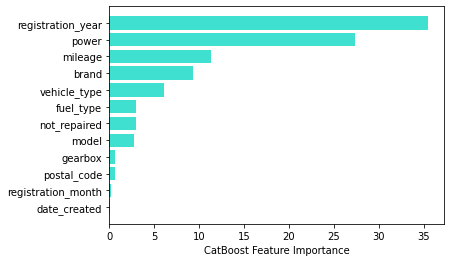

In [69]:
#Plotting feature importance in the CB model
sorted_feature_importance = cb_model.feature_importances_.argsort()
plt.barh(features_train_le.columns[sorted_feature_importance], cb_model.feature_importances_[sorted_feature_importance], color='turquoise')
plt.xlabel('CatBoost Feature Importance')
plt.show()

## Model analysis

- From least to greatest RMSE, the models come in at:
    - Random Forest Regression: 1564.64 (max_depth : 20, max_features : 6)
    - XGBM: 1656.59
    - CatBoost: 1685.24
    - LGBM: 1792.51 (100 iterations)
    - Decision Tree Regression: 2122.53 (max_depth: 20, max_features: 6, splitter: best)
    - Linear Regression: 3090050695580.55 (**Sanity Check**)
    
    
- In order of least to greatest wall time, the models clocked in at:
    - LGBM: 5.52 s
    - Decision Tree Regression: 16.6 s
    - Linear Regression: 24 s
    - XGBM: 8min 58s
    - CatBoost: 9min 29s
    - Random Forest Regression: 20min 59s
   
Upon further review, it may be possible that additional rounds of LGBM may result in lowered RMSE, with a neglible time cost given the high speed of the model. The same is true of XGBoost, though this would come with a medium time cost. The higher accuracy of RFR may not be worth the large time cost. It appears that the best balance of accuracy and speed lie in the gradient boosting models. 